# Productivity Detection Model

1. Loading Dataset<br>
 **1.A** Loading Auditing of Screenshots and Keystroke Datasets<br>
 **1.B** Concatenation of Dataframes<br>
 **1.C** Cleaning Dataframe<br>
 **1.D** Visualizing Dataframe<br>
 **1.E** Visualizing User Activity<br>
2. Autoencoder<br>
 **2.A** Mouse Keyboard Activity Autoencoder<br>
 **2.B** Sample Autoencoder Training<br>
 **2.C** Sample Autoencoder Evaluation<br>
 **2.D** Sample Reconstruction Analysis and Thresholding<br>
3. Object Detection and Segmentation<br>
 **3.A** Loading YOLOv11-Seg<br>
 **3.B** Sample YOLO Inference<br>
4. Multiple-User Productivity Detection<br>
 **4.A** Collecting Users<br>
 **4.B** Inference Loop<br>
 **4.C** Final Results<br>


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


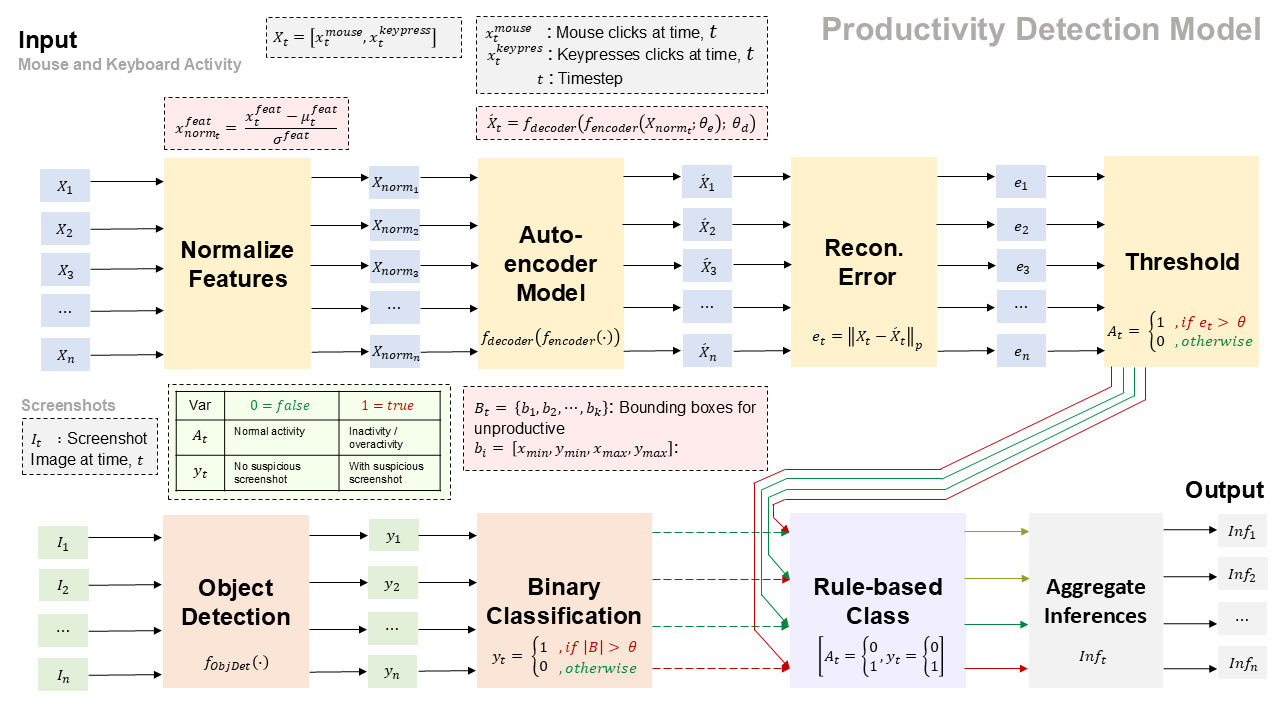

In [4]:
!cp "/content/drive/Shareddrives/task-estimation/Attempt1_Productivity_Detection_Model/PLAN.png" .
from IPython.display import Image, display

# Display the image
display(Image(filename='PLAN.png'))

# 1. Loading Datasets

## 1.A Loading Auditing of Screenshots and Keystroke Datasets

In [ ]:
import pandas as pd
import os


folder_path = r"C:\Users\Jeryl Salas\Documents\AI Work\Productivity\inference"
if os.path.exists(folder_path):
    print(os.listdir(folder_path))
else:
    print("The folder path does not exist.")

['CEBU-08_13.xlsx', 'CEBU-08_15.xlsx', 'CEBU-08_16.xlsx', 'CEBU-08_19.xlsx', 'CEBU-08_20.xlsx', 'CEBU-08_22.xlsx', 'CEBU-08_23.xlsx', 'CEBU-08_28.xlsx', 'CEBU-08_29.xlsx', 'CEBU-08_30.xlsx', 'CEBU-09_04.xlsx', 'CEBU-09_05.xlsx', 'CEBU-09_06.xlsx', 'CEBU-09_09.xlsx', 'CEBU-09_10.xlsx', 'CEBU-09_11.xlsx', 'CEBU-09_12.xlsx', 'CEBU-09_13.xlsx', 'CEBU-09_16.xlsx', 'CEBU-09_17.xlsx', 'CEBU-09_18.xlsx', 'CEBU-09_19.xlsx', 'CEBU-09_20.xlsx', 'CEBU-09_23.xlsx', 'CEBU-09_24.xlsx', 'CEBU-09_25.xlsx', 'CEBU-09_26.xlsx', 'CEBU-09_27.xlsx', 'CEBU-09_30.xlsx', '~$CEBU-09_04.xlsx', '~$CEBU-09_05.xlsx', '~$CEBU-09_06.xlsx', '~$CEBU-09_09.xlsx', '~$CEBU-09_10.xlsx', '~$CEBU-09_11.xlsx', '~$CEBU-09_12.xlsx', '~$CEBU-09_13.xlsx', '~$CEBU-09_16.xlsx', '~$CEBU-09_17.xlsx', '~$CEBU-09_18.xlsx', '~$CEBU-09_19.xlsx', '~$CEBU-09_20.xlsx', '~$CEBU-09_23.xlsx', '~$CEBU-09_24.xlsx', '~$CEBU-09_25.xlsx', '~$CEBU-09_26.xlsx', '~$CEBU-09_27.xlsx', '~$CEBU-09_30.xlsx']


## 1.B Concatenation of Dataframes

In [ ]:
import os
import pandas as pd
from datetime import datetime
import openpyxl
from IPython.display import display

# Define folder path containing files
folder_path = r"C:/Users/Jeryl Salas/Documents/AI Work/Productivity/Inference"  # Replace with your actual folder path

# Find and sort relevant files
xlsx_files = [f for f in os.listdir(folder_path) if (f.startswith('CEBU-08_') or f.startswith('CEBU-09_')) and f.endswith('.xlsx')]
xlsx_files.sort()

dfs = []

for file in xlsx_files:
    file_path = os.path.join(folder_path, file)
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook.active

    # Extract headers and data with hyperlinks
    headers = [cell for cell in next(sheet.iter_rows(values_only=True))]
    data = []
    for row in sheet.iter_rows(min_row=2):  # Skip the header row
        row_data = []
        for cell in row:
            if cell.hyperlink:
                row_data.append(cell.hyperlink.target)  # Extract the hyperlink URL
            else:
                row_data.append(cell.value)
        data.append(row_data)

    # Convert to a DataFrame
    df = pd.DataFrame(data, columns=headers)

    # Select specific columns
    columns_to_keep = ['Name', 'Time', 'Mouse Click', 'Keypress', 'Suspicious Screenshot', 'Link to Screenshot']
    df = df[columns_to_keep]

    # Extract date from filename
    month_part, day_part = file.split("_")[0][-2:], file.split("_")[1].split(".")[0]
    date = datetime.strptime(f"2024-{month_part}-{day_part}", "%Y-%m-%d").date()
    print(date)

    def parse_time(row):
        time_str = row['Time']

        # Debugging print
        print(f"Processing Time value: {time_str}")

        # Handle missing or invalid time values
        if pd.isna(time_str) or time_str.strip() == '':
            print(f"Invalid or missing Time value: {time_str}")
            return None

        # Clean up the time string
        time_str = time_str.replace("AM.", "AM").replace("PM.", "PM").strip()

        # Handle time strings with seconds (e.g., HH:MM:SS or HH:MM:SS AM/PM)
        if ":" in time_str and len(time_str.split(":")) == 3:
            time_str = ":".join(time_str.split(":")[:2])  # Remove seconds

        try:
            # Try parsing as 12-hour format
            return datetime.strptime(f"{date} {time_str}", "%Y-%m-%d %I:%M %p")
        except ValueError:
            try:
                # Fallback to 24-hour format
                return datetime.strptime(f"{date} {time_str}", "%Y-%m-%d %H:%M")
            except ValueError:
                print(f"Unable to parse Time value: {time_str}")
                return None



    # Apply the time parsing function
    df['Time'] = df['Time'].astype(str).replace('nan', None)
    df['Timestamp'] = df.apply(parse_time, axis=1)

    # Drop rows with invalid 'Timestamp'
    df = df.dropna(subset=['Timestamp']).reset_index(drop=True)

    # Ensure 'Timestamp' is datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Drop the original 'Time' column
    df.drop(columns=['Time'], inplace=True)

    dfs.append(df)

# Combine all dataframes
entire_month_df = pd.concat(dfs, ignore_index=True)

# Calculate time differences in minutes
entire_month_df['time_delta'] = entire_month_df['Timestamp'].diff().dt.total_seconds().fillna(0) / 60

# Display the final DataFrame
display(entire_month_df)


2024-08-13
Processing Time value: 08:12:00
Processing Time value: 08:55:00
Processing Time value: 09:04:00
Processing Time value: 13:59:00
Processing Time value: 14:19:00
Processing Time value: 14:39:00
Processing Time value: 14:44:00
Processing Time value: 15:00:00
Processing Time value: 16:15:00
Processing Time value: 16:28:00
Processing Time value: 16:46:00
Processing Time value: 10:31:00
Processing Time value: 10:38:00
Processing Time value: 10:49:00
Processing Time value: 10:59:00
Processing Time value: 11:10:00
Processing Time value: 11:19:00
Processing Time value: 11:36:00
Processing Time value: 11:57:00
Processing Time value: 13:12:00
Processing Time value: 13:36:00
Processing Time value: 08:04:00
Processing Time value: 08:24:00
Processing Time value: 08:42:00
Processing Time value: 08:49:00
Processing Time value: 09:39:00
Processing Time value: 09:48:00
Processing Time value: 10:24:00
Processing Time value: 10:41:00
Processing Time value: 10:54:00
Processing Time value: 08:44:

,Name,Mouse Click,Keypress,Suspicious Screenshot,Link to Screenshot,Timestamp,time_delta
0,"Amorado, Mary Ann",0.0,2.0,No,https://drive.google.com/file/d/1gynUZfTmxJCP_...,2024-08-13 08:12:00,0.0
1,"Amorado, Mary Ann",1.0,47.0,No,https://drive.google.com/file/d/1xgN1wXaKcOlKH...,2024-08-13 08:55:00,43.0
2,"Amorado, Mary Ann",1.0,9.0,No,https://drive.google.com/file/d/1XaZ8Rn69je8WO...,2024-08-13 09:04:00,9.0
3,"Amorado, Mary Ann",7.0,17.0,No,https://drive.google.com/file/d/1XaZ8Rn69je8WO...,2024-08-13 13:59:00,295.0
4,"Amorado, Mary Ann",4.0,7.0,No,https://drive.google.com/file/d/1hHI17SL59Su7O...,2024-08-13 14:19:00,20.0
...,...,...,...,...,...,...,...
16030,"Baguio, Virgil Mathew Y",0,0,No,https://drive.google.com/open?id=1zW7OxZ8OEc1S...,2024-09-30 08:22:00,15.0
16031,"Baguio, Virgil Mathew Y",6,6,No,https://drive.google.com/open?id=1ic79qpSr1xF5...,2024-09-30 08:41:00,19.0
16032,"Baguio, Virgil Mathew Y",7,17,No,https://drive.google.com/open?id=1W4l9pcrABwKL...,2024-09-30 08:57:00,16.0
16033,"Baguio, Virgil Mathew Y",2,0,No,https://drive.google.com/open?id=1Tci6cMGSCkYz...,2024-09-30 09:11:00,14.0


## 1.C Cleaning Dataframe

In [ ]:
df_cleaned_month = entire_month_df.copy()

df_cleaned_month['Mouse Click'] = pd.to_numeric(df_cleaned_month['Mouse Click'], errors='coerce')
df_cleaned_month['Keypress'] = pd.to_numeric(df_cleaned_month['Keypress'], errors='coerce')

df_cleaned_month = df_cleaned_month.dropna(subset=['Mouse Click', 'Keypress', 'Suspicious Screenshot', 'Link to Screenshot'])


non_empty_rows_month = df_cleaned_month[(df_cleaned_month['Mouse Click'] != 0) & (df_cleaned_month['Keypress'] != 0)].shape[0]
zero_rows_month = df_cleaned_month[(df_cleaned_month['Mouse Click'] == 0) & (df_cleaned_month['Keypress'] == 0)].shape[0]


print(f"Number of rows with non-empty mouse clicks and keypresses (entire month): {non_empty_rows_month}")
print(f"Number of rows with 0 mouse clicks and keypresses (entire month): {zero_rows_month}")
print(df_cleaned_month)

Number of rows with non-empty mouse clicks and keypresses (entire month): 8759
Number of rows with 0 mouse clicks and keypresses (entire month): 2268
                          Name  Mouse Click  Keypress Suspicious Screenshot  \
0            Amorado, Mary Ann          0.0       2.0                    No   
1            Amorado, Mary Ann          1.0      47.0                    No   
2            Amorado, Mary Ann          1.0       9.0                    No   
3            Amorado, Mary Ann          7.0      17.0                    No   
4            Amorado, Mary Ann          4.0       7.0                    No   
...                        ...          ...       ...                   ...   
16030  Baguio, Virgil Mathew Y          0.0       0.0                    No   
16031  Baguio, Virgil Mathew Y          6.0       6.0                    No   
16032  Baguio, Virgil Mathew Y          7.0      17.0                    No   
16033  Baguio, Virgil Mathew Y          2.0       0.0       

## 1.D Visualizing Dataframe

C:\Users\Jeryl Salas\AppData\Local\Temp\ipykernel_24912\1038728939.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df_month.resample('H', on='Timestamp').sum()


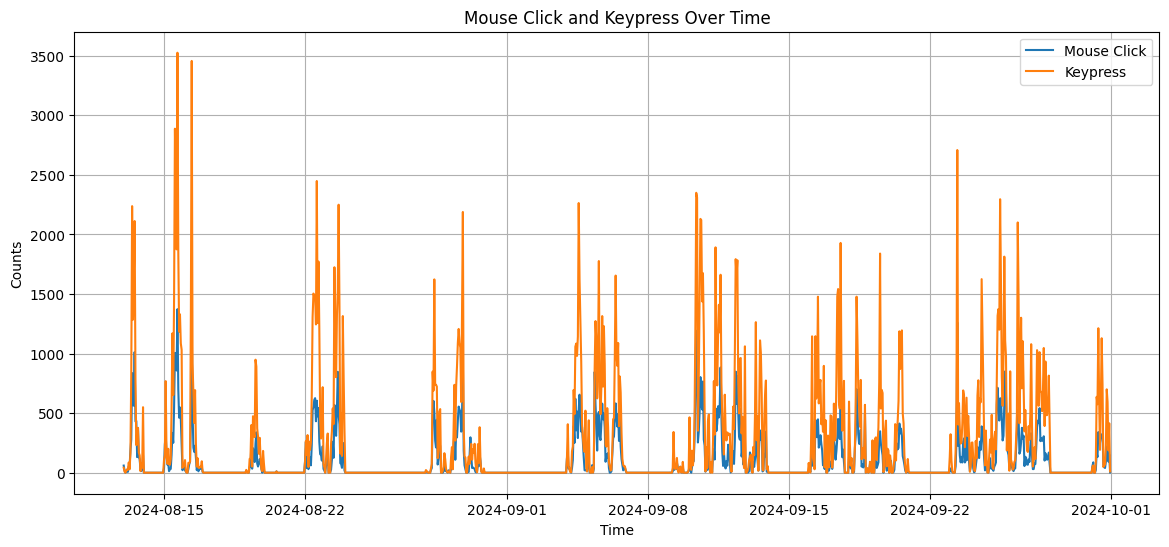

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Converting timestamp to datetime format
df_month = df_cleaned_month.copy()
df_month['Timestamp'] = pd.to_datetime(df_month['Timestamp'])

# Resampling data to hourly intervals
df_resampled = df_month.resample('H', on='Timestamp').sum()


plt.figure(figsize=(14, 6))
plt.plot(df_resampled.index, df_resampled['Mouse Click'], label='Mouse Click')
plt.plot(df_resampled.index, df_resampled['Keypress'], label='Keypress')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.title('Mouse Click and Keypress Over Time')
plt.legend()
plt.grid()
plt.show()

## 1.E Visualizing User Activity

                      Name  Mouse Click  Keypress Suspicious Screenshot  \
1263   Jan Dave Presbitero         26.0      47.0                    No   
1264   Jan Dave Presbitero         71.0      52.0                    No   
1265   Jan Dave Presbitero          6.0      16.0                    No   
1266   Jan Dave Presbitero         16.0      88.0                    No   
1267   Jan Dave Presbitero         16.0      19.0                    No   
...                    ...          ...       ...                   ...   
15578  Jan Dave Presbitero          4.0       1.0                    No   
15579  Jan Dave Presbitero         11.0       1.0                    No   
15580  Jan Dave Presbitero          0.0       0.0                    No   
15581  Jan Dave Presbitero         10.0      54.0                    No   
15582  Jan Dave Presbitero         10.0       3.0                    No   

                                      Link to Screenshot           Timestamp  \
1263   https://driv

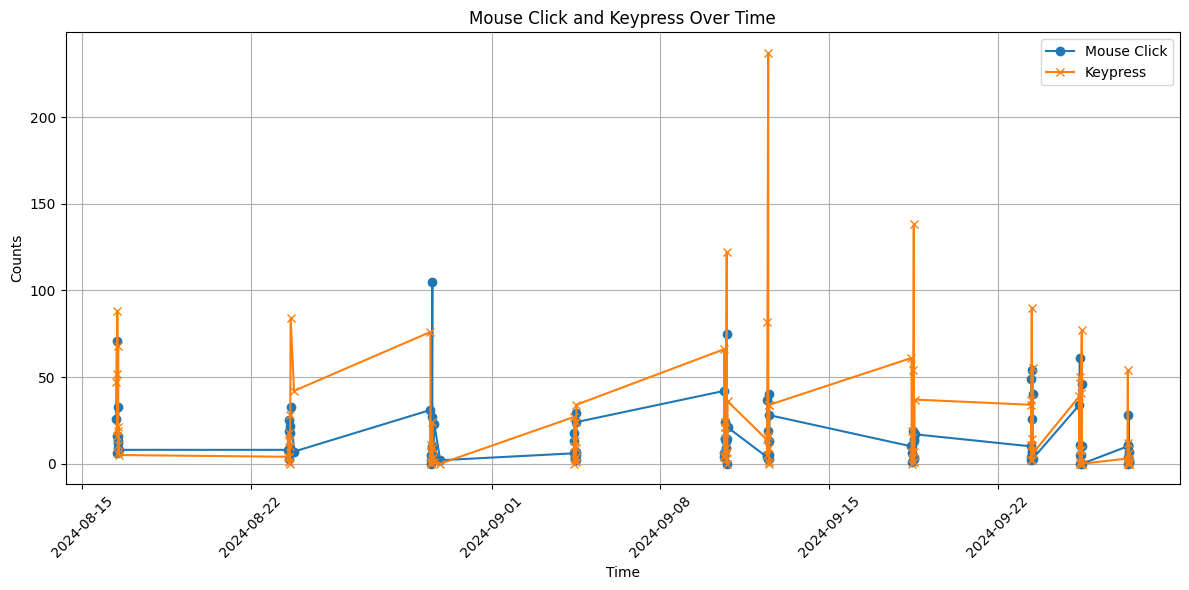

In [ ]:
# Filter data for a specific user
user_name = "Jan Dave Presbitero"  # Replace with the actual name you want to filter
user_data = df_cleaned_month[df_cleaned_month['Name'] == user_name]

# Display the filtered data for the user
print(user_data)
df = user_data.copy()

# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort by Timestamp (important for plotting)
df = df.sort_values(by='Timestamp')

# Plot Mouse Click and Keypress over time
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['Mouse Click'], label='Mouse Click', marker='o')
plt.plot(df['Timestamp'], df['Keypress'], label='Keypress', marker='x')

# Add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Counts')
plt.title('Mouse Click and Keypress Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis for better readability

# Show the plot
plt.tight_layout()
plt.show()

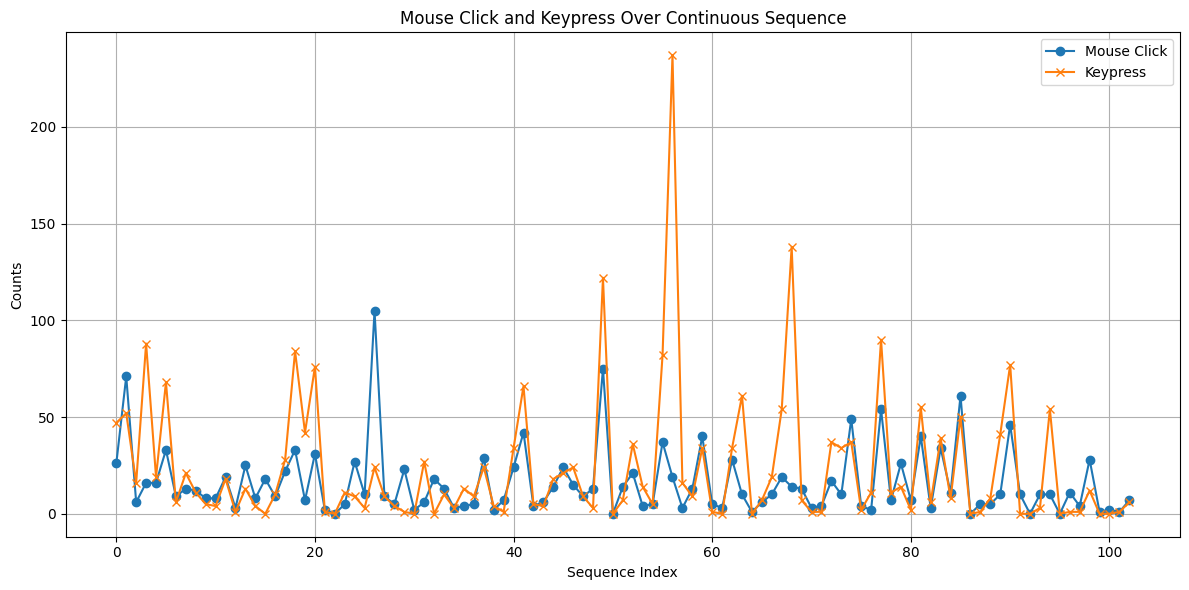

In [ ]:
df = df.sort_values(by='Timestamp')

# Create a continuous index
df['Index'] = range(len(df))

# Plot Mouse Click and Keypress over the continuous index
plt.figure(figsize=(12, 6))
plt.plot(df['Index'], df['Mouse Click'], label='Mouse Click', marker='o')
plt.plot(df['Index'], df['Keypress'], label='Keypress', marker='x')

# Add labels, title, and legend
plt.xlabel('Sequence Index')
plt.ylabel('Counts')
plt.title('Mouse Click and Keypress Over Continuous Sequence')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Select features to normalize
features = ['Mouse Click', 'Keypress']

# Apply Min-Max scaling
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Convert to NumPy array for PyTorch
data = df[features].values

# 2. Autoencoders

In [ ]:
import numpy as np

# Define sliding window size
window_size = 10

# Create windows
windows = [data[i:i + window_size] for i in range(len(data) - window_size + 1)]
windows = np.array(windows)  # Shape: (num_windows, window_size, num_features)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# Initialize the model
input_dim = window_size * data.shape[1]  # Flattened input
latent_dim = 16  # Dimension of the latent space
model = Autoencoder(input_dim, latent_dim)


using device: cuda


## 2.A Mouse Keyboard Activity Autoencoder

In [ ]:
# Flatten each window for the autoencoder input
flattened_windows = windows.reshape(windows.shape[0], -1)  # Shape: (num_windows, input_dim)

# Convert to PyTorch tensors
data_tensor = torch.tensor(flattened_windows, dtype=torch.float32)

# Create a DataLoader
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## 2.B Sample Autoencoder Training

In [ ]:
# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 50
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        batch_data = batch[0]  # Shape: (batch_size, input_dim)

        # Forward pass
        reconstructed = model(batch_data)
        loss = criterion(reconstructed, batch_data)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

Epoch 1/50, Loss: 1.0226
Epoch 2/50, Loss: 1.0117
Epoch 3/50, Loss: 0.9956
Epoch 4/50, Loss: 0.9832
Epoch 5/50, Loss: 0.9737
Epoch 6/50, Loss: 0.9629
Epoch 7/50, Loss: 0.9527
Epoch 8/50, Loss: 0.9435
Epoch 9/50, Loss: 0.9301
Epoch 10/50, Loss: 0.9193
Epoch 11/50, Loss: 0.9065
Epoch 12/50, Loss: 0.8872
Epoch 13/50, Loss: 0.8683
Epoch 14/50, Loss: 0.8484
Epoch 15/50, Loss: 0.8242
Epoch 16/50, Loss: 0.8026
Epoch 17/50, Loss: 0.7800
Epoch 18/50, Loss: 0.7571
Epoch 19/50, Loss: 0.7287
Epoch 20/50, Loss: 0.7018
Epoch 21/50, Loss: 0.6776
Epoch 22/50, Loss: 0.6530
Epoch 23/50, Loss: 0.6252
Epoch 24/50, Loss: 0.6043
Epoch 25/50, Loss: 0.5803
Epoch 26/50, Loss: 0.5578
Epoch 27/50, Loss: 0.5375
Epoch 28/50, Loss: 0.5176
Epoch 29/50, Loss: 0.4955
Epoch 30/50, Loss: 0.4749
Epoch 31/50, Loss: 0.4571
Epoch 32/50, Loss: 0.4370
Epoch 33/50, Loss: 0.4177
Epoch 34/50, Loss: 0.3996
Epoch 35/50, Loss: 0.3827
Epoch 36/50, Loss: 0.3682
Epoch 37/50, Loss: 0.3534
Epoch 38/50, Loss: 0.3418
Epoch 39/50, Loss: 0.

## 2.C Sample Autoencoder Evaluation

In [ ]:
# Switch to evaluation mode
model.eval()

# Compute reconstruction errors
reconstruction_errors = []
with torch.no_grad():
    for batch in dataloader:
        batch_data = batch[0]
        reconstructed = model(batch_data)
        errors = torch.mean((reconstructed - batch_data) ** 2, dim=1)  # MSE per window
        reconstruction_errors.extend(errors.numpy())

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)  # Top 5% as anomalies

# Flag anomalies
anomalies = np.where(np.array(reconstruction_errors) > threshold)[0]
print(f"Anomalies detected at windows: {anomalies}")

Anomalies detected at windows: [ 4 15 25 34 90]


## 2.D Sample Reconstruction Analysis and Thresholding

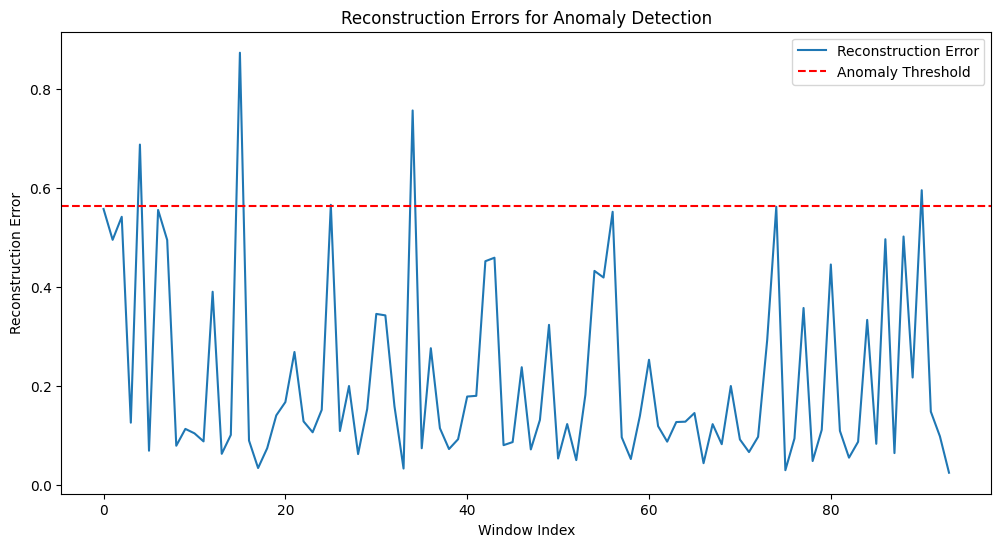

In [ ]:
# Plot reconstruction errors
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.xlabel('Window Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors for Anomaly Detection')
plt.legend()
plt.show()

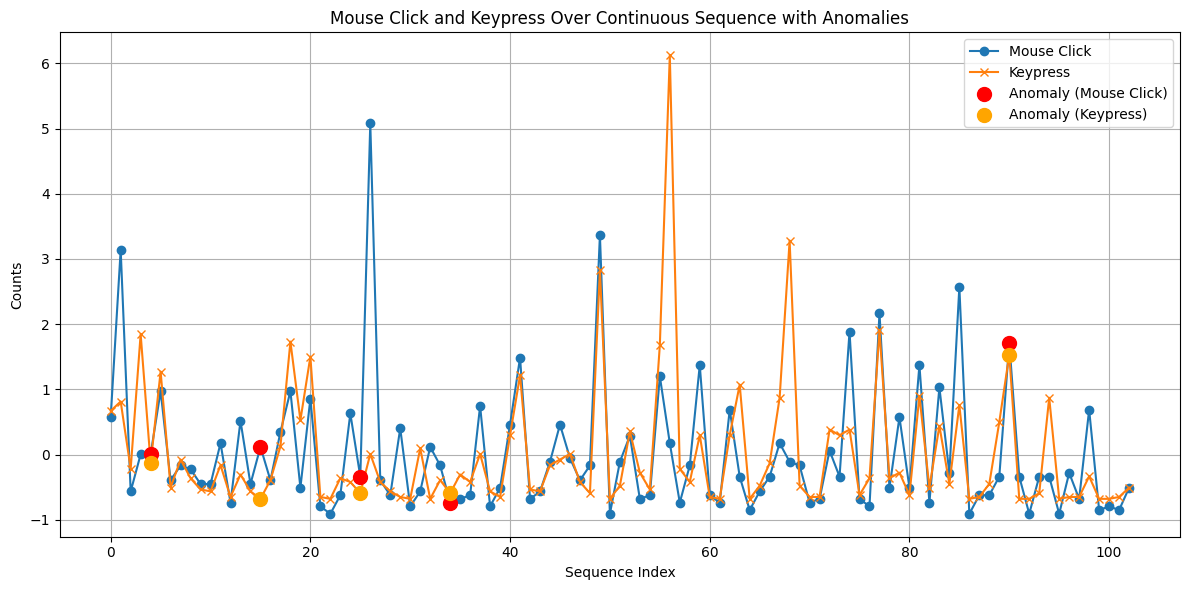

In [ ]:
# Assuming 'anomalies' contains indices of the anomalous windows
# For simplicity, extract the indices of anomalies from the original data
anomaly_indices = anomalies  # Replace with your list of anomaly indices

# Extract the anomaly points for Mouse Click and Keypress
anomaly_points_click = df.iloc[anomaly_indices]['Mouse Click']
anomaly_points_keypress = df.iloc[anomaly_indices]['Keypress']

# Plot Mouse Click and Keypress
plt.figure(figsize=(12, 6))
plt.plot(df['Index'], df['Mouse Click'], label='Mouse Click', marker='o')
plt.plot(df['Index'], df['Keypress'], label='Keypress', marker='x')

# Plot anomalies as red markers
plt.scatter(anomaly_indices, anomaly_points_click, color='red', label='Anomaly (Mouse Click)', s=100, zorder=5)
plt.scatter(anomaly_indices, anomaly_points_keypress, color='orange', label='Anomaly (Keypress)', s=100, zorder=5)

# Add labels, title, and legend
plt.xlabel('Sequence Index')
plt.ylabel('Counts')
plt.title('Mouse Click and Keypress Over Continuous Sequence with Anomalies')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
anomalous_rows = df.iloc[anomalies]

anomaly_dict = {}

# Append anomalous rows to the dictionary
for idx, row in anomalous_rows.iterrows():
    anomaly_dict[idx] = row.to_dict()


print(anomaly_dict)

{1267: {'Name': 'Jan Dave Presbitero', 'Mouse Click': 0.0038752252985057257, 'Keypress': -0.1335103788749743, 'Suspicious Screenshot': 'No', 'Link to Screenshot': 'https://drive.google.com/file/d/1TL0ZRwJqJ8eKca6bHUebxf8lR2-eaKLL/view?usp=drive_link', 'Timestamp': Timestamp('2024-08-16 11:50:00'), 'time_delta': 41.0, 'Index': 4}, 2760: {'Name': 'Jan Dave Presbitero', 'Mouse Click': 0.11791756979738781, 'Keypress': -0.6789797138610386, 'Suspicious Screenshot': 'No', 'Link to Screenshot': 'https://drive.google.com/file/d/1NTDfhjYa0qJupSHUPkFoJdrSiENsjHaL/view?usp=drive_link', 'Timestamp': Timestamp('2024-08-23 14:52:00'), 'time_delta': -19.0, 'Index': 15}, 3794: {'Name': 'Jan Dave Presbitero', 'Mouse Click': -0.33825180819814055, 'Keypress': -0.5928529767579758, 'Suspicious Screenshot': 'No', 'Link to Screenshot': 'https://drive.google.com/file/d/1n2hHbUK23mp-y_f3nUEXKRqqfu_JOZvV/view?usp=drive_link', 'Timestamp': Timestamp('2024-08-29 12:16:00'), 'time_delta': 8.0, 'Index': 25}, 4585: {

# 3. Object Detection and Segmentation

## 3.A Loading YOLOv11-Seg

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from ultralytics.utils.plotting import Annotator

# Load the YOLO model
model = YOLO(r'C:/Users/Jeryl Salas/Documents/AI Work/Productivity/runs/segment/train4/weights/best.pt')  # Replace with your .pt file path

## 3.B Sample YOLO Inference


image 1/1 C:\Users\Jeryl Salas\Documents\AI Work\Productivity\val\Unproductive Unproductive August 29, 2024 at 07_30 PM.png: 384x640 1 Unproductive, 139.9ms
Speed: 7.0ms preprocess, 139.9ms inference, 168.4ms postprocess per image at shape (1, 3, 384, 640)


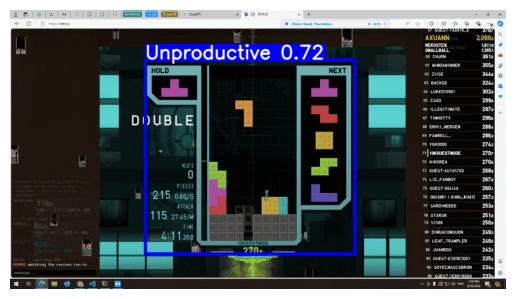

In [ ]:
# Define the image for inference
image_path = r'C:/Users/Jeryl Salas/Documents/AI Work/Productivity/val/Unproductive Unproductive August 29, 2024 at 07_30 PM.png'  # Replace with your image path

# Perform inference
results = model.predict(source=image_path, conf=0.25)  # Adjust confidence threshold as needed

# Load the original image
img = cv2.imread(image_path)

# Initialize the Annotator with RED color and thicker boxes
annotator = Annotator(img, line_width=3, font_size=20)  # Adjust `line_width` for thickness, `font_size` for text

# Loop through detected boxes and add them to the image
for box in results[0].boxes:
    # Draw the box with label and confidence score
    annotator.box_label(
        box.xyxy[0],  # Coordinates of the box
        f"{results[0].names[int(box.cls)]} {box.conf.item():.2f}",  # Convert confidence tensor to float
        color=(255, 0, 0)  # Red color in BGR format
    )

# Retrieve the annotated image
annotated_img = annotator.result()

# Display the image with bounding boxes
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# 4. Multiple-User Productivity Detection

## 4.A Collecting Users

In [ ]:
# Get unique names from the "Name" column
unique_names = df_cleaned_month['Name'].unique()

print(unique_names)

unique_names_list = unique_names.tolist()

['Amorado, Mary Ann' 'Mariel Bula' 'Jabes Tañiza' 'Denner Achay' 'Maybel Antolijao' 'Dorren Jill Angelia' 'Reyes, Mary Roseanne' 'Uy, Brant Francis S.' 'Chris Jesson Giango' 'Frias, -Hershey KhrysteneLi' 'Caballes, Marnie Batistil' 'Zapanta, Johnel' 'Cowan Hopkins' 'Jed Donaire' 'Sagrado, Sheldon Arthur'
 'Abella, Ma Sophya' 'Acharon, Riane Nichelle Daeve Igot' 'Agtarap, Christian' 'Alkuino, Christine Mae Gonzaga' 'Hazel Joy Arong' 'Jordan Rey Espedillon' 'Neil Estrellanes' 'John Danray Lactao' 'Lantape, Obed Jell Castro' 'James Bryan Galleon' 'Jumawan, Joanna Marie Magtabog' 'Lantape, Jacqueline Bautista'
 'Lasola, Hannah' 'Lava, Joaquin' 'Manabat, Pink Lloyd' 'Morata, Keilah Mae' 'Limoran Jonree' 'Devanie James Oporto' 'Dianne Orcullo' 'Leodegario Jr. Paglinawan' 'Dustin Ricarte' 'John Lester Roble' 'Palabrica, Kayelenn Mei Fleur' 'Bulawan, Rina' 'Cañada, John Benedic' 'Carillas, Marvin' 'Enjaynes, Justin Jade'
 'Enriquez, Arthur Haradji' 'Zeniva Jayne Atabay' 'Annie Faith Cabinatan'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# Initialize the model
input_dim = window_size * data.shape[1]  # Flattened input
latent_dim = 16  # Dimension of the latent space
encoder_model = Autoencoder(input_dim, latent_dim)

using device: cuda


In [ ]:
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

obj_model = YOLO(r'C:/Users/Jeryl Salas/Documents/AI Work/Productivity/runs/segment/train4/weights/best.pt')  # Replace with your .pt file path

In [ ]:
import re
import cv2
import numpy as np

import asyncio

async def async_process_image_from_url(session, drive_url, retries=3):
    """
    Asynchronously fetches and processes an image from a Google Drive link with retry logic.
    """
    try:
        # Extract the file ID from the Google Drive link
        file_id_match = re.search(r'/d/(.*?)/', drive_url)
        if file_id_match:
            file_id = file_id_match.group(1)
            download_url = f"https://drive.google.com/uc?id={file_id}&export=download"
        else:
            print(f"Invalid Google Drive link: {drive_url}")
            return drive_url, None

        for attempt in range(retries):
            async with session.get(download_url) as response:
                if response.status == 200:
                    # Convert the content to a NumPy array
                    image_data = np.asarray(bytearray(await response.read()), dtype="uint8")
                    image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)
                    if image is not None:
                        return drive_url, image
                    else:
                        print(f"Failed to decode image from {drive_url}")
                elif response.status == 429:  # Rate limit exceeded
                    wait_time = 1 ** attempt  # Exponential backoff
                    print(f"Rate limit exceeded. Retrying in {wait_time} seconds...")
                    await asyncio.sleep(wait_time)
                else:
                    print(f"Failed to download image from {drive_url}. HTTP Status: {response.status}")
                    break

    except Exception as e:
        print(f"Error processing image from {drive_url}: {e}")
    return drive_url, None



## 4.B Inference Loop

In [ ]:
import torch
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import os
import aiohttp
import asyncio
from PIL import Image
from io import BytesIO
import nest_asyncio
from functools import partial

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
nest_asyncio.apply()

# Initialize anomaly tracker columns
df_cleaned_month['anomaly_screenshots'] = False
df_cleaned_month['anomaly_mouseclicks'] = False
df_cleaned_month['anomaly_keypress'] = False

# Move object detection model to GPU
obj_model.to(device)

# Global settings
cpu_cores = os.cpu_count()
max_workers = min(cpu_cores, 16)  # Limit max workers for I/O-bound tasks
window_size = 10
batch_size = 32
latent_dim = 16  # Latent space dimension for the autoencoder
epochs = 50

print(f"Max workers: {max_workers}")

# Asynchronous image loading function
async def async_load_image(session, link):
    try:
        async with session.get(link) as response:
            if response.status == 200:
                image_data = await response.read()
                return link, Image.open(BytesIO(image_data))  # Replace with your processing logic
            else:
                print(f"Failed to load image from {link}: HTTP {response.status}")
                return link, None
    except Exception as e:
        print(f"Error loading image from {link}: {e}")
        return link, None

# Batch processing for asynchronous image loading
async def process_image_batches_async(links, batch_size):
    """
    Processes image links in batches asynchronously, with rate-limiting.
    """
    image_dict = {}
    for i in range(0, len(links), batch_size):
        batch_links = links[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1}/{len(links) // batch_size + 1}")

        async with aiohttp.ClientSession() as session:
            tasks = [async_process_image_from_url(session, link) for link in batch_links]
            results = await asyncio.gather(*tasks)

            # Store successfully processed images
            for link, image in results:
                if image is not None:
                    image_dict[link] = image

        # Introduce a delay between batches to avoid rate limiting
        print("Rate limiting: Waiting for 1 second...")
        await asyncio.sleep(1)  # Adjust this delay if needed

    return image_dict

# Synchronous wrapper for async image processing
def preload_images(links, batch_size=50):
    """
    Synchronous wrapper for asynchronous image preloading.
    """
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(process_image_batches_async(links, batch_size))


# Preload images asynchronously
print("Preloading images asynchronously...")
links = df_cleaned_month['Link to Screenshot'].dropna().unique()
batch_size = 150  # Adjust batch size based on memory constraints

image_dict = preload_images(links, batch_size=batch_size)
print(f"Preloaded {len(image_dict)} images successfully.")

Using device: cuda
Max workers: 12
Preloading images asynchronously...
Processing batch 1/85
Rate limiting: Waiting for 1 second...
Processing batch 2/85
Invalid Google Drive link: https://drive.google.com/drive/folders/1m0qOTBrzqpFGPZ5eva8ZYTQtl6WimS2v?usp=drive_link
Failed to decode image from https://drive.google.com/file/d/1cc918u0kEoOhYZKeFkBOC7VfYszWYjGl/view?usp=drive_link
Failed to decode image from https://drive.google.com/file/d/1v5eKRXPtAcD39dKk6hJwHtkp0AM0X7kB/view?usp=drive_link
Failed to decode image from https://drive.google.com/file/d/197CHyz9FY9LW85iwRHv_V2KTmhYMjLd8/view?usp=drive_link
Failed to decode image from https://drive.google.com/file/d/1iD-YJzcE6F1WvXKAAr2wjIGUxc5uWp56/view?usp=drive_link
Failed to decode image from https://drive.google.com/file/d/1ckwU3TDR27Npe2hseBUCWuSBB3rrkLrq/view?usp=drive_link
Failed to decode image from https://drive.google.com/file/d/1cc918u0kEoOhYZKeFkBOC7VfYszWYjGl/view?usp=drive_link
Failed to decode image from https://drive.googl

In [ ]:
import time

# Autoencoder definition
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, latent_dim),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, input_dim),
            torch.nn.ReLU()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

print(obj_model)
print(encoder_model)

# Anomaly screenshots tracker
dfs = []
df_cleaned_month['anomaly_screenshots'] = False  # Initialize the column
df_cleaned_month['anomaly_mouseclicks'] = False
df_cleaned_month['anomaly_keypress'] = False

# Loop through each unique user
for name in tqdm(unique_names_list, desc="Detecting Anomalies"):

    # Filter by user
    user_data = df_cleaned_month[df_cleaned_month['Name'] == name]
    df = user_data.copy()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.sort_values(by='Timestamp')

    # Skip Empty Timestamps
    df['Index'] = range(len(df))

    # Normalize Features
    features = ['Mouse Click', 'Keypress']
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    data = df[features].values  # Convert to NumPy

    if len(data) < window_size:
        print(f"Not enough data for {name} to create sliding windows. Skipping...")
        continue

    # Create Windows
    ae_starttime = time.time()
    window_size = 10
    windows = [data[i:i + window_size] for i in range(len(data) - window_size + 1)]
    windows = np.array(windows)  # Shape: (num_windows, window_size, num_features)

    # Feed to Device
    flattened_windows = windows.reshape(windows.shape[0], -1)  # Shape: (num_windows, input_dim)
    data_tensor = torch.tensor(flattened_windows, dtype=torch.float32).to(device)
    batch_size = 32
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize the Autoencoder Model for Each User
    input_dim = flattened_windows.shape[1]
    latent_dim = 16  # Latent space dimension
    model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)  # Move model to device
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    # Train Autoencoder
    epochs = 50
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch_data = batch[0].to(device)  # Move batch to device

            # Forward pass
            reconstructed = model(batch_data)
            loss = criterion(reconstructed, batch_data)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    # Inference from Autoencoder
    model.eval()

    reconstruction_errors = []  # Compute reconstruction errors
    with torch.no_grad():
        for batch in dataloader:
            batch_data = batch[0].to(device)  # Move batch to device
            reconstructed = model(batch_data)
            errors = torch.mean((reconstructed - batch_data) ** 2, dim=1)  # MSE per window
            reconstruction_errors.extend(errors.cpu().numpy())  # Move results to CPU

    threshold = np.percentile(reconstruction_errors, 95)  # Top 5% as anomalies
    anomalies = np.where(np.array(reconstruction_errors) > threshold)[0]

    # Process Anomalies
    anomaly_indices = anomalies
    anomalous_rows = df.iloc[anomaly_indices]

    for idx in anomaly_indices:
        df.loc[idx, 'anomaly_mouseclicks'] = True
        df.loc[idx, 'anomaly_keypress'] = True

    ae_endtime = time.time()
    ae_duration = ae_endtime - ae_starttime
    print(f"AE: 20x2->16x1 ({str(len(anomaly_indices)) if len(anomaly_indices) > 0 else 'no'} detections), {ae_duration}s")
    print("YOLOv11-seg:")
    # Perform YOLO inference on preloaded images
    valid_links = df.loc[~df['Link to Screenshot'].isna(), 'Link to Screenshot']
    valid_images = [image_dict[link] for link in valid_links if link in image_dict]

    if valid_images:
        # Perform batch inference with YOLO
        results = obj_model.predict(source=valid_images, conf=0.25)

        # Analyze results and mark anomalies
        for i, result in enumerate(results):
            if len(result.boxes) > 0:  # No detections
                idx = valid_links.index[i]
                df.loc[idx, 'anomaly_screenshots'] = True

    dfs.append(df)

results_df = pd.concat(dfs, ignore_index=True)



YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_run

Detecting Anomalies:   0%|          | 0/387 [00:00<?, ?it/s]

AE: 20x2->16x1 (4 detections), 0.6620571613311768s
YOLOv11-seg:

0: 640x640 (no detections), 121.1ms
1: 640x640 1 Unproductive, 121.1ms
2: 640x640 (no detections), 121.1ms
3: 640x640 (no detections), 121.1ms
4: 640x640 (no detections), 121.1ms
5: 640x640 (no detections), 121.1ms
6: 640x640 (no detections), 121.1ms
7: 640x640 (no detections), 121.1ms
8: 640x640 (no detections), 121.1ms
9: 640x640 (no detections), 121.1ms
10: 640x640 (no detections), 121.1ms
11: 640x640 (no detections), 121.1ms
12: 640x640 (no detections), 121.1ms
13: 640x640 (no detections), 121.1ms
14: 640x640 (no detections), 121.1ms
15: 640x640 (no detections), 121.1ms
16: 640x640 1 Unproductive, 121.1ms
17: 640x640 (no detections), 121.1ms
18: 640x640 1 Unproductive, 121.1ms
19: 640x640 (no detections), 121.1ms
20: 640x640 (no detections), 121.1ms
21: 640x640 (no detections), 121.1ms
22: 640x640 (no detections), 121.1ms
23: 640x640 (no detections), 121.1ms
24: 640x640 (no detections), 121.1ms
25: 640x640 (no detecti

Detecting Anomalies:   0%|          | 1/387 [00:10<1:04:34, 10.04s/it]

AE: 20x2->16x1 (1 detections), 0.0946502685546875s
YOLOv11-seg:

0: 384x640 (no detections), 10.3ms
1: 384x640 (no detections), 10.3ms
2: 384x640 (no detections), 10.3ms
3: 384x640 (no detections), 10.3ms
4: 384x640 (no detections), 10.3ms
5: 384x640 (no detections), 10.3ms
6: 384x640 (no detections), 10.3ms
7: 384x640 (no detections), 10.3ms
8: 384x640 (no detections), 10.3ms
9: 384x640 (no detections), 10.3ms
10: 384x640 (no detections), 10.3ms
11: 384x640 (no detections), 10.3ms
12: 384x640 (no detections), 10.3ms
13: 384x640 (no detections), 10.3ms
14: 384x640 (no detections), 10.3ms
15: 384x640 (no detections), 10.3ms
16: 384x640 (no detections), 10.3ms
17: 384x640 (no detections), 10.3ms
18: 384x640 (no detections), 10.3ms
19: 384x640 (no detections), 10.3ms
20: 384x640 (no detections), 10.3ms
21: 384x640 (no detections), 10.3ms
22: 384x640 (no detections), 10.3ms
23: 384x640 (no detections), 10.3ms
24: 384x640 (no detections), 10.3ms
25: 384x640 (no detections), 10.3ms
26: 384x6

Detecting Anomalies:   1%|          | 2/387 [00:10<28:25,  4.43s/it]  

AE: 20x2->16x1 (1 detections), 0.09607481956481934s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
20: 384x640 (no detections), 10.8ms
21: 384x640 (no detections), 10.8ms
22: 384x640 (no detections), 10.8ms
23: 384x640 (no detections), 10.8ms
24: 384x640 (no detections), 10.8ms
25: 384x640 (no detections), 10.8ms
26: 384x

Detecting Anomalies:   1%|          | 3/387 [00:11<16:50,  2.63s/it]

AE: 20x2->16x1 (2 detections), 0.2169017791748047s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x6

Detecting Anomalies:   1%|          | 4/387 [00:11<12:21,  1.94s/it]

AE: 20x2->16x1 (2 detections), 0.10397768020629883s
YOLOv11-seg:

0: 384x640 (no detections), 10.3ms
1: 384x640 (no detections), 10.3ms
2: 384x640 (no detections), 10.3ms
3: 384x640 (no detections), 10.3ms
4: 384x640 (no detections), 10.3ms
5: 384x640 (no detections), 10.3ms
6: 384x640 (no detections), 10.3ms
7: 384x640 (no detections), 10.3ms
8: 384x640 (no detections), 10.3ms
9: 384x640 (no detections), 10.3ms
10: 384x640 (no detections), 10.3ms
11: 384x640 (no detections), 10.3ms
12: 384x640 (no detections), 10.3ms
13: 384x640 (no detections), 10.3ms
14: 384x640 (no detections), 10.3ms
15: 384x640 (no detections), 10.3ms
16: 384x640 (no detections), 10.3ms
17: 384x640 (no detections), 10.3ms
18: 384x640 (no detections), 10.3ms
19: 384x640 (no detections), 10.3ms
20: 384x640 (no detections), 10.3ms
21: 384x640 (no detections), 10.3ms
22: 384x640 (no detections), 10.3ms
23: 384x640 (no detections), 10.3ms
24: 384x640 (no detections), 10.3ms
25: 384x640 (no detections), 10.3ms
26: 384x

Detecting Anomalies:   1%|▏         | 5/387 [00:12<09:01,  1.42s/it]

AE: 20x2->16x1 (2 detections), 0.11761188507080078s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x

Detecting Anomalies:   2%|▏         | 6/387 [00:13<07:21,  1.16s/it]

AE: 20x2->16x1 (1 detections), 0.17362642288208008s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x

Detecting Anomalies:   2%|▏         | 7/387 [00:13<06:09,  1.03it/s]

AE: 20x2->16x1 (1 detections), 0.1222987174987793s
YOLOv11-seg:

0: 640x640 (no detections), 18.2ms
1: 640x640 (no detections), 18.2ms
2: 640x640 (no detections), 18.2ms
3: 640x640 (no detections), 18.2ms
4: 640x640 (no detections), 18.2ms
5: 640x640 (no detections), 18.2ms
6: 640x640 (no detections), 18.2ms
7: 640x640 (no detections), 18.2ms
8: 640x640 (no detections), 18.2ms
9: 640x640 (no detections), 18.2ms
10: 640x640 (no detections), 18.2ms
11: 640x640 (no detections), 18.2ms
12: 640x640 (no detections), 18.2ms
13: 640x640 (no detections), 18.2ms
14: 640x640 (no detections), 18.2ms
15: 640x640 (no detections), 18.2ms
16: 640x640 (no detections), 18.2ms
17: 640x640 (no detections), 18.2ms
18: 640x640 (no detections), 18.2ms
19: 640x640 (no detections), 18.2ms
20: 640x640 (no detections), 18.2ms
21: 640x640 (no detections), 18.2ms
22: 640x640 (no detections), 18.2ms
23: 640x640 (no detections), 18.2ms
24: 640x640 (no detections), 18.2ms
25: 640x640 (no detections), 18.2ms
26: 640x6

Detecting Anomalies:   2%|▏         | 8/387 [00:14<05:43,  1.10it/s]

AE: 20x2->16x1 (2 detections), 0.15952849388122559s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 1 Unproductive, 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x6

Detecting Anomalies:   2%|▏         | 9/387 [00:15<05:17,  1.19it/s]

Not enough data for Frias, -Hershey KhrysteneLi to create sliding windows. Skipping...
AE: 20x2->16x1 (4 detections), 0.3748292922973633s
YOLOv11-seg:

0: 640x640 (no detections), 272.8ms
1: 640x640 (no detections), 272.8ms
2: 640x640 1 Unproductive, 272.8ms
3: 640x640 (no detections), 272.8ms
4: 640x640 1 Unproductive, 272.8ms
5: 640x640 (no detections), 272.8ms
6: 640x640 (no detections), 272.8ms
7: 640x640 (no detections), 272.8ms
8: 640x640 (no detections), 272.8ms
9: 640x640 (no detections), 272.8ms
10: 640x640 (no detections), 272.8ms
11: 640x640 1 Unproductive, 272.8ms
12: 640x640 (no detections), 272.8ms
13: 640x640 1 Unproductive, 272.8ms
14: 640x640 1 Unproductive, 272.8ms
15: 640x640 2 Unproductives, 272.8ms
16: 640x640 2 Unproductives, 272.8ms
17: 640x640 2 Unproductives, 272.8ms
18: 640x640 2 Unproductives, 272.8ms
19: 640x640 2 Unproductives, 272.8ms
20: 640x640 2 Unproductives, 272.8ms
21: 640x640 2 Unproductives, 272.8ms
22: 640x640 2 Unproductives, 272.8ms
23: 640x640 

Detecting Anomalies:   3%|▎         | 11/387 [00:40<40:06,  6.40s/it]

AE: 20x2->16x1 (2 detections), 0.1596999168395996s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 1 Unproductive, 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x64

Detecting Anomalies:   3%|▎         | 12/387 [00:41<31:03,  4.97s/it]

AE: 20x2->16x1 (1 detections), 0.1225435733795166s
YOLOv11-seg:

0: 384x640 (no detections), 11.2ms
1: 384x640 1 Unproductive, 11.2ms
2: 384x640 1 Unproductive, 11.2ms
3: 384x640 1 Unproductive, 11.2ms
4: 384x640 (no detections), 11.2ms
5: 384x640 1 Unproductive, 11.2ms
6: 384x640 1 Unproductive, 11.2ms
7: 384x640 (no detections), 11.2ms
8: 384x640 (no detections), 11.2ms
9: 384x640 1 Unproductive, 11.2ms
10: 384x640 1 Unproductive, 11.2ms
11: 384x640 1 Unproductive, 11.2ms
12: 384x640 1 Unproductive, 11.2ms
13: 384x640 1 Unproductive, 11.2ms
14: 384x640 1 Unproductive, 11.2ms
15: 384x640 1 Unproductive, 11.2ms
16: 384x640 (no detections), 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:   3%|▎         | 13/387 [00:41<23:27,  3.76s/it]

AE: 20x2->16x1 (3 detections), 0.2128584384918213s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 2 Unproductives, 10.6ms
7: 384x640 1 Unproductive, 10.6ms
8: 384x640 1 Unproductive, 10.6ms
9: 384x640 1 Unproductive, 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x640 

Detecting Anomalies:   4%|▎         | 14/387 [00:42<18:36,  2.99s/it]

AE: 20x2->16x1 (3 detections), 0.23653578758239746s
YOLOv11-seg:

0: 640x640 (no detections), 60.0ms
1: 640x640 (no detections), 60.0ms
2: 640x640 (no detections), 60.0ms
3: 640x640 (no detections), 60.0ms
4: 640x640 (no detections), 60.0ms
5: 640x640 (no detections), 60.0ms
6: 640x640 (no detections), 60.0ms
7: 640x640 (no detections), 60.0ms
8: 640x640 (no detections), 60.0ms
9: 640x640 (no detections), 60.0ms
10: 640x640 (no detections), 60.0ms
11: 640x640 (no detections), 60.0ms
12: 640x640 (no detections), 60.0ms
13: 640x640 (no detections), 60.0ms
14: 640x640 (no detections), 60.0ms
15: 640x640 1 Unproductive, 60.0ms
16: 640x640 (no detections), 60.0ms
17: 640x640 (no detections), 60.0ms
18: 640x640 (no detections), 60.0ms
19: 640x640 (no detections), 60.0ms
20: 640x640 (no detections), 60.0ms
21: 640x640 (no detections), 60.0ms
22: 640x640 (no detections), 60.0ms
23: 640x640 (no detections), 60.0ms
24: 640x640 (no detections), 60.0ms
25: 640x640 (no detections), 60.0ms
26: 640x6

Detecting Anomalies:   4%|▍         | 15/387 [00:45<19:27,  3.14s/it]

AE: 20x2->16x1 (3 detections), 0.18538165092468262s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 1 Unproductive, 10.8ms
8: 384x640 1 Unproductive, 10.8ms
9: 384x640 1 Unproductive, 10.8ms
10: 384x640 1 Unproductive, 10.8ms
11: 384x640 1 Unproductive, 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
20: 384x640 (no detections), 10.8ms
21: 384x640 (no detections), 10.8ms
22: 384x640 (no detections), 10.8ms
23: 384x640 (no detections), 10.8ms
24: 384x640 (no detections), 10.8ms
25: 384x640 (no detections), 10.8ms
26: 384x640 (

Detecting Anomalies:   4%|▍         | 16/387 [00:46<15:25,  2.49s/it]

AE: 20x2->16x1 (5 detections), 0.26999998092651367s
YOLOv11-seg:

0: 640x640 (no detections), 276.6ms
1: 640x640 1 Unproductive, 276.6ms
2: 640x640 (no detections), 276.6ms
3: 640x640 (no detections), 276.6ms
4: 640x640 (no detections), 276.6ms
5: 640x640 (no detections), 276.6ms
6: 640x640 (no detections), 276.6ms
7: 640x640 (no detections), 276.6ms
8: 640x640 (no detections), 276.6ms
9: 640x640 (no detections), 276.6ms
10: 640x640 1 Unproductive, 276.6ms
11: 640x640 1 Unproductive, 276.6ms
12: 640x640 1 Unproductive, 276.6ms
13: 640x640 1 Unproductive, 276.6ms
14: 640x640 1 Unproductive, 276.6ms
15: 640x640 1 Unproductive, 276.6ms
16: 640x640 (no detections), 276.6ms
17: 640x640 (no detections), 276.6ms
18: 640x640 (no detections), 276.6ms
19: 640x640 (no detections), 276.6ms
20: 640x640 (no detections), 276.6ms
21: 640x640 (no detections), 276.6ms
22: 640x640 (no detections), 276.6ms
23: 640x640 (no detections), 276.6ms
24: 640x640 (no detections), 276.6ms
25: 640x640 (no detections

Detecting Anomalies:   4%|▍         | 17/387 [01:13<58:42,  9.52s/it]

AE: 20x2->16x1 (5 detections), 0.3558180332183838s
YOLOv11-seg:

0: 640x640 (no detections), 321.1ms
1: 640x640 (no detections), 321.1ms
2: 640x640 (no detections), 321.1ms
3: 640x640 (no detections), 321.1ms
4: 640x640 (no detections), 321.1ms
5: 640x640 (no detections), 321.1ms
6: 640x640 (no detections), 321.1ms
7: 640x640 (no detections), 321.1ms
8: 640x640 (no detections), 321.1ms
9: 640x640 (no detections), 321.1ms
10: 640x640 (no detections), 321.1ms
11: 640x640 (no detections), 321.1ms
12: 640x640 (no detections), 321.1ms
13: 640x640 (no detections), 321.1ms
14: 640x640 (no detections), 321.1ms
15: 640x640 (no detections), 321.1ms
16: 640x640 (no detections), 321.1ms
17: 640x640 (no detections), 321.1ms
18: 640x640 (no detections), 321.1ms
19: 640x640 (no detections), 321.1ms
20: 640x640 (no detections), 321.1ms
21: 640x640 (no detections), 321.1ms
22: 640x640 (no detections), 321.1ms
23: 640x640 (no detections), 321.1ms
24: 640x640 (no detections), 321.1ms
25: 640x640 (no dete

Detecting Anomalies:   5%|▍         | 18/387 [01:47<1:41:52, 16.57s/it]

AE: 20x2->16x1 (4 detections), 0.43755245208740234s
YOLOv11-seg:

0: 384x640 (no detections), 38.1ms
1: 384x640 (no detections), 38.1ms
2: 384x640 (no detections), 38.1ms
3: 384x640 (no detections), 38.1ms
4: 384x640 (no detections), 38.1ms
5: 384x640 (no detections), 38.1ms
6: 384x640 (no detections), 38.1ms
7: 384x640 (no detections), 38.1ms
8: 384x640 (no detections), 38.1ms
9: 384x640 (no detections), 38.1ms
10: 384x640 (no detections), 38.1ms
11: 384x640 (no detections), 38.1ms
12: 384x640 (no detections), 38.1ms
13: 384x640 (no detections), 38.1ms
14: 384x640 (no detections), 38.1ms
15: 384x640 (no detections), 38.1ms
16: 384x640 (no detections), 38.1ms
17: 384x640 1 Unproductive, 38.1ms
18: 384x640 1 Unproductive, 38.1ms
19: 384x640 (no detections), 38.1ms
20: 384x640 (no detections), 38.1ms
21: 384x640 (no detections), 38.1ms
22: 384x640 (no detections), 38.1ms
23: 384x640 (no detections), 38.1ms
24: 384x640 (no detections), 38.1ms
25: 384x640 (no detections), 38.1ms
26: 384x64

Detecting Anomalies:   5%|▍         | 19/387 [01:50<1:18:44, 12.84s/it]

AE: 20x2->16x1 (1 detections), 0.09895896911621094s
YOLOv11-seg:

0: 640x640 (no detections), 18.2ms
1: 640x640 (no detections), 18.2ms
2: 640x640 (no detections), 18.2ms
3: 640x640 (no detections), 18.2ms
4: 640x640 (no detections), 18.2ms
5: 640x640 (no detections), 18.2ms
6: 640x640 (no detections), 18.2ms
7: 640x640 (no detections), 18.2ms
8: 640x640 (no detections), 18.2ms
9: 640x640 (no detections), 18.2ms
10: 640x640 1 Unproductive, 18.2ms
Speed: 5.8ms preprocess, 18.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:   5%|▌         | 20/387 [01:51<55:54,  9.14s/it]  

Not enough data for Jordan Rey Espedillon to create sliding windows. Skipping...
AE: 20x2->16x1 (1 detections), 0.0918281078338623s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
Speed: 3.1ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:   6%|▌         | 22/387 [01:51<30:32,  5.02s/it]

Not enough data for John Danray Lactao to create sliding windows. Skipping...
AE: 20x2->16x1 (3 detections), 0.18648529052734375s
YOLOv11-seg:

0: 640x640 1 Unproductive, 72.1ms
1: 640x640 1 Unproductive, 72.1ms
2: 640x640 1 Unproductive, 72.1ms
3: 640x640 1 Unproductive, 72.1ms
4: 640x640 1 Unproductive, 72.1ms
5: 640x640 1 Unproductive, 72.1ms
6: 640x640 1 Unproductive, 72.1ms
7: 640x640 1 Unproductive, 72.1ms
8: 640x640 1 Unproductive, 72.1ms
9: 640x640 1 Unproductive, 72.1ms
10: 640x640 1 Unproductive, 72.1ms
11: 640x640 1 Unproductive, 72.1ms
12: 640x640 1 Unproductive, 72.1ms
13: 640x640 1 Unproductive, 72.1ms
14: 640x640 1 Unproductive, 72.1ms
15: 640x640 1 Unproductive, 72.1ms
16: 640x640 1 Unproductive, 72.1ms
17: 640x640 1 Unproductive, 72.1ms
18: 640x640 1 Unproductive, 72.1ms
19: 640x640 1 Unproductive, 72.1ms
20: 640x640 1 Unproductive, 72.1ms
21: 640x640 1 Unproductive, 72.1ms
22: 640x640 (no detections), 72.1ms
23: 640x640 (no detections), 72.1ms
24: 640x640 (no detectio

Detecting Anomalies:   6%|▌         | 24/387 [01:56<23:47,  3.93s/it]

AE: 20x2->16x1 (2 detections), 0.11298060417175293s
YOLOv11-seg:

0: 640x640 (no detections), 57.0ms
1: 640x640 (no detections), 57.0ms
2: 640x640 (no detections), 57.0ms
3: 640x640 (no detections), 57.0ms
4: 640x640 (no detections), 57.0ms
5: 640x640 (no detections), 57.0ms
6: 640x640 (no detections), 57.0ms
7: 640x640 (no detections), 57.0ms
8: 640x640 (no detections), 57.0ms
9: 640x640 (no detections), 57.0ms
10: 640x640 (no detections), 57.0ms
11: 640x640 (no detections), 57.0ms
12: 640x640 (no detections), 57.0ms
13: 640x640 (no detections), 57.0ms
14: 640x640 (no detections), 57.0ms
15: 640x640 (no detections), 57.0ms
16: 640x640 (no detections), 57.0ms
17: 640x640 (no detections), 57.0ms
18: 640x640 (no detections), 57.0ms
19: 640x640 (no detections), 57.0ms
20: 640x640 1 Unproductive, 57.0ms
21: 640x640 1 Unproductive, 57.0ms
22: 640x640 1 Unproductive, 57.0ms
23: 640x640 (no detections), 57.0ms
24: 640x640 (no detections), 57.0ms
25: 640x640 (no detections), 57.0ms
26: 640x640

Detecting Anomalies:   6%|▋         | 25/387 [01:58<21:55,  3.63s/it]

AE: 20x2->16x1 (1 detections), 0.10478734970092773s
YOLOv11-seg:

0: 384x640 (no detections), 11.2ms
1: 384x640 (no detections), 11.2ms
2: 384x640 (no detections), 11.2ms
3: 384x640 (no detections), 11.2ms
4: 384x640 (no detections), 11.2ms
5: 384x640 (no detections), 11.2ms
6: 384x640 (no detections), 11.2ms
7: 384x640 (no detections), 11.2ms
8: 384x640 (no detections), 11.2ms
9: 384x640 (no detections), 11.2ms
10: 384x640 (no detections), 11.2ms
11: 384x640 (no detections), 11.2ms
12: 384x640 (no detections), 11.2ms
13: 384x640 (no detections), 11.2ms
14: 384x640 (no detections), 11.2ms
15: 384x640 (no detections), 11.2ms
16: 384x640 (no detections), 11.2ms
17: 384x640 (no detections), 11.2ms
18: 384x640 (no detections), 11.2ms
19: 384x640 (no detections), 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:   7%|▋         | 26/387 [01:59<17:11,  2.86s/it]

AE: 20x2->16x1 (2 detections), 0.14031004905700684s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 1 Unproductive, 10.5ms
6: 384x640 1 Unproductive, 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 1 Unproductive, 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 1 Unproductive, 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x640 

Detecting Anomalies:   7%|▋         | 27/387 [01:59<13:42,  2.28s/it]

AE: 20x2->16x1 (2 detections), 0.1010277271270752s
YOLOv11-seg:

0: 640x640 (no detections), 18.0ms
1: 640x640 (no detections), 18.0ms
2: 640x640 (no detections), 18.0ms
3: 640x640 (no detections), 18.0ms
4: 640x640 (no detections), 18.0ms
5: 640x640 (no detections), 18.0ms
6: 640x640 (no detections), 18.0ms
7: 640x640 (no detections), 18.0ms
8: 640x640 (no detections), 18.0ms
9: 640x640 (no detections), 18.0ms
10: 640x640 (no detections), 18.0ms
11: 640x640 (no detections), 18.0ms
12: 640x640 (no detections), 18.0ms
13: 640x640 (no detections), 18.0ms
14: 640x640 (no detections), 18.0ms
15: 640x640 (no detections), 18.0ms
16: 640x640 (no detections), 18.0ms
17: 640x640 (no detections), 18.0ms
18: 640x640 (no detections), 18.0ms
19: 640x640 (no detections), 18.0ms
20: 640x640 (no detections), 18.0ms
21: 640x640 (no detections), 18.0ms
22: 640x640 (no detections), 18.0ms
23: 640x640 (no detections), 18.0ms
24: 640x640 (no detections), 18.0ms
25: 640x640 (no detections), 18.0ms
26: 640x6

Detecting Anomalies:   7%|▋         | 28/387 [02:00<11:16,  1.89s/it]

AE: 20x2->16x1 (2 detections), 0.09874153137207031s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 1 Unproductive, 10.6ms
5: 384x640 1 Unproductive, 10.6ms
6: 384x640 1 Unproductive, 10.6ms
7: 384x640 1 Unproductive, 10.6ms
8: 384x640 1 Unproductive, 10.6ms
9: 384x640 1 Unproductive, 10.6ms
10: 384x640 1 Unproductive, 10.6ms
11: 384x640 1 Unproductive, 10.6ms
12: 384x640 1 Unproductive, 10.6ms
13: 384x640 1 Unproductive, 10.6ms
14: 384x640 1 Unproductive, 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 1 Unproductive, 10.6ms
17: 384x640 1 Unproductive, 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x640 (no detec

Detecting Anomalies:   7%|▋         | 29/387 [02:01<09:13,  1.55s/it]

AE: 20x2->16x1 (3 detections), 0.1786479949951172s
YOLOv11-seg:

0: 384x640 1 Unproductive, 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 1 Unproductive, 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x640

Detecting Anomalies:   8%|▊         | 30/387 [02:02<08:03,  1.35s/it]

AE: 20x2->16x1 (2 detections), 0.10093808174133301s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x

Detecting Anomalies:   8%|▊         | 31/387 [02:02<06:39,  1.12s/it]

Not enough data for Limoran Jonree to create sliding windows. Skipping...
AE: 20x2->16x1 (1 detections), 0.09440231323242188s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 38

Detecting Anomalies:   9%|▊         | 33/387 [02:03<04:13,  1.39it/s]

AE: 20x2->16x1 (1 detections), 0.08931612968444824s
YOLOv11-seg:

0: 384x640 (no detections), 10.9ms
1: 384x640 (no detections), 10.9ms
2: 384x640 (no detections), 10.9ms
3: 384x640 (no detections), 10.9ms
4: 384x640 (no detections), 10.9ms
5: 384x640 (no detections), 10.9ms
6: 384x640 (no detections), 10.9ms
7: 384x640 (no detections), 10.9ms
8: 384x640 (no detections), 10.9ms
9: 384x640 (no detections), 10.9ms
10: 384x640 (no detections), 10.9ms
11: 384x640 (no detections), 10.9ms
12: 384x640 (no detections), 10.9ms
13: 384x640 (no detections), 10.9ms
14: 384x640 (no detections), 10.9ms
Speed: 3.5ms preprocess, 10.9ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:   9%|▉         | 34/387 [02:03<03:38,  1.61it/s]

AE: 20x2->16x1 (2 detections), 0.20445775985717773s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x

Detecting Anomalies:   9%|▉         | 35/387 [02:04<04:01,  1.46it/s]

AE: 20x2->16x1 (1 detections), 0.09442281723022461s
YOLOv11-seg:

0: 416x640 (no detections), 11.5ms
1: 416x640 (no detections), 11.5ms
2: 416x640 (no detections), 11.5ms
3: 416x640 (no detections), 11.5ms
4: 416x640 (no detections), 11.5ms
5: 416x640 (no detections), 11.5ms
6: 416x640 (no detections), 11.5ms
7: 416x640 (no detections), 11.5ms
8: 416x640 (no detections), 11.5ms
9: 416x640 (no detections), 11.5ms
10: 416x640 (no detections), 11.5ms
11: 416x640 (no detections), 11.5ms
12: 416x640 (no detections), 11.5ms
13: 416x640 1 Unproductive, 11.5ms
14: 416x640 (no detections), 11.5ms
Speed: 3.8ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:   9%|▉         | 36/387 [02:04<03:27,  1.69it/s]

AE: 20x2->16x1 (2 detections), 0.11738848686218262s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x

Detecting Anomalies:  10%|▉         | 37/387 [02:05<03:36,  1.62it/s]

AE: 20x2->16x1 (2 detections), 0.1991724967956543s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 1 Unproductive, 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 1 Unproductive, 10.5ms
23: 384x640 1 Unproductive, 10.5ms
24: 384x640 1 Unproductive, 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x640 (

Detecting Anomalies:  10%|▉         | 38/387 [02:06<03:59,  1.45it/s]

AE: 20x2->16x1 (1 detections), 0.10486268997192383s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x

Detecting Anomalies:  10%|█         | 39/387 [02:06<03:41,  1.57it/s]

AE: 20x2->16x1 (2 detections), 0.09886527061462402s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x

Detecting Anomalies:  10%|█         | 40/387 [02:07<03:30,  1.65it/s]

AE: 20x2->16x1 (1 detections), 0.10193300247192383s
YOLOv11-seg:

0: 416x640 (no detections), 11.7ms
1: 416x640 (no detections), 11.7ms
2: 416x640 (no detections), 11.7ms
3: 416x640 (no detections), 11.7ms
4: 416x640 (no detections), 11.7ms
5: 416x640 (no detections), 11.7ms
6: 416x640 (no detections), 11.7ms
7: 416x640 (no detections), 11.7ms
8: 416x640 (no detections), 11.7ms
9: 416x640 (no detections), 11.7ms
10: 416x640 (no detections), 11.7ms
11: 416x640 (no detections), 11.7ms
12: 416x640 (no detections), 11.7ms
13: 416x640 (no detections), 11.7ms
14: 416x640 (no detections), 11.7ms
15: 416x640 (no detections), 11.7ms
16: 416x640 (no detections), 11.7ms
17: 416x640 (no detections), 11.7ms
18: 416x640 (no detections), 11.7ms
19: 416x640 (no detections), 11.7ms
Speed: 4.4ms preprocess, 11.7ms inference, 0.1ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  11%|█         | 41/387 [02:07<03:12,  1.80it/s]

AE: 20x2->16x1 (1 detections), 0.1151266098022461s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
Speed: 3.1ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  11%|█         | 42/387 [02:08<02:55,  1.96it/s]

AE: 20x2->16x1 (1 detections), 0.09629654884338379s
YOLOv11-seg:

0: 640x640 (no detections), 17.7ms
1: 640x640 (no detections), 17.7ms
2: 640x640 (no detections), 17.7ms
3: 640x640 (no detections), 17.7ms
4: 640x640 (no detections), 17.7ms
5: 640x640 (no detections), 17.7ms
6: 640x640 (no detections), 17.7ms
7: 640x640 (no detections), 17.7ms
8: 640x640 (no detections), 17.7ms
9: 640x640 (no detections), 17.7ms
10: 640x640 (no detections), 17.7ms
11: 640x640 (no detections), 17.7ms
12: 640x640 (no detections), 17.7ms
13: 640x640 (no detections), 17.7ms
14: 640x640 (no detections), 17.7ms
15: 640x640 (no detections), 17.7ms
16: 640x640 (no detections), 17.7ms
17: 640x640 (no detections), 17.7ms
18: 640x640 (no detections), 17.7ms
19: 640x640 (no detections), 17.7ms
Speed: 4.6ms preprocess, 17.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  11%|█         | 43/387 [02:08<02:59,  1.92it/s]

AE: 20x2->16x1 (2 detections), 0.1021733283996582s
YOLOv11-seg:

0: 384x640 (no detections), 10.3ms
1: 384x640 (no detections), 10.3ms
2: 384x640 (no detections), 10.3ms
3: 384x640 (no detections), 10.3ms
4: 384x640 (no detections), 10.3ms
5: 384x640 (no detections), 10.3ms
6: 384x640 (no detections), 10.3ms
7: 384x640 (no detections), 10.3ms
8: 384x640 (no detections), 10.3ms
9: 384x640 (no detections), 10.3ms
10: 384x640 (no detections), 10.3ms
11: 384x640 (no detections), 10.3ms
12: 384x640 (no detections), 10.3ms
13: 384x640 (no detections), 10.3ms
14: 384x640 (no detections), 10.3ms
15: 384x640 (no detections), 10.3ms
16: 384x640 (no detections), 10.3ms
17: 384x640 (no detections), 10.3ms
18: 384x640 (no detections), 10.3ms
19: 384x640 (no detections), 10.3ms
20: 384x640 (no detections), 10.3ms
21: 384x640 (no detections), 10.3ms
22: 384x640 (no detections), 10.3ms
23: 384x640 (no detections), 10.3ms
24: 384x640 (no detections), 10.3ms
25: 384x640 (no detections), 10.3ms
26: 384x6

Detecting Anomalies:  11%|█▏        | 44/387 [02:09<02:58,  1.92it/s]

AE: 20x2->16x1 (1 detections), 0.09634900093078613s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
Speed: 3.4ms preprocess, 10.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  12%|█▏        | 45/387 [02:09<02:43,  2.10it/s]

AE: 20x2->16x1 (1 detections), 0.12611055374145508s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
Speed: 3.1ms preprocess, 10.5ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  12%|█▏        | 46/387 [02:09<02:34,  2.21it/s]

AE: 20x2->16x1 (1 detections), 0.09714937210083008s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 1 Unproductive, 10.5ms
Speed: 3.3ms preprocess, 10.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  12%|█▏        | 47/387 [02:10<02:28,  2.29it/s]

AE: 20x2->16x1 (1 detections), 0.0963294506072998s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 1 Unproductive, 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x64

Detecting Anomalies:  12%|█▏        | 48/387 [02:10<02:38,  2.15it/s]

AE: 20x2->16x1 (1 detections), 0.09532380104064941s
YOLOv11-seg:

0: 384x640 (no detections), 10.3ms
1: 384x640 (no detections), 10.3ms
2: 384x640 (no detections), 10.3ms
3: 384x640 (no detections), 10.3ms
4: 384x640 (no detections), 10.3ms
5: 384x640 (no detections), 10.3ms
6: 384x640 (no detections), 10.3ms
7: 384x640 (no detections), 10.3ms
8: 384x640 (no detections), 10.3ms
9: 384x640 (no detections), 10.3ms
10: 384x640 (no detections), 10.3ms
11: 384x640 (no detections), 10.3ms
12: 384x640 (no detections), 10.3ms
13: 384x640 (no detections), 10.3ms
14: 384x640 (no detections), 10.3ms
15: 384x640 (no detections), 10.3ms
16: 384x640 (no detections), 10.3ms
17: 384x640 (no detections), 10.3ms
18: 384x640 (no detections), 10.3ms
19: 384x640 (no detections), 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  13%|█▎        | 49/387 [02:11<02:27,  2.29it/s]

AE: 20x2->16x1 (3 detections), 0.20658040046691895s
YOLOv11-seg:

0: 384x640 (no detections), 33.2ms
1: 384x640 (no detections), 33.2ms
2: 384x640 (no detections), 33.2ms
3: 384x640 (no detections), 33.2ms
4: 384x640 (no detections), 33.2ms
5: 384x640 (no detections), 33.2ms
6: 384x640 (no detections), 33.2ms
7: 384x640 (no detections), 33.2ms
8: 384x640 (no detections), 33.2ms
9: 384x640 (no detections), 33.2ms
10: 384x640 (no detections), 33.2ms
11: 384x640 (no detections), 33.2ms
12: 384x640 (no detections), 33.2ms
13: 384x640 (no detections), 33.2ms
14: 384x640 (no detections), 33.2ms
15: 384x640 (no detections), 33.2ms
16: 384x640 (no detections), 33.2ms
17: 384x640 (no detections), 33.2ms
18: 384x640 (no detections), 33.2ms
19: 384x640 (no detections), 33.2ms
20: 384x640 (no detections), 33.2ms
21: 384x640 (no detections), 33.2ms
22: 384x640 (no detections), 33.2ms
23: 384x640 (no detections), 33.2ms
24: 384x640 (no detections), 33.2ms
25: 384x640 (no detections), 33.2ms
26: 384x

Detecting Anomalies:  13%|█▎        | 50/387 [02:13<06:17,  1.12s/it]

AE: 20x2->16x1 (2 detections), 0.14523720741271973s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 1 Unproductive, 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 1 Unproductive, 10.7ms
9: 384x640 2 Unproductives, 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x64

Detecting Anomalies:  13%|█▎        | 51/387 [02:14<05:33,  1.01it/s]

AE: 20x2->16x1 (2 detections), 0.10564112663269043s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x

Detecting Anomalies:  13%|█▎        | 52/387 [02:15<04:45,  1.17it/s]

AE: 20x2->16x1 (2 detections), 0.18137049674987793s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 1 Unproductive, 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x6

Detecting Anomalies:  14%|█▎        | 53/387 [02:15<04:33,  1.22it/s]

AE: 20x2->16x1 (1 detections), 0.10029172897338867s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x

Detecting Anomalies:  14%|█▍        | 54/387 [02:16<04:02,  1.37it/s]

AE: 20x2->16x1 (2 detections), 0.11013126373291016s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x

Detecting Anomalies:  14%|█▍        | 55/387 [02:16<03:43,  1.49it/s]

AE: 20x2->16x1 (1 detections), 0.09679985046386719s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 2 Unproductives, 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 1 Unproductive, 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
Speed: 2.6ms preprocess, 10.6ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  14%|█▍        | 56/387 [02:17<03:12,  1.72it/s]

AE: 20x2->16x1 (1 detections), 0.12034869194030762s
YOLOv11-seg:

0: 384x640 (no detections), 10.4ms
1: 384x640 1 Unproductive, 10.4ms
2: 384x640 (no detections), 10.4ms
3: 384x640 (no detections), 10.4ms
4: 384x640 (no detections), 10.4ms
5: 384x640 (no detections), 10.4ms
6: 384x640 (no detections), 10.4ms
7: 384x640 (no detections), 10.4ms
8: 384x640 (no detections), 10.4ms
9: 384x640 (no detections), 10.4ms
10: 384x640 (no detections), 10.4ms
11: 384x640 (no detections), 10.4ms
12: 384x640 (no detections), 10.4ms
13: 384x640 (no detections), 10.4ms
14: 384x640 (no detections), 10.4ms
15: 384x640 (no detections), 10.4ms
16: 384x640 (no detections), 10.4ms
17: 384x640 (no detections), 10.4ms
18: 384x640 (no detections), 10.4ms
Speed: 2.8ms preprocess, 10.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  15%|█▍        | 57/387 [02:17<02:53,  1.91it/s]

AE: 20x2->16x1 (1 detections), 0.09672689437866211s
YOLOv11-seg:

0: 640x640 (no detections), 17.9ms
1: 640x640 1 Unproductive, 17.9ms
2: 640x640 (no detections), 17.9ms
3: 640x640 (no detections), 17.9ms
4: 640x640 (no detections), 17.9ms
5: 640x640 (no detections), 17.9ms
6: 640x640 (no detections), 17.9ms
7: 640x640 (no detections), 17.9ms
8: 640x640 (no detections), 17.9ms
9: 640x640 (no detections), 17.9ms
10: 640x640 (no detections), 17.9ms
11: 640x640 1 Unproductive, 17.9ms
12: 640x640 (no detections), 17.9ms
13: 640x640 (no detections), 17.9ms
14: 640x640 (no detections), 17.9ms
15: 640x640 (no detections), 17.9ms
16: 640x640 (no detections), 17.9ms
17: 640x640 (no detections), 17.9ms
18: 640x640 (no detections), 17.9ms
19: 640x640 (no detections), 17.9ms
Speed: 3.7ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  15%|█▍        | 58/387 [02:18<02:55,  1.88it/s]

AE: 20x2->16x1 (2 detections), 0.1318972110748291s
YOLOv11-seg:

0: 640x640 (no detections), 17.9ms
1: 640x640 (no detections), 17.9ms
2: 640x640 (no detections), 17.9ms
3: 640x640 (no detections), 17.9ms
4: 640x640 (no detections), 17.9ms
5: 640x640 1 Unproductive, 17.9ms
6: 640x640 (no detections), 17.9ms
7: 640x640 (no detections), 17.9ms
8: 640x640 (no detections), 17.9ms
9: 640x640 (no detections), 17.9ms
10: 640x640 (no detections), 17.9ms
11: 640x640 (no detections), 17.9ms
12: 640x640 (no detections), 17.9ms
13: 640x640 (no detections), 17.9ms
14: 640x640 1 Unproductive, 17.9ms
15: 640x640 1 Unproductive, 17.9ms
16: 640x640 1 Unproductive, 17.9ms
17: 640x640 (no detections), 17.9ms
18: 640x640 1 Unproductive, 17.9ms
19: 640x640 1 Unproductive, 17.9ms
20: 640x640 1 Unproductive, 17.9ms
21: 640x640 (no detections), 17.9ms
22: 640x640 (no detections), 17.9ms
23: 640x640 (no detections), 17.9ms
24: 640x640 (no detections), 17.9ms
25: 640x640 (no detections), 17.9ms
26: 640x640 (no 

Detecting Anomalies:  15%|█▌        | 59/387 [02:19<03:26,  1.59it/s]

AE: 20x2->16x1 (2 detections), 0.10533785820007324s
YOLOv11-seg:

0: 640x640 (no detections), 17.8ms
1: 640x640 (no detections), 17.8ms
2: 640x640 (no detections), 17.8ms
3: 640x640 (no detections), 17.8ms
4: 640x640 (no detections), 17.8ms
5: 640x640 (no detections), 17.8ms
6: 640x640 (no detections), 17.8ms
7: 640x640 (no detections), 17.8ms
8: 640x640 (no detections), 17.8ms
9: 640x640 (no detections), 17.8ms
10: 640x640 (no detections), 17.8ms
11: 640x640 (no detections), 17.8ms
12: 640x640 (no detections), 17.8ms
13: 640x640 (no detections), 17.8ms
14: 640x640 (no detections), 17.8ms
15: 640x640 (no detections), 17.8ms
16: 640x640 (no detections), 17.8ms
17: 640x640 (no detections), 17.8ms
18: 640x640 (no detections), 17.8ms
19: 640x640 (no detections), 17.8ms
Speed: 4.0ms preprocess, 17.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  16%|█▌        | 60/387 [02:19<03:18,  1.65it/s]

AE: 20x2->16x1 (2 detections), 0.10045909881591797s
YOLOv11-seg:

0: 640x640 (no detections), 18.1ms
1: 640x640 (no detections), 18.1ms
2: 640x640 (no detections), 18.1ms
3: 640x640 (no detections), 18.1ms
4: 640x640 (no detections), 18.1ms
5: 640x640 (no detections), 18.1ms
6: 640x640 (no detections), 18.1ms
7: 640x640 (no detections), 18.1ms
8: 640x640 (no detections), 18.1ms
9: 640x640 (no detections), 18.1ms
10: 640x640 (no detections), 18.1ms
11: 640x640 2 Unproductives, 18.1ms
12: 640x640 1 Unproductive, 18.1ms
13: 640x640 (no detections), 18.1ms
14: 640x640 (no detections), 18.1ms
15: 640x640 (no detections), 18.1ms
16: 640x640 (no detections), 18.1ms
17: 640x640 1 Unproductive, 18.1ms
18: 640x640 (no detections), 18.1ms
19: 640x640 (no detections), 18.1ms
20: 640x640 (no detections), 18.1ms
21: 640x640 (no detections), 18.1ms
22: 640x640 (no detections), 18.1ms
23: 640x640 (no detections), 18.1ms
24: 640x640 (no detections), 18.1ms
25: 640x640 (no detections), 18.1ms
26: 640x64

Detecting Anomalies:  16%|█▌        | 61/387 [02:20<03:35,  1.51it/s]

AE: 20x2->16x1 (1 detections), 0.09436416625976562s
YOLOv11-seg:

0: 640x640 (no detections), 17.7ms
1: 640x640 (no detections), 17.7ms
2: 640x640 (no detections), 17.7ms
3: 640x640 (no detections), 17.7ms
4: 640x640 (no detections), 17.7ms
5: 640x640 (no detections), 17.7ms
6: 640x640 (no detections), 17.7ms
7: 640x640 (no detections), 17.7ms
8: 640x640 (no detections), 17.7ms
9: 640x640 (no detections), 17.7ms
10: 640x640 (no detections), 17.7ms
11: 640x640 (no detections), 17.7ms
12: 640x640 (no detections), 17.7ms
13: 640x640 (no detections), 17.7ms
14: 640x640 (no detections), 17.7ms
15: 640x640 (no detections), 17.7ms
16: 640x640 (no detections), 17.7ms
17: 640x640 (no detections), 17.7ms
Speed: 6.2ms preprocess, 17.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  16%|█▌        | 62/387 [02:21<03:22,  1.61it/s]

AE: 20x2->16x1 (2 detections), 0.18779444694519043s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 1 Unproductive, 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x6

Detecting Anomalies:  16%|█▋        | 63/387 [02:21<03:37,  1.49it/s]

AE: 20x2->16x1 (2 detections), 0.19541430473327637s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x

Detecting Anomalies:  17%|█▋        | 64/387 [02:22<03:44,  1.44it/s]

AE: 20x2->16x1 (2 detections), 0.10220146179199219s
YOLOv11-seg:

0: 640x640 (no detections), 17.9ms
1: 640x640 (no detections), 17.9ms
2: 640x640 (no detections), 17.9ms
3: 640x640 (no detections), 17.9ms
4: 640x640 (no detections), 17.9ms
5: 640x640 (no detections), 17.9ms
6: 640x640 (no detections), 17.9ms
7: 640x640 (no detections), 17.9ms
8: 640x640 (no detections), 17.9ms
9: 640x640 (no detections), 17.9ms
10: 640x640 (no detections), 17.9ms
11: 640x640 (no detections), 17.9ms
12: 640x640 (no detections), 17.9ms
13: 640x640 (no detections), 17.9ms
14: 640x640 (no detections), 17.9ms
15: 640x640 (no detections), 17.9ms
16: 640x640 (no detections), 17.9ms
17: 640x640 (no detections), 17.9ms
18: 640x640 (no detections), 17.9ms
19: 640x640 (no detections), 17.9ms
20: 640x640 (no detections), 17.9ms
21: 640x640 (no detections), 17.9ms
22: 640x640 (no detections), 17.9ms
23: 640x640 (no detections), 17.9ms
24: 640x640 (no detections), 17.9ms
25: 640x640 (no detections), 17.9ms
26: 640x

Detecting Anomalies:  17%|█▋        | 65/387 [02:23<03:51,  1.39it/s]

AE: 20x2->16x1 (2 detections), 0.18323945999145508s
YOLOv11-seg:

0: 640x640 (no detections), 55.8ms
1: 640x640 (no detections), 55.8ms
2: 640x640 (no detections), 55.8ms
3: 640x640 (no detections), 55.8ms
4: 640x640 (no detections), 55.8ms
5: 640x640 (no detections), 55.8ms
6: 640x640 (no detections), 55.8ms
7: 640x640 (no detections), 55.8ms
8: 640x640 1 Unproductive, 55.8ms
9: 640x640 (no detections), 55.8ms
10: 640x640 1 Unproductive, 55.8ms
11: 640x640 (no detections), 55.8ms
12: 640x640 (no detections), 55.8ms
13: 640x640 (no detections), 55.8ms
14: 640x640 (no detections), 55.8ms
15: 640x640 (no detections), 55.8ms
16: 640x640 (no detections), 55.8ms
17: 640x640 (no detections), 55.8ms
18: 640x640 (no detections), 55.8ms
19: 640x640 1 Unproductive, 55.8ms
20: 640x640 (no detections), 55.8ms
21: 640x640 1 Unproductive, 55.8ms
22: 640x640 (no detections), 55.8ms
23: 640x640 (no detections), 55.8ms
24: 640x640 (no detections), 55.8ms
25: 640x640 (no detections), 55.8ms
26: 640x640 

Detecting Anomalies:  17%|█▋        | 66/387 [02:25<06:46,  1.27s/it]

AE: 20x2->16x1 (4 detections), 0.2853529453277588s
YOLOv11-seg:

0: 640x640 (no detections), 97.9ms
1: 640x640 (no detections), 97.9ms
2: 640x640 (no detections), 97.9ms
3: 640x640 1 Unproductive, 97.9ms
4: 640x640 (no detections), 97.9ms
5: 640x640 (no detections), 97.9ms
6: 640x640 (no detections), 97.9ms
7: 640x640 (no detections), 97.9ms
8: 640x640 1 Unproductive, 97.9ms
9: 640x640 1 Unproductive, 97.9ms
10: 640x640 1 Unproductive, 97.9ms
11: 640x640 (no detections), 97.9ms
12: 640x640 (no detections), 97.9ms
13: 640x640 (no detections), 97.9ms
14: 640x640 1 Unproductive, 97.9ms
15: 640x640 (no detections), 97.9ms
16: 640x640 (no detections), 97.9ms
17: 640x640 (no detections), 97.9ms
18: 640x640 (no detections), 97.9ms
19: 640x640 (no detections), 97.9ms
20: 640x640 (no detections), 97.9ms
21: 640x640 (no detections), 97.9ms
22: 640x640 (no detections), 97.9ms
23: 640x640 (no detections), 97.9ms
24: 640x640 (no detections), 97.9ms
25: 640x640 (no detections), 97.9ms
26: 640x640 1 

Detecting Anomalies:  17%|█▋        | 67/387 [02:33<16:52,  3.16s/it]

AE: 20x2->16x1 (3 detections), 0.19930005073547363s
YOLOv11-seg:

0: 640x640 (no detections), 58.7ms
1: 640x640 (no detections), 58.7ms
2: 640x640 (no detections), 58.7ms
3: 640x640 (no detections), 58.7ms
4: 640x640 (no detections), 58.7ms
5: 640x640 (no detections), 58.7ms
6: 640x640 (no detections), 58.7ms
7: 640x640 (no detections), 58.7ms
8: 640x640 (no detections), 58.7ms
9: 640x640 (no detections), 58.7ms
10: 640x640 (no detections), 58.7ms
11: 640x640 (no detections), 58.7ms
12: 640x640 (no detections), 58.7ms
13: 640x640 (no detections), 58.7ms
14: 640x640 (no detections), 58.7ms
15: 640x640 (no detections), 58.7ms
16: 640x640 (no detections), 58.7ms
17: 640x640 (no detections), 58.7ms
18: 640x640 (no detections), 58.7ms
19: 640x640 (no detections), 58.7ms
20: 640x640 (no detections), 58.7ms
21: 640x640 (no detections), 58.7ms
22: 640x640 (no detections), 58.7ms
23: 640x640 (no detections), 58.7ms
24: 640x640 (no detections), 58.7ms
25: 640x640 (no detections), 58.7ms
26: 640x

Detecting Anomalies:  18%|█▊        | 68/387 [02:36<17:03,  3.21s/it]

AE: 20x2->16x1 (3 detections), 0.19864892959594727s
YOLOv11-seg:

0: 384x640 (no detections), 31.4ms
1: 384x640 (no detections), 31.4ms
2: 384x640 (no detections), 31.4ms
3: 384x640 (no detections), 31.4ms
4: 384x640 (no detections), 31.4ms
5: 384x640 (no detections), 31.4ms
6: 384x640 (no detections), 31.4ms
7: 384x640 (no detections), 31.4ms
8: 384x640 (no detections), 31.4ms
9: 384x640 (no detections), 31.4ms
10: 384x640 (no detections), 31.4ms
11: 384x640 (no detections), 31.4ms
12: 384x640 (no detections), 31.4ms
13: 384x640 (no detections), 31.4ms
14: 384x640 (no detections), 31.4ms
15: 384x640 (no detections), 31.4ms
16: 384x640 (no detections), 31.4ms
17: 384x640 (no detections), 31.4ms
18: 384x640 (no detections), 31.4ms
19: 384x640 (no detections), 31.4ms
20: 384x640 (no detections), 31.4ms
21: 384x640 (no detections), 31.4ms
22: 384x640 1 Unproductive, 31.4ms
23: 384x640 (no detections), 31.4ms
24: 384x640 (no detections), 31.4ms
25: 384x640 (no detections), 31.4ms
26: 384x6

Detecting Anomalies:  18%|█▊        | 69/387 [02:39<15:33,  2.94s/it]

AE: 20x2->16x1 (3 detections), 0.18048429489135742s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 1 Unproductive, 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x6

Detecting Anomalies:  18%|█▊        | 70/387 [02:39<12:07,  2.30s/it]

AE: 20x2->16x1 (4 detections), 0.2529773712158203s
YOLOv11-seg:

0: 384x640 (no detections), 33.7ms
1: 384x640 (no detections), 33.7ms
2: 384x640 (no detections), 33.7ms
3: 384x640 (no detections), 33.7ms
4: 384x640 (no detections), 33.7ms
5: 384x640 (no detections), 33.7ms
6: 384x640 (no detections), 33.7ms
7: 384x640 (no detections), 33.7ms
8: 384x640 (no detections), 33.7ms
9: 384x640 (no detections), 33.7ms
10: 384x640 (no detections), 33.7ms
11: 384x640 (no detections), 33.7ms
12: 384x640 (no detections), 33.7ms
13: 384x640 (no detections), 33.7ms
14: 384x640 (no detections), 33.7ms
15: 384x640 (no detections), 33.7ms
16: 384x640 (no detections), 33.7ms
17: 384x640 (no detections), 33.7ms
18: 384x640 (no detections), 33.7ms
19: 384x640 (no detections), 33.7ms
20: 384x640 (no detections), 33.7ms
21: 384x640 (no detections), 33.7ms
22: 384x640 (no detections), 33.7ms
23: 384x640 (no detections), 33.7ms
24: 384x640 (no detections), 33.7ms
25: 384x640 (no detections), 33.7ms
26: 384x6

Detecting Anomalies:  18%|█▊        | 71/387 [02:42<12:39,  2.40s/it]

AE: 20x2->16x1 (3 detections), 0.21314740180969238s
YOLOv11-seg:

0: 640x640 1 Unproductive, 67.2ms
1: 640x640 (no detections), 67.2ms
2: 640x640 (no detections), 67.2ms
3: 640x640 (no detections), 67.2ms
4: 640x640 1 Unproductive, 67.2ms
5: 640x640 (no detections), 67.2ms
6: 640x640 3 Unproductives, 67.2ms
7: 640x640 (no detections), 67.2ms
8: 640x640 (no detections), 67.2ms
9: 640x640 (no detections), 67.2ms
10: 640x640 (no detections), 67.2ms
11: 640x640 (no detections), 67.2ms
12: 640x640 (no detections), 67.2ms
13: 640x640 (no detections), 67.2ms
14: 640x640 (no detections), 67.2ms
15: 640x640 (no detections), 67.2ms
16: 640x640 (no detections), 67.2ms
17: 640x640 (no detections), 67.2ms
18: 640x640 (no detections), 67.2ms
19: 640x640 (no detections), 67.2ms
20: 640x640 (no detections), 67.2ms
21: 640x640 (no detections), 67.2ms
22: 640x640 (no detections), 67.2ms
23: 640x640 (no detections), 67.2ms
24: 640x640 (no detections), 67.2ms
25: 640x640 (no detections), 67.2ms
26: 640x64

Detecting Anomalies:  19%|█▊        | 72/387 [02:46<15:16,  2.91s/it]

AE: 20x2->16x1 (4 detections), 0.2701244354248047s
YOLOv11-seg:

0: 384x640 (no detections), 34.9ms
1: 384x640 (no detections), 34.9ms
2: 384x640 (no detections), 34.9ms
3: 384x640 (no detections), 34.9ms
4: 384x640 (no detections), 34.9ms
5: 384x640 (no detections), 34.9ms
6: 384x640 (no detections), 34.9ms
7: 384x640 (no detections), 34.9ms
8: 384x640 (no detections), 34.9ms
9: 384x640 (no detections), 34.9ms
10: 384x640 (no detections), 34.9ms
11: 384x640 (no detections), 34.9ms
12: 384x640 (no detections), 34.9ms
13: 384x640 (no detections), 34.9ms
14: 384x640 (no detections), 34.9ms
15: 384x640 (no detections), 34.9ms
16: 384x640 1 Unproductive, 34.9ms
17: 384x640 1 Unproductive, 34.9ms
18: 384x640 1 Unproductive, 34.9ms
19: 384x640 1 Unproductive, 34.9ms
20: 384x640 1 Unproductive, 34.9ms
21: 384x640 1 Unproductive, 34.9ms
22: 384x640 (no detections), 34.9ms
23: 384x640 (no detections), 34.9ms
24: 384x640 (no detections), 34.9ms
25: 384x640 (no detections), 34.9ms
26: 384x640 (no

Detecting Anomalies:  19%|█▉        | 73/387 [02:49<15:07,  2.89s/it]

AE: 20x2->16x1 (3 detections), 0.20972323417663574s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x

Detecting Anomalies:  19%|█▉        | 74/387 [02:50<11:52,  2.28s/it]

AE: 20x2->16x1 (4 detections), 0.2824556827545166s
YOLOv11-seg:

0: 384x640 (no detections), 32.5ms
1: 384x640 (no detections), 32.5ms
2: 384x640 (no detections), 32.5ms
3: 384x640 (no detections), 32.5ms
4: 384x640 (no detections), 32.5ms
5: 384x640 (no detections), 32.5ms
6: 384x640 (no detections), 32.5ms
7: 384x640 (no detections), 32.5ms
8: 384x640 (no detections), 32.5ms
9: 384x640 (no detections), 32.5ms
10: 384x640 (no detections), 32.5ms
11: 384x640 (no detections), 32.5ms
12: 384x640 (no detections), 32.5ms
13: 384x640 (no detections), 32.5ms
14: 384x640 (no detections), 32.5ms
15: 384x640 (no detections), 32.5ms
16: 384x640 (no detections), 32.5ms
17: 384x640 (no detections), 32.5ms
18: 384x640 (no detections), 32.5ms
19: 384x640 (no detections), 32.5ms
20: 384x640 (no detections), 32.5ms
21: 384x640 (no detections), 32.5ms
22: 384x640 (no detections), 32.5ms
23: 384x640 (no detections), 32.5ms
24: 384x640 (no detections), 32.5ms
25: 384x640 (no detections), 32.5ms
26: 384x6

Detecting Anomalies:  19%|█▉        | 75/387 [02:52<12:12,  2.35s/it]

AE: 20x2->16x1 (4 detections), 0.2773585319519043s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 1 Unproductive, 10.7ms
3: 384x640 1 Unproductive, 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 1 Unproductive, 10.7ms
21: 384x640 1 Unproductive, 10.7ms
22: 384x640 1 Unproductive, 10.7ms
23: 384x640 1 Unproductive, 10.7ms
24: 384x640 1 Unproductive, 10.7ms
25: 384x640 1 Unproductive, 10.7ms
26: 384x640 1 Unp

Detecting Anomalies:  20%|█▉        | 76/387 [02:53<10:13,  1.97s/it]

AE: 20x2->16x1 (3 detections), 0.24025726318359375s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x

Detecting Anomalies:  20%|█▉        | 77/387 [02:54<08:40,  1.68s/it]

AE: 20x2->16x1 (3 detections), 0.19189929962158203s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x

Detecting Anomalies:  20%|██        | 78/387 [02:55<07:25,  1.44s/it]

AE: 20x2->16x1 (2 detections), 0.20760798454284668s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x

Detecting Anomalies:  20%|██        | 79/387 [02:56<06:22,  1.24s/it]

AE: 20x2->16x1 (4 detections), 0.21487760543823242s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x

Detecting Anomalies:  21%|██        | 80/387 [02:57<06:00,  1.17s/it]

AE: 20x2->16x1 (3 detections), 0.2577190399169922s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x6

Detecting Anomalies:  21%|██        | 81/387 [02:58<05:50,  1.14s/it]

AE: 20x2->16x1 (3 detections), 0.19611740112304688s
YOLOv11-seg:

0: 640x640 (no detections), 65.2ms
1: 640x640 (no detections), 65.2ms
2: 640x640 (no detections), 65.2ms
3: 640x640 (no detections), 65.2ms
4: 640x640 (no detections), 65.2ms
5: 640x640 (no detections), 65.2ms
6: 640x640 (no detections), 65.2ms
7: 640x640 (no detections), 65.2ms
8: 640x640 (no detections), 65.2ms
9: 640x640 (no detections), 65.2ms
10: 640x640 (no detections), 65.2ms
11: 640x640 (no detections), 65.2ms
12: 640x640 (no detections), 65.2ms
13: 640x640 (no detections), 65.2ms
14: 640x640 (no detections), 65.2ms
15: 640x640 (no detections), 65.2ms
16: 640x640 (no detections), 65.2ms
17: 640x640 (no detections), 65.2ms
18: 640x640 (no detections), 65.2ms
19: 640x640 (no detections), 65.2ms
20: 640x640 (no detections), 65.2ms
21: 640x640 (no detections), 65.2ms
22: 640x640 (no detections), 65.2ms
23: 640x640 (no detections), 65.2ms
24: 640x640 (no detections), 65.2ms
25: 640x640 (no detections), 65.2ms
26: 640x

Detecting Anomalies:  21%|██        | 82/387 [03:02<10:06,  1.99s/it]

Not enough data for Daguil, Sergio III to create sliding windows. Skipping...
AE: 20x2->16x1 (2 detections), 0.11502718925476074s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24

Detecting Anomalies:  22%|██▏       | 84/387 [03:03<06:03,  1.20s/it]

AE: 20x2->16x1 (2 detections), 0.10311484336853027s
YOLOv11-seg:

0: 384x640 (no detections), 10.4ms
1: 384x640 (no detections), 10.4ms
2: 384x640 (no detections), 10.4ms
3: 384x640 (no detections), 10.4ms
4: 384x640 (no detections), 10.4ms
5: 384x640 (no detections), 10.4ms
6: 384x640 (no detections), 10.4ms
7: 384x640 (no detections), 10.4ms
8: 384x640 (no detections), 10.4ms
9: 384x640 (no detections), 10.4ms
10: 384x640 (no detections), 10.4ms
11: 384x640 (no detections), 10.4ms
12: 384x640 (no detections), 10.4ms
13: 384x640 (no detections), 10.4ms
14: 384x640 (no detections), 10.4ms
15: 384x640 (no detections), 10.4ms
16: 384x640 (no detections), 10.4ms
17: 384x640 (no detections), 10.4ms
18: 384x640 (no detections), 10.4ms
19: 384x640 (no detections), 10.4ms
20: 384x640 (no detections), 10.4ms
21: 384x640 (no detections), 10.4ms
22: 384x640 (no detections), 10.4ms
23: 384x640 (no detections), 10.4ms
24: 384x640 (no detections), 10.4ms
25: 384x640 (no detections), 10.4ms
26: 384x

Detecting Anomalies:  22%|██▏       | 85/387 [03:03<05:11,  1.03s/it]

AE: 20x2->16x1 (2 detections), 0.184373140335083s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 1 Unproductive, 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 1 Unproductive, 10.7ms
12: 384x640 1 Unproductive, 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 1 Unproductive, 10.7ms
19: 384x640 1 Unproductive, 10.7ms
20: 384x640 1 Unproductive, 10.7ms
21: 384x640 1 Unproductive, 10.7ms
22: 384x640 1 Unproductive, 10.7ms
23: 384x640 1 Unproductive, 10.7ms
24: 384x640 1 Unproductive, 10.7ms
25: 384x640 1 Unproductive, 10.7ms
26: 384x640 1 Unprodu

Detecting Anomalies:  22%|██▏       | 86/387 [03:04<04:46,  1.05it/s]

AE: 20x2->16x1 (2 detections), 0.18977570533752441s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 1 Unproductive, 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 1 Unproductive, 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 1 Unproductive, 10.7ms
13: 384x640 2 Unproductives, 10.7ms
14: 384x640 1 Unproductive, 10.7ms
15: 384x640 1 Unproductive, 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 1 Unproductive, 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 1 Unproductive, 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x640 1 U

Detecting Anomalies:  22%|██▏       | 87/387 [03:05<04:29,  1.11it/s]

AE: 20x2->16x1 (2 detections), 0.09991335868835449s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 1 Unproductive, 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
Speed: 3.7ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  23%|██▎       | 88/387 [03:05<03:46,  1.32it/s]

AE: 20x2->16x1 (1 detections), 0.1137385368347168s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x6

Detecting Anomalies:  23%|██▎       | 89/387 [03:06<03:27,  1.44it/s]

AE: 20x2->16x1 (3 detections), 0.20412755012512207s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x

Detecting Anomalies:  23%|██▎       | 90/387 [03:07<03:52,  1.27it/s]

AE: 20x2->16x1 (3 detections), 0.21146845817565918s
YOLOv11-seg:

0: 640x640 (no detections), 60.6ms
1: 640x640 (no detections), 60.6ms
2: 640x640 (no detections), 60.6ms
3: 640x640 (no detections), 60.6ms
4: 640x640 (no detections), 60.6ms
5: 640x640 (no detections), 60.6ms
6: 640x640 (no detections), 60.6ms
7: 640x640 (no detections), 60.6ms
8: 640x640 (no detections), 60.6ms
9: 640x640 (no detections), 60.6ms
10: 640x640 (no detections), 60.6ms
11: 640x640 (no detections), 60.6ms
12: 640x640 (no detections), 60.6ms
13: 640x640 (no detections), 60.6ms
14: 640x640 (no detections), 60.6ms
15: 640x640 (no detections), 60.6ms
16: 640x640 (no detections), 60.6ms
17: 640x640 (no detections), 60.6ms
18: 640x640 (no detections), 60.6ms
19: 640x640 (no detections), 60.6ms
20: 640x640 (no detections), 60.6ms
21: 640x640 (no detections), 60.6ms
22: 640x640 (no detections), 60.6ms
23: 640x640 (no detections), 60.6ms
24: 640x640 (no detections), 60.6ms
25: 640x640 (no detections), 60.6ms
26: 640x

Detecting Anomalies:  24%|██▎       | 91/387 [03:10<07:54,  1.60s/it]

AE: 20x2->16x1 (1 detections), 0.10732626914978027s
YOLOv11-seg:

0: 384x640 (no detections), 10.3ms
1: 384x640 (no detections), 10.3ms
2: 384x640 (no detections), 10.3ms
3: 384x640 (no detections), 10.3ms
4: 384x640 (no detections), 10.3ms
5: 384x640 (no detections), 10.3ms
6: 384x640 (no detections), 10.3ms
7: 384x640 (no detections), 10.3ms
8: 384x640 (no detections), 10.3ms
9: 384x640 (no detections), 10.3ms
10: 384x640 (no detections), 10.3ms
11: 384x640 (no detections), 10.3ms
12: 384x640 (no detections), 10.3ms
13: 384x640 (no detections), 10.3ms
14: 384x640 (no detections), 10.3ms
15: 384x640 (no detections), 10.3ms
16: 384x640 (no detections), 10.3ms
17: 384x640 (no detections), 10.3ms
18: 384x640 (no detections), 10.3ms
19: 384x640 (no detections), 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  24%|██▍       | 92/387 [03:11<06:07,  1.25s/it]

AE: 20x2->16x1 (no detections), 0.12879467010498047s
YOLOv11-seg:

0: 384x640 (no detections), 19.3ms
1: 384x640 (no detections), 19.3ms
2: 384x640 (no detections), 19.3ms
3: 384x640 (no detections), 19.3ms
4: 384x640 (no detections), 19.3ms
5: 384x640 (no detections), 19.3ms
6: 384x640 (no detections), 19.3ms
7: 384x640 (no detections), 19.3ms
8: 384x640 (no detections), 19.3ms
9: 384x640 (no detections), 19.3ms
Speed: 3.8ms preprocess, 19.3ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  24%|██▍       | 93/387 [03:11<04:50,  1.01it/s]

AE: 20x2->16x1 (2 detections), 0.30751919746398926s
YOLOv11-seg:

0: 416x640 (no detections), 11.5ms
1: 416x640 (no detections), 11.5ms
2: 416x640 (no detections), 11.5ms
3: 416x640 (no detections), 11.5ms
4: 416x640 (no detections), 11.5ms
5: 416x640 (no detections), 11.5ms
6: 416x640 (no detections), 11.5ms
7: 416x640 (no detections), 11.5ms
8: 416x640 (no detections), 11.5ms
9: 416x640 (no detections), 11.5ms
10: 416x640 (no detections), 11.5ms
11: 416x640 (no detections), 11.5ms
12: 416x640 (no detections), 11.5ms
13: 416x640 (no detections), 11.5ms
14: 416x640 (no detections), 11.5ms
15: 416x640 (no detections), 11.5ms
16: 416x640 (no detections), 11.5ms
17: 416x640 (no detections), 11.5ms
18: 416x640 (no detections), 11.5ms
19: 416x640 (no detections), 11.5ms
20: 416x640 (no detections), 11.5ms
21: 416x640 (no detections), 11.5ms
22: 416x640 (no detections), 11.5ms
23: 416x640 (no detections), 11.5ms
24: 416x640 (no detections), 11.5ms
25: 416x640 (no detections), 11.5ms
26: 416x

Detecting Anomalies:  24%|██▍       | 94/387 [03:12<04:55,  1.01s/it]

AE: 20x2->16x1 (1 detections), 0.15909528732299805s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 1 Unproductive, 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x6

Detecting Anomalies:  25%|██▍       | 95/387 [03:13<04:19,  1.12it/s]

AE: 20x2->16x1 (no detections), 0.1463620662689209s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
Speed: 6.7ms preprocess, 10.6ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  25%|██▍       | 96/387 [03:13<03:30,  1.39it/s]

AE: 20x2->16x1 (no detections), 0.1448061466217041s
YOLOv11-seg:

0: 384x640 (no detections), 10.0ms
1: 384x640 (no detections), 10.0ms
2: 384x640 (no detections), 10.0ms
3: 384x640 (no detections), 10.0ms
4: 384x640 (no detections), 10.0ms
5: 384x640 (no detections), 10.0ms
6: 384x640 1 Unproductive, 10.0ms
7: 384x640 (no detections), 10.0ms
8: 384x640 (no detections), 10.0ms
9: 384x640 (no detections), 10.0ms
Speed: 6.4ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  25%|██▌       | 97/387 [03:13<02:55,  1.65it/s]

AE: 20x2->16x1 (2 detections), 0.1831648349761963s
YOLOv11-seg:

0: 384x640 1 Unproductive, 10.6ms
1: 384x640 1 Unproductive, 10.6ms
2: 384x640 1 Unproductive, 10.6ms
3: 384x640 1 Unproductive, 10.6ms
4: 384x640 1 Unproductive, 10.6ms
5: 384x640 1 Unproductive, 10.6ms
6: 384x640 1 Unproductive, 10.6ms
7: 384x640 1 Unproductive, 10.6ms
8: 384x640 1 Unproductive, 10.6ms
9: 384x640 1 Unproductive, 10.6ms
10: 384x640 1 Unproductive, 10.6ms
11: 384x640 1 Unproductive, 10.6ms
12: 384x640 1 Unproductive, 10.6ms
13: 384x640 1 Unproductive, 10.6ms
14: 384x640 1 Unproductive, 10.6ms
15: 384x640 1 Unproductive, 10.6ms
16: 384x640 1 Unproductive, 10.6ms
17: 384x640 1 Unproductive, 10.6ms
18: 384x640 1 Unproductive, 10.6ms
19: 384x640 1 Unproductive, 10.6ms
20: 384x640 1 Unproductive, 10.6ms
21: 384x640 1 Unproductive, 10.6ms
22: 384x640 1 Unproductive, 10.6ms
23: 384x640 1 Unproductive, 10.6ms
24: 384x640 1 Unproductive, 10.6ms
25: 384x640 1 Unproductive, 10.6ms
26: 384x640 1 Unproductive, 10.6ms


Detecting Anomalies:  25%|██▌       | 98/387 [03:14<03:23,  1.42it/s]

AE: 20x2->16x1 (2 detections), 0.1394796371459961s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 1 Unproductive, 10.5ms
11: 384x640 1 Unproductive, 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 1 Unproductive, 10.5ms
14: 384x640 1 Unproductive, 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x640 (

Detecting Anomalies:  26%|██▌       | 99/387 [03:15<03:15,  1.47it/s]

AE: 20x2->16x1 (1 detections), 0.12180113792419434s
YOLOv11-seg:

0: 384x640 1 Unproductive, 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
Speed: 4.2ms preprocess, 10.6ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  26%|██▌       | 100/387 [03:15<02:53,  1.65it/s]

AE: 20x2->16x1 (3 detections), 0.30252599716186523s
YOLOv11-seg:

0: 640x640 (no detections), 100.1ms
1: 640x640 (no detections), 100.1ms
2: 640x640 (no detections), 100.1ms
3: 640x640 (no detections), 100.1ms
4: 640x640 (no detections), 100.1ms
5: 640x640 (no detections), 100.1ms
6: 640x640 (no detections), 100.1ms
7: 640x640 (no detections), 100.1ms
8: 640x640 (no detections), 100.1ms
9: 640x640 (no detections), 100.1ms
10: 640x640 (no detections), 100.1ms
11: 640x640 (no detections), 100.1ms
12: 640x640 (no detections), 100.1ms
13: 640x640 (no detections), 100.1ms
14: 640x640 (no detections), 100.1ms
15: 640x640 (no detections), 100.1ms
16: 640x640 (no detections), 100.1ms
17: 640x640 (no detections), 100.1ms
18: 640x640 (no detections), 100.1ms
19: 640x640 (no detections), 100.1ms
20: 640x640 (no detections), 100.1ms
21: 640x640 (no detections), 100.1ms
22: 640x640 (no detections), 100.1ms
23: 640x640 (no detections), 100.1ms
24: 640x640 (no detections), 100.1ms
25: 640x640 (no det

Detecting Anomalies:  26%|██▌       | 101/387 [03:22<11:27,  2.40s/it]

AE: 20x2->16x1 (3 detections), 0.19171452522277832s
YOLOv11-seg:

0: 384x640 (no detections), 12.8ms
1: 384x640 (no detections), 12.8ms
2: 384x640 (no detections), 12.8ms
3: 384x640 (no detections), 12.8ms
4: 384x640 (no detections), 12.8ms
5: 384x640 (no detections), 12.8ms
6: 384x640 (no detections), 12.8ms
7: 384x640 (no detections), 12.8ms
8: 384x640 (no detections), 12.8ms
9: 384x640 (no detections), 12.8ms
10: 384x640 (no detections), 12.8ms
11: 384x640 (no detections), 12.8ms
12: 384x640 (no detections), 12.8ms
13: 384x640 (no detections), 12.8ms
14: 384x640 (no detections), 12.8ms
15: 384x640 (no detections), 12.8ms
16: 384x640 (no detections), 12.8ms
17: 384x640 (no detections), 12.8ms
18: 384x640 (no detections), 12.8ms
19: 384x640 (no detections), 12.8ms
20: 384x640 (no detections), 12.8ms
21: 384x640 (no detections), 12.8ms
22: 384x640 (no detections), 12.8ms
23: 384x640 (no detections), 12.8ms
24: 384x640 (no detections), 12.8ms
25: 384x640 (no detections), 12.8ms
26: 384x

Detecting Anomalies:  26%|██▋       | 102/387 [03:23<09:37,  2.03s/it]

AE: 20x2->16x1 (no detections), 0.08743882179260254s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
Speed: 3.8ms preprocess, 10.7ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  27%|██▋       | 103/387 [03:23<07:03,  1.49s/it]

AE: 20x2->16x1 (no detections), 0.09734940528869629s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
Speed: 4.1ms preprocess, 10.6ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  27%|██▋       | 104/387 [03:24<05:16,  1.12s/it]

AE: 20x2->16x1 (1 detections), 0.10317754745483398s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 1 Unproductive, 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x6

Detecting Anomalies:  27%|██▋       | 105/387 [03:24<04:25,  1.06it/s]

AE: 20x2->16x1 (4 detections), 0.24323678016662598s
YOLOv11-seg:

0: 640x640 (no detections), 60.8ms
1: 640x640 (no detections), 60.8ms
2: 640x640 (no detections), 60.8ms
3: 640x640 (no detections), 60.8ms
4: 640x640 (no detections), 60.8ms
5: 640x640 (no detections), 60.8ms
6: 640x640 (no detections), 60.8ms
7: 640x640 (no detections), 60.8ms
8: 640x640 1 Unproductive, 60.8ms
9: 640x640 (no detections), 60.8ms
10: 640x640 (no detections), 60.8ms
11: 640x640 (no detections), 60.8ms
12: 640x640 (no detections), 60.8ms
13: 640x640 (no detections), 60.8ms
14: 640x640 (no detections), 60.8ms
15: 640x640 (no detections), 60.8ms
16: 640x640 (no detections), 60.8ms
17: 640x640 (no detections), 60.8ms
18: 640x640 (no detections), 60.8ms
19: 640x640 (no detections), 60.8ms
20: 640x640 (no detections), 60.8ms
21: 640x640 (no detections), 60.8ms
22: 640x640 (no detections), 60.8ms
23: 640x640 (no detections), 60.8ms
24: 640x640 (no detections), 60.8ms
25: 640x640 (no detections), 60.8ms
26: 640x6

Detecting Anomalies:  27%|██▋       | 106/387 [03:28<08:01,  1.71s/it]

AE: 20x2->16x1 (no detections), 0.1090841293334961s
YOLOv11-seg:

0: 416x640 (no detections), 12.2ms
1: 416x640 (no detections), 12.2ms
2: 416x640 (no detections), 12.2ms
3: 416x640 (no detections), 12.2ms
4: 416x640 (no detections), 12.2ms
5: 416x640 (no detections), 12.2ms
6: 416x640 (no detections), 12.2ms
7: 416x640 (no detections), 12.2ms
8: 416x640 (no detections), 12.2ms
9: 416x640 (no detections), 12.2ms
Speed: 3.4ms preprocess, 12.2ms inference, 0.1ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  28%|██▊       | 107/387 [03:28<05:58,  1.28s/it]

AE: 20x2->16x1 (3 detections), 0.22738099098205566s
YOLOv11-seg:

0: 384x640 (no detections), 13.1ms
1: 384x640 (no detections), 13.1ms
2: 384x640 (no detections), 13.1ms
3: 384x640 (no detections), 13.1ms
4: 384x640 (no detections), 13.1ms
5: 384x640 (no detections), 13.1ms
6: 384x640 (no detections), 13.1ms
7: 384x640 (no detections), 13.1ms
8: 384x640 (no detections), 13.1ms
9: 384x640 (no detections), 13.1ms
10: 384x640 (no detections), 13.1ms
11: 384x640 (no detections), 13.1ms
12: 384x640 (no detections), 13.1ms
13: 384x640 (no detections), 13.1ms
14: 384x640 (no detections), 13.1ms
15: 384x640 (no detections), 13.1ms
16: 384x640 (no detections), 13.1ms
17: 384x640 (no detections), 13.1ms
18: 384x640 (no detections), 13.1ms
19: 384x640 (no detections), 13.1ms
20: 384x640 (no detections), 13.1ms
21: 384x640 (no detections), 13.1ms
22: 384x640 (no detections), 13.1ms
23: 384x640 (no detections), 13.1ms
24: 384x640 (no detections), 13.1ms
25: 384x640 (no detections), 13.1ms
26: 384x

Detecting Anomalies:  28%|██▊       | 108/387 [03:29<05:52,  1.26s/it]

AE: 20x2->16x1 (3 detections), 0.20832586288452148s
YOLOv11-seg:

0: 384x640 (no detections), 12.8ms
1: 384x640 (no detections), 12.8ms
2: 384x640 (no detections), 12.8ms
3: 384x640 (no detections), 12.8ms
4: 384x640 (no detections), 12.8ms
5: 384x640 (no detections), 12.8ms
6: 384x640 1 Unproductive, 12.8ms
7: 384x640 (no detections), 12.8ms
8: 384x640 (no detections), 12.8ms
9: 384x640 (no detections), 12.8ms
10: 384x640 (no detections), 12.8ms
11: 384x640 (no detections), 12.8ms
12: 384x640 (no detections), 12.8ms
13: 384x640 (no detections), 12.8ms
14: 384x640 (no detections), 12.8ms
15: 384x640 (no detections), 12.8ms
16: 384x640 (no detections), 12.8ms
17: 384x640 (no detections), 12.8ms
18: 384x640 (no detections), 12.8ms
19: 384x640 (no detections), 12.8ms
20: 384x640 (no detections), 12.8ms
21: 384x640 (no detections), 12.8ms
22: 384x640 (no detections), 12.8ms
23: 384x640 (no detections), 12.8ms
24: 384x640 (no detections), 12.8ms
25: 384x640 (no detections), 12.8ms
26: 384x6

Detecting Anomalies:  28%|██▊       | 109/387 [03:30<05:44,  1.24s/it]

AE: 20x2->16x1 (4 detections), 0.28197646141052246s
YOLOv11-seg:

0: 640x640 (no detections), 100.6ms
1: 640x640 (no detections), 100.6ms
2: 640x640 (no detections), 100.6ms
3: 640x640 (no detections), 100.6ms
4: 640x640 (no detections), 100.6ms
5: 640x640 (no detections), 100.6ms
6: 640x640 (no detections), 100.6ms
7: 640x640 1 Unproductive, 100.6ms
8: 640x640 (no detections), 100.6ms
9: 640x640 (no detections), 100.6ms
10: 640x640 1 Unproductive, 100.6ms
11: 640x640 (no detections), 100.6ms
12: 640x640 (no detections), 100.6ms
13: 640x640 (no detections), 100.6ms
14: 640x640 (no detections), 100.6ms
15: 640x640 (no detections), 100.6ms
16: 640x640 (no detections), 100.6ms
17: 640x640 (no detections), 100.6ms
18: 640x640 (no detections), 100.6ms
19: 640x640 (no detections), 100.6ms
20: 640x640 (no detections), 100.6ms
21: 640x640 (no detections), 100.6ms
22: 640x640 (no detections), 100.6ms
23: 640x640 (no detections), 100.6ms
24: 640x640 (no detections), 100.6ms
25: 640x640 (no detec

Detecting Anomalies:  28%|██▊       | 110/387 [03:38<14:32,  3.15s/it]

AE: 20x2->16x1 (3 detections), 0.18089771270751953s
YOLOv11-seg:

0: 640x640 (no detections), 62.7ms
1: 640x640 (no detections), 62.7ms
2: 640x640 (no detections), 62.7ms
3: 640x640 (no detections), 62.7ms
4: 640x640 (no detections), 62.7ms
5: 640x640 (no detections), 62.7ms
6: 640x640 (no detections), 62.7ms
7: 640x640 (no detections), 62.7ms
8: 640x640 (no detections), 62.7ms
9: 640x640 (no detections), 62.7ms
10: 640x640 (no detections), 62.7ms
11: 640x640 (no detections), 62.7ms
12: 640x640 1 Unproductive, 62.7ms
13: 640x640 (no detections), 62.7ms
14: 640x640 (no detections), 62.7ms
15: 640x640 (no detections), 62.7ms
16: 640x640 (no detections), 62.7ms
17: 640x640 (no detections), 62.7ms
18: 640x640 (no detections), 62.7ms
19: 640x640 (no detections), 62.7ms
20: 640x640 (no detections), 62.7ms
21: 640x640 (no detections), 62.7ms
22: 640x640 (no detections), 62.7ms
23: 640x640 (no detections), 62.7ms
24: 640x640 (no detections), 62.7ms
25: 640x640 (no detections), 62.7ms
26: 640x6

Detecting Anomalies:  29%|██▊       | 111/387 [03:42<15:11,  3.30s/it]

AE: 20x2->16x1 (5 detections), 0.30748748779296875s
YOLOv11-seg:

0: 416x640 (no detections), 66.3ms
1: 416x640 (no detections), 66.3ms
2: 416x640 (no detections), 66.3ms
3: 416x640 (no detections), 66.3ms
4: 416x640 (no detections), 66.3ms
5: 416x640 (no detections), 66.3ms
6: 416x640 (no detections), 66.3ms
7: 416x640 (no detections), 66.3ms
8: 416x640 (no detections), 66.3ms
9: 416x640 (no detections), 66.3ms
10: 416x640 (no detections), 66.3ms
11: 416x640 (no detections), 66.3ms
12: 416x640 (no detections), 66.3ms
13: 416x640 (no detections), 66.3ms
14: 416x640 (no detections), 66.3ms
15: 416x640 (no detections), 66.3ms
16: 416x640 (no detections), 66.3ms
17: 416x640 (no detections), 66.3ms
18: 416x640 (no detections), 66.3ms
19: 416x640 (no detections), 66.3ms
20: 416x640 (no detections), 66.3ms
21: 416x640 (no detections), 66.3ms
22: 416x640 (no detections), 66.3ms
23: 416x640 (no detections), 66.3ms
24: 416x640 (no detections), 66.3ms
25: 416x640 (no detections), 66.3ms
26: 416x

Detecting Anomalies:  29%|██▉       | 112/387 [03:48<19:39,  4.29s/it]

AE: 20x2->16x1 (5 detections), 0.3068535327911377s
YOLOv11-seg:

0: 384x640 (no detections), 44.1ms
1: 384x640 (no detections), 44.1ms
2: 384x640 (no detections), 44.1ms
3: 384x640 (no detections), 44.1ms
4: 384x640 (no detections), 44.1ms
5: 384x640 (no detections), 44.1ms
6: 384x640 (no detections), 44.1ms
7: 384x640 (no detections), 44.1ms
8: 384x640 (no detections), 44.1ms
9: 384x640 (no detections), 44.1ms
10: 384x640 (no detections), 44.1ms
11: 384x640 (no detections), 44.1ms
12: 384x640 (no detections), 44.1ms
13: 384x640 (no detections), 44.1ms
14: 384x640 (no detections), 44.1ms
15: 384x640 (no detections), 44.1ms
16: 384x640 (no detections), 44.1ms
17: 384x640 (no detections), 44.1ms
18: 384x640 (no detections), 44.1ms
19: 384x640 (no detections), 44.1ms
20: 384x640 (no detections), 44.1ms
21: 384x640 (no detections), 44.1ms
22: 384x640 (no detections), 44.1ms
23: 384x640 (no detections), 44.1ms
24: 384x640 (no detections), 44.1ms
25: 384x640 (no detections), 44.1ms
26: 384x6

Detecting Anomalies:  29%|██▉       | 113/387 [03:53<20:13,  4.43s/it]

AE: 20x2->16x1 (2 detections), 0.20664763450622559s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
20: 384x640 1 Unproductive, 10.8ms
21: 384x640 (no detections), 10.8ms
22: 384x640 (no detections), 10.8ms
23: 384x640 (no detections), 10.8ms
24: 384x640 (no detections), 10.8ms
25: 384x640 (no detections), 10.8ms
26: 384x6

Detecting Anomalies:  29%|██▉       | 114/387 [03:54<15:18,  3.36s/it]

AE: 20x2->16x1 (4 detections), 0.2772395610809326s
YOLOv11-seg:

0: 640x640 (no detections), 269.4ms
1: 640x640 (no detections), 269.4ms
2: 640x640 (no detections), 269.4ms
3: 640x640 (no detections), 269.4ms
4: 640x640 (no detections), 269.4ms
5: 640x640 (no detections), 269.4ms
6: 640x640 (no detections), 269.4ms
7: 640x640 (no detections), 269.4ms
8: 640x640 (no detections), 269.4ms
9: 640x640 (no detections), 269.4ms
10: 640x640 (no detections), 269.4ms
11: 640x640 (no detections), 269.4ms
12: 640x640 (no detections), 269.4ms
13: 640x640 (no detections), 269.4ms
14: 640x640 (no detections), 269.4ms
15: 640x640 (no detections), 269.4ms
16: 640x640 (no detections), 269.4ms
17: 640x640 (no detections), 269.4ms
18: 640x640 (no detections), 269.4ms
19: 640x640 (no detections), 269.4ms
20: 640x640 (no detections), 269.4ms
21: 640x640 (no detections), 269.4ms
22: 640x640 (no detections), 269.4ms
23: 640x640 (no detections), 269.4ms
24: 640x640 (no detections), 269.4ms
25: 640x640 (no dete

Detecting Anomalies:  30%|██▉       | 115/387 [04:17<42:23,  9.35s/it]

AE: 20x2->16x1 (4 detections), 0.29539990425109863s
YOLOv11-seg:

0: 640x640 (no detections), 263.5ms
1: 640x640 (no detections), 263.5ms
2: 640x640 (no detections), 263.5ms
3: 640x640 (no detections), 263.5ms
4: 640x640 1 Unproductive, 263.5ms
5: 640x640 (no detections), 263.5ms
6: 640x640 (no detections), 263.5ms
7: 640x640 (no detections), 263.5ms
8: 640x640 (no detections), 263.5ms
9: 640x640 (no detections), 263.5ms
10: 640x640 (no detections), 263.5ms
11: 640x640 (no detections), 263.5ms
12: 640x640 (no detections), 263.5ms
13: 640x640 (no detections), 263.5ms
14: 640x640 (no detections), 263.5ms
15: 640x640 (no detections), 263.5ms
16: 640x640 (no detections), 263.5ms
17: 640x640 (no detections), 263.5ms
18: 640x640 (no detections), 263.5ms
19: 640x640 (no detections), 263.5ms
20: 640x640 (no detections), 263.5ms
21: 640x640 (no detections), 263.5ms
22: 640x640 (no detections), 263.5ms
23: 640x640 (no detections), 263.5ms
24: 640x640 (no detections), 263.5ms
25: 640x640 (no dete

Detecting Anomalies:  30%|██▉       | 116/387 [04:41<1:02:18, 13.80s/it]

AE: 20x2->16x1 (2 detections), 0.12688446044921875s
YOLOv11-seg:

0: 384x640 (no detections), 14.2ms
1: 384x640 (no detections), 14.2ms
2: 384x640 (no detections), 14.2ms
3: 384x640 (no detections), 14.2ms
4: 384x640 (no detections), 14.2ms
5: 384x640 (no detections), 14.2ms
6: 384x640 (no detections), 14.2ms
7: 384x640 (no detections), 14.2ms
8: 384x640 (no detections), 14.2ms
9: 384x640 (no detections), 14.2ms
10: 384x640 (no detections), 14.2ms
11: 384x640 (no detections), 14.2ms
12: 384x640 (no detections), 14.2ms
13: 384x640 (no detections), 14.2ms
14: 384x640 (no detections), 14.2ms
15: 384x640 (no detections), 14.2ms
16: 384x640 (no detections), 14.2ms
17: 384x640 (no detections), 14.2ms
18: 384x640 (no detections), 14.2ms
19: 384x640 (no detections), 14.2ms
20: 384x640 (no detections), 14.2ms
21: 384x640 (no detections), 14.2ms
22: 384x640 (no detections), 14.2ms
23: 384x640 (no detections), 14.2ms
24: 384x640 (no detections), 14.2ms
25: 384x640 (no detections), 14.2ms
26: 384x

Detecting Anomalies:  30%|███       | 117/387 [04:42<44:33,  9.90s/it]  

AE: 20x2->16x1 (1 detections), 0.09441065788269043s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
Speed: 3.8ms preprocess, 10.6ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  30%|███       | 118/387 [04:42<31:31,  7.03s/it]

AE: 20x2->16x1 (1 detections), 0.09722208976745605s
YOLOv11-seg:

0: 640x640 (no detections), 18.0ms
1: 640x640 (no detections), 18.0ms
2: 640x640 (no detections), 18.0ms
3: 640x640 (no detections), 18.0ms
4: 640x640 (no detections), 18.0ms
5: 640x640 (no detections), 18.0ms
6: 640x640 (no detections), 18.0ms
7: 640x640 (no detections), 18.0ms
8: 640x640 (no detections), 18.0ms
9: 640x640 (no detections), 18.0ms
10: 640x640 (no detections), 18.0ms
11: 640x640 (no detections), 18.0ms
12: 640x640 (no detections), 18.0ms
13: 640x640 (no detections), 18.0ms
14: 640x640 (no detections), 18.0ms
15: 640x640 (no detections), 18.0ms
16: 640x640 (no detections), 18.0ms
17: 640x640 (no detections), 18.0ms
18: 640x640 (no detections), 18.0ms
19: 640x640 (no detections), 18.0ms
20: 640x640 (no detections), 18.0ms
21: 640x640 (no detections), 18.0ms
22: 640x640 (no detections), 18.0ms
23: 640x640 (no detections), 18.0ms
24: 640x640 (no detections), 18.0ms
25: 640x640 (no detections), 18.0ms
26: 640x

Detecting Anomalies:  31%|███       | 119/387 [04:43<22:59,  5.15s/it]

AE: 20x2->16x1 (1 detections), 0.12522006034851074s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 1 Unproductive, 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 1 Unproductive, 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 1 Unproductive, 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
Speed: 3.6ms preprocess, 10.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  31%|███       | 120/387 [04:44<16:36,  3.73s/it]

AE: 20x2->16x1 (2 detections), 0.0933537483215332s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 1 Unproductive, 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x64

Detecting Anomalies:  31%|███▏      | 121/387 [04:44<12:27,  2.81s/it]

AE: 20x2->16x1 (1 detections), 0.08324289321899414s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
Speed: 3.2ms preprocess, 10.7ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  32%|███▏      | 122/387 [04:45<09:10,  2.08s/it]

AE: 20x2->16x1 (5 detections), 0.2595088481903076s
YOLOv11-seg:

0: 384x640 (no detections), 44.4ms
1: 384x640 (no detections), 44.4ms
2: 384x640 (no detections), 44.4ms
3: 384x640 (no detections), 44.4ms
4: 384x640 (no detections), 44.4ms
5: 384x640 (no detections), 44.4ms
6: 384x640 (no detections), 44.4ms
7: 384x640 (no detections), 44.4ms
8: 384x640 (no detections), 44.4ms
9: 384x640 (no detections), 44.4ms
10: 384x640 (no detections), 44.4ms
11: 384x640 (no detections), 44.4ms
12: 384x640 (no detections), 44.4ms
13: 384x640 (no detections), 44.4ms
14: 384x640 (no detections), 44.4ms
15: 384x640 (no detections), 44.4ms
16: 384x640 (no detections), 44.4ms
17: 384x640 (no detections), 44.4ms
18: 384x640 (no detections), 44.4ms
19: 384x640 (no detections), 44.4ms
20: 384x640 (no detections), 44.4ms
21: 384x640 (no detections), 44.4ms
22: 384x640 (no detections), 44.4ms
23: 384x640 (no detections), 44.4ms
24: 384x640 (no detections), 44.4ms
25: 384x640 (no detections), 44.4ms
26: 384x6

Detecting Anomalies:  32%|███▏      | 123/387 [04:49<12:37,  2.87s/it]

AE: 20x2->16x1 (2 detections), 0.22299742698669434s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x

Detecting Anomalies:  32%|███▏      | 124/387 [04:50<09:56,  2.27s/it]

AE: 20x2->16x1 (3 detections), 0.20763468742370605s
YOLOv11-seg:

0: 640x640 (no detections), 64.8ms
1: 640x640 (no detections), 64.8ms
2: 640x640 (no detections), 64.8ms
3: 640x640 (no detections), 64.8ms
4: 640x640 (no detections), 64.8ms
5: 640x640 (no detections), 64.8ms
6: 640x640 (no detections), 64.8ms
7: 640x640 (no detections), 64.8ms
8: 640x640 (no detections), 64.8ms
9: 640x640 (no detections), 64.8ms
10: 640x640 1 Unproductive, 64.8ms
11: 640x640 (no detections), 64.8ms
12: 640x640 (no detections), 64.8ms
13: 640x640 (no detections), 64.8ms
14: 640x640 (no detections), 64.8ms
15: 640x640 (no detections), 64.8ms
16: 640x640 (no detections), 64.8ms
17: 640x640 (no detections), 64.8ms
18: 640x640 (no detections), 64.8ms
19: 640x640 (no detections), 64.8ms
20: 640x640 (no detections), 64.8ms
21: 640x640 (no detections), 64.8ms
22: 640x640 (no detections), 64.8ms
23: 640x640 (no detections), 64.8ms
24: 640x640 (no detections), 64.8ms
25: 640x640 (no detections), 64.8ms
26: 640x6

Detecting Anomalies:  32%|███▏      | 125/387 [04:53<10:58,  2.51s/it]

AE: 20x2->16x1 (3 detections), 0.1841421127319336s
YOLOv11-seg:

0: 640x640 (no detections), 83.8ms
1: 640x640 (no detections), 83.8ms
2: 640x640 (no detections), 83.8ms
3: 640x640 (no detections), 83.8ms
4: 640x640 (no detections), 83.8ms
5: 640x640 (no detections), 83.8ms
6: 640x640 (no detections), 83.8ms
7: 640x640 (no detections), 83.8ms
8: 640x640 (no detections), 83.8ms
9: 640x640 (no detections), 83.8ms
10: 640x640 (no detections), 83.8ms
11: 640x640 (no detections), 83.8ms
12: 640x640 (no detections), 83.8ms
13: 640x640 (no detections), 83.8ms
14: 640x640 (no detections), 83.8ms
15: 640x640 (no detections), 83.8ms
16: 640x640 (no detections), 83.8ms
17: 640x640 (no detections), 83.8ms
18: 640x640 (no detections), 83.8ms
19: 640x640 (no detections), 83.8ms
20: 640x640 (no detections), 83.8ms
21: 640x640 (no detections), 83.8ms
22: 640x640 (no detections), 83.8ms
23: 640x640 (no detections), 83.8ms
24: 640x640 (no detections), 83.8ms
25: 640x640 (no detections), 83.8ms
26: 640x6

Detecting Anomalies:  33%|███▎      | 126/387 [04:59<14:31,  3.34s/it]

AE: 20x2->16x1 (1 detections), 0.16347289085388184s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
Speed: 4.5ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  33%|███▎      | 127/387 [04:59<10:46,  2.49s/it]

AE: 20x2->16x1 (3 detections), 0.30762672424316406s
YOLOv11-seg:

0: 640x640 (no detections), 110.6ms
1: 640x640 (no detections), 110.6ms
2: 640x640 (no detections), 110.6ms
3: 640x640 (no detections), 110.6ms
4: 640x640 (no detections), 110.6ms
5: 640x640 (no detections), 110.6ms
6: 640x640 (no detections), 110.6ms
7: 640x640 (no detections), 110.6ms
8: 640x640 (no detections), 110.6ms
9: 640x640 (no detections), 110.6ms
10: 640x640 (no detections), 110.6ms
11: 640x640 (no detections), 110.6ms
12: 640x640 (no detections), 110.6ms
13: 640x640 (no detections), 110.6ms
14: 640x640 (no detections), 110.6ms
15: 640x640 (no detections), 110.6ms
16: 640x640 (no detections), 110.6ms
17: 640x640 (no detections), 110.6ms
18: 640x640 (no detections), 110.6ms
19: 640x640 (no detections), 110.6ms
20: 640x640 (no detections), 110.6ms
21: 640x640 (no detections), 110.6ms
22: 640x640 (no detections), 110.6ms
23: 640x640 (no detections), 110.6ms
24: 640x640 (no detections), 110.6ms
25: 640x640 (no det

Detecting Anomalies:  33%|███▎      | 128/387 [05:07<17:27,  4.04s/it]

AE: 20x2->16x1 (1 detections), 0.10585808753967285s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
Speed: 4.4ms preprocess, 10.6ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  33%|███▎      | 129/387 [05:07<12:42,  2.96s/it]

AE: 20x2->16x1 (no detections), 0.12519097328186035s
YOLOv11-seg:

0: 384x640 (no detections), 10.4ms
1: 384x640 (no detections), 10.4ms
2: 384x640 (no detections), 10.4ms
3: 384x640 (no detections), 10.4ms
4: 384x640 (no detections), 10.4ms
5: 384x640 (no detections), 10.4ms
6: 384x640 (no detections), 10.4ms
7: 384x640 (no detections), 10.4ms
8: 384x640 (no detections), 10.4ms
9: 384x640 (no detections), 10.4ms
Speed: 5.5ms preprocess, 10.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  34%|███▎      | 130/387 [05:07<09:13,  2.15s/it]

AE: 20x2->16x1 (3 detections), 0.3133406639099121s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x6

Detecting Anomalies:  34%|███▍      | 131/387 [05:08<07:49,  1.84s/it]

AE: 20x2->16x1 (3 detections), 0.3348259925842285s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 1 Unproductive, 10.7ms
11: 384x640 1 Unproductive, 10.7ms
12: 384x640 1 Unproductive, 10.7ms
13: 384x640 1 Unproductive, 10.7ms
14: 384x640 1 Unproductive, 10.7ms
15: 384x640 1 Unproductive, 10.7ms
16: 384x640 1 Unproductive, 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x640 (no 

Detecting Anomalies:  34%|███▍      | 132/387 [05:10<06:53,  1.62s/it]

AE: 20x2->16x1 (4 detections), 0.3607184886932373s
YOLOv11-seg:

0: 384x640 (no detections), 42.1ms
1: 384x640 (no detections), 42.1ms
2: 384x640 (no detections), 42.1ms
3: 384x640 (no detections), 42.1ms
4: 384x640 (no detections), 42.1ms
5: 384x640 (no detections), 42.1ms
6: 384x640 (no detections), 42.1ms
7: 384x640 (no detections), 42.1ms
8: 384x640 (no detections), 42.1ms
9: 384x640 (no detections), 42.1ms
10: 384x640 (no detections), 42.1ms
11: 384x640 (no detections), 42.1ms
12: 384x640 (no detections), 42.1ms
13: 384x640 (no detections), 42.1ms
14: 384x640 (no detections), 42.1ms
15: 384x640 (no detections), 42.1ms
16: 384x640 (no detections), 42.1ms
17: 384x640 (no detections), 42.1ms
18: 384x640 (no detections), 42.1ms
19: 384x640 (no detections), 42.1ms
20: 384x640 (no detections), 42.1ms
21: 384x640 (no detections), 42.1ms
22: 384x640 (no detections), 42.1ms
23: 384x640 (no detections), 42.1ms
24: 384x640 (no detections), 42.1ms
25: 384x640 (no detections), 42.1ms
26: 384x6

Detecting Anomalies:  34%|███▍      | 133/387 [05:13<09:28,  2.24s/it]

AE: 20x2->16x1 (1 detections), 0.11763668060302734s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
Speed: 4.5ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  35%|███▍      | 134/387 [05:14<07:09,  1.70s/it]

AE: 20x2->16x1 (3 detections), 0.2217111587524414s
YOLOv11-seg:

0: 384x640 (no detections), 13.1ms
1: 384x640 (no detections), 13.1ms
2: 384x640 (no detections), 13.1ms
3: 384x640 (no detections), 13.1ms
4: 384x640 (no detections), 13.1ms
5: 384x640 (no detections), 13.1ms
6: 384x640 (no detections), 13.1ms
7: 384x640 (no detections), 13.1ms
8: 384x640 (no detections), 13.1ms
9: 384x640 (no detections), 13.1ms
10: 384x640 (no detections), 13.1ms
11: 384x640 (no detections), 13.1ms
12: 384x640 (no detections), 13.1ms
13: 384x640 (no detections), 13.1ms
14: 384x640 (no detections), 13.1ms
15: 384x640 (no detections), 13.1ms
16: 384x640 (no detections), 13.1ms
17: 384x640 (no detections), 13.1ms
18: 384x640 (no detections), 13.1ms
19: 384x640 (no detections), 13.1ms
20: 384x640 (no detections), 13.1ms
21: 384x640 (no detections), 13.1ms
22: 384x640 (no detections), 13.1ms
23: 384x640 (no detections), 13.1ms
24: 384x640 (no detections), 13.1ms
25: 384x640 (no detections), 13.1ms
26: 384x6

Detecting Anomalies:  35%|███▍      | 135/387 [05:15<06:33,  1.56s/it]

AE: 20x2->16x1 (2 detections), 0.10033798217773438s
YOLOv11-seg:

0: 384x640 (no detections), 11.0ms
1: 384x640 (no detections), 11.0ms
2: 384x640 (no detections), 11.0ms
3: 384x640 (no detections), 11.0ms
4: 384x640 (no detections), 11.0ms
5: 384x640 (no detections), 11.0ms
6: 384x640 (no detections), 11.0ms
7: 384x640 (no detections), 11.0ms
8: 384x640 (no detections), 11.0ms
9: 384x640 (no detections), 11.0ms
10: 384x640 (no detections), 11.0ms
11: 384x640 (no detections), 11.0ms
12: 384x640 (no detections), 11.0ms
13: 384x640 (no detections), 11.0ms
14: 384x640 (no detections), 11.0ms
15: 384x640 (no detections), 11.0ms
16: 384x640 (no detections), 11.0ms
17: 384x640 (no detections), 11.0ms
18: 384x640 (no detections), 11.0ms
Speed: 4.1ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  35%|███▌      | 136/387 [05:15<05:03,  1.21s/it]

AE: 20x2->16x1 (3 detections), 0.2198352813720703s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x6

Detecting Anomalies:  35%|███▌      | 137/387 [05:16<04:41,  1.12s/it]

AE: 20x2->16x1 (1 detections), 0.13445377349853516s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
Speed: 4.7ms preprocess, 10.6ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  36%|███▌      | 138/387 [05:17<03:49,  1.08it/s]

AE: 20x2->16x1 (2 detections), 0.1381523609161377s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x6

Detecting Anomalies:  36%|███▌      | 139/387 [05:17<03:22,  1.22it/s]

AE: 20x2->16x1 (4 detections), 0.21240520477294922s
YOLOv11-seg:

0: 384x640 (no detections), 35.6ms
1: 384x640 (no detections), 35.6ms
2: 384x640 (no detections), 35.6ms
3: 384x640 (no detections), 35.6ms
4: 384x640 (no detections), 35.6ms
5: 384x640 (no detections), 35.6ms
6: 384x640 (no detections), 35.6ms
7: 384x640 (no detections), 35.6ms
8: 384x640 (no detections), 35.6ms
9: 384x640 (no detections), 35.6ms
10: 384x640 (no detections), 35.6ms
11: 384x640 (no detections), 35.6ms
12: 384x640 (no detections), 35.6ms
13: 384x640 (no detections), 35.6ms
14: 384x640 (no detections), 35.6ms
15: 384x640 (no detections), 35.6ms
16: 384x640 (no detections), 35.6ms
17: 384x640 (no detections), 35.6ms
18: 384x640 (no detections), 35.6ms
19: 384x640 (no detections), 35.6ms
20: 384x640 1 Unproductive, 35.6ms
21: 384x640 1 Unproductive, 35.6ms
22: 384x640 1 Unproductive, 35.6ms
23: 384x640 (no detections), 35.6ms
24: 384x640 (no detections), 35.6ms
25: 384x640 (no detections), 35.6ms
26: 384x640

Detecting Anomalies:  36%|███▌      | 140/387 [05:20<05:40,  1.38s/it]

AE: 20x2->16x1 (1 detections), 0.10360980033874512s
YOLOv11-seg:

0: 384x640 (no detections), 10.3ms
1: 384x640 (no detections), 10.3ms
2: 384x640 (no detections), 10.3ms
3: 384x640 (no detections), 10.3ms
4: 384x640 (no detections), 10.3ms
5: 384x640 (no detections), 10.3ms
6: 384x640 (no detections), 10.3ms
7: 384x640 (no detections), 10.3ms
8: 384x640 (no detections), 10.3ms
9: 384x640 (no detections), 10.3ms
10: 384x640 (no detections), 10.3ms
11: 384x640 (no detections), 10.3ms
12: 384x640 (no detections), 10.3ms
13: 384x640 (no detections), 10.3ms
14: 384x640 (no detections), 10.3ms
15: 384x640 (no detections), 10.3ms
16: 384x640 (no detections), 10.3ms
17: 384x640 (no detections), 10.3ms
18: 384x640 (no detections), 10.3ms
19: 384x640 (no detections), 10.3ms
Speed: 4.3ms preprocess, 10.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  36%|███▋      | 141/387 [05:20<04:27,  1.09s/it]

AE: 20x2->16x1 (1 detections), 0.11271405220031738s
YOLOv11-seg:

0: 640x640 (no detections), 18.1ms
1: 640x640 (no detections), 18.1ms
2: 640x640 (no detections), 18.1ms
3: 640x640 (no detections), 18.1ms
4: 640x640 (no detections), 18.1ms
5: 640x640 (no detections), 18.1ms
6: 640x640 (no detections), 18.1ms
7: 640x640 (no detections), 18.1ms
8: 640x640 (no detections), 18.1ms
9: 640x640 (no detections), 18.1ms
10: 640x640 1 Unproductive, 18.1ms
Speed: 6.0ms preprocess, 18.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  37%|███▋      | 142/387 [05:21<03:35,  1.14it/s]

AE: 20x2->16x1 (3 detections), 0.23441076278686523s
YOLOv11-seg:

0: 384x640 (no detections), 35.5ms
1: 384x640 (no detections), 35.5ms
2: 384x640 (no detections), 35.5ms
3: 384x640 (no detections), 35.5ms
4: 384x640 (no detections), 35.5ms
5: 384x640 (no detections), 35.5ms
6: 384x640 (no detections), 35.5ms
7: 384x640 (no detections), 35.5ms
8: 384x640 (no detections), 35.5ms
9: 384x640 (no detections), 35.5ms
10: 384x640 (no detections), 35.5ms
11: 384x640 (no detections), 35.5ms
12: 384x640 (no detections), 35.5ms
13: 384x640 (no detections), 35.5ms
14: 384x640 (no detections), 35.5ms
15: 384x640 (no detections), 35.5ms
16: 384x640 (no detections), 35.5ms
17: 384x640 (no detections), 35.5ms
18: 384x640 (no detections), 35.5ms
19: 384x640 (no detections), 35.5ms
20: 384x640 (no detections), 35.5ms
21: 384x640 (no detections), 35.5ms
22: 384x640 (no detections), 35.5ms
23: 384x640 (no detections), 35.5ms
24: 384x640 (no detections), 35.5ms
25: 384x640 (no detections), 35.5ms
26: 384x

Detecting Anomalies:  37%|███▋      | 143/387 [05:23<05:43,  1.41s/it]

AE: 20x2->16x1 (1 detections), 0.10779213905334473s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 1 Unproductive, 10.7ms
2: 384x640 1 Unproductive, 10.7ms
3: 384x640 1 Unproductive, 10.7ms
4: 384x640 1 Unproductive, 10.7ms
5: 384x640 1 Unproductive, 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 1 Unproductive, 10.7ms
14: 384x640 (no detections), 10.7ms
Speed: 3.4ms preprocess, 10.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  37%|███▋      | 144/387 [05:24<04:24,  1.09s/it]

AE: 20x2->16x1 (1 detections), 0.10741925239562988s
YOLOv11-seg:

0: 384x640 (no detections), 10.4ms
1: 384x640 (no detections), 10.4ms
2: 384x640 (no detections), 10.4ms
3: 384x640 (no detections), 10.4ms
4: 384x640 (no detections), 10.4ms
5: 384x640 (no detections), 10.4ms
6: 384x640 (no detections), 10.4ms
7: 384x640 (no detections), 10.4ms
8: 384x640 (no detections), 10.4ms
9: 384x640 (no detections), 10.4ms
10: 384x640 (no detections), 10.4ms
11: 384x640 (no detections), 10.4ms
12: 384x640 (no detections), 10.4ms
13: 384x640 (no detections), 10.4ms
14: 384x640 (no detections), 10.4ms
15: 384x640 (no detections), 10.4ms
16: 384x640 (no detections), 10.4ms
17: 384x640 (no detections), 10.4ms
18: 384x640 (no detections), 10.4ms
19: 384x640 1 Unproductive, 10.4ms
20: 384x640 (no detections), 10.4ms
21: 384x640 (no detections), 10.4ms
22: 384x640 (no detections), 10.4ms
23: 384x640 (no detections), 10.4ms
24: 384x640 (no detections), 10.4ms
25: 384x640 (no detections), 10.4ms
26: 384x6

Detecting Anomalies:  37%|███▋      | 145/387 [05:24<03:41,  1.09it/s]

AE: 20x2->16x1 (1 detections), 0.10522937774658203s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
Speed: 3.6ms preprocess, 10.6ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  38%|███▊      | 146/387 [05:25<03:03,  1.31it/s]

AE: 20x2->16x1 (1 detections), 0.11497378349304199s
YOLOv11-seg:

0: 640x640 (no detections), 17.7ms
1: 640x640 (no detections), 17.7ms
2: 640x640 (no detections), 17.7ms
3: 640x640 (no detections), 17.7ms
4: 640x640 (no detections), 17.7ms
5: 640x640 (no detections), 17.7ms
6: 640x640 (no detections), 17.7ms
7: 640x640 (no detections), 17.7ms
8: 640x640 (no detections), 17.7ms
9: 640x640 (no detections), 17.7ms
10: 640x640 (no detections), 17.7ms
11: 640x640 (no detections), 17.7ms
12: 640x640 (no detections), 17.7ms
13: 640x640 (no detections), 17.7ms
14: 640x640 (no detections), 17.7ms
15: 640x640 (no detections), 17.7ms
16: 640x640 (no detections), 17.7ms
17: 640x640 (no detections), 17.7ms
18: 640x640 (no detections), 17.7ms
19: 640x640 (no detections), 17.7ms
Speed: 5.0ms preprocess, 17.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  38%|███▊      | 147/387 [05:25<02:50,  1.41it/s]

AE: 20x2->16x1 (1 detections), 0.12018108367919922s
YOLOv11-seg:

0: 640x640 (no detections), 18.0ms
1: 640x640 (no detections), 18.0ms
2: 640x640 (no detections), 18.0ms
3: 640x640 (no detections), 18.0ms
4: 640x640 (no detections), 18.0ms
5: 640x640 (no detections), 18.0ms
6: 640x640 (no detections), 18.0ms
7: 640x640 (no detections), 18.0ms
8: 640x640 1 Unproductive, 18.0ms
9: 640x640 (no detections), 18.0ms
10: 640x640 (no detections), 18.0ms
11: 640x640 (no detections), 18.0ms
12: 640x640 (no detections), 18.0ms
13: 640x640 (no detections), 18.0ms
14: 640x640 (no detections), 18.0ms
15: 640x640 (no detections), 18.0ms
16: 640x640 (no detections), 18.0ms
17: 640x640 (no detections), 18.0ms
18: 640x640 (no detections), 18.0ms
19: 640x640 (no detections), 18.0ms
20: 640x640 (no detections), 18.0ms
21: 640x640 (no detections), 18.0ms
22: 640x640 (no detections), 18.0ms
23: 640x640 (no detections), 18.0ms
24: 640x640 (no detections), 18.0ms
25: 640x640 (no detections), 18.0ms
26: 640x6

Detecting Anomalies:  38%|███▊      | 148/387 [05:26<02:57,  1.34it/s]

Not enough data for Amamangpang , Theresse Faith to create sliding windows. Skipping...
Not enough data for Nino Jose Roble to create sliding windows. Skipping...
AE: 20x2->16x1 (5 detections), 0.3051576614379883s
YOLOv11-seg:

0: 640x640 (no detections), 268.5ms
1: 640x640 (no detections), 268.5ms
2: 640x640 (no detections), 268.5ms
3: 640x640 (no detections), 268.5ms
4: 640x640 (no detections), 268.5ms
5: 640x640 1 Unproductive, 268.5ms
6: 640x640 1 Unproductive, 268.5ms
7: 640x640 1 Unproductive, 268.5ms
8: 640x640 1 Unproductive, 268.5ms
9: 640x640 1 Unproductive, 268.5ms
10: 640x640 1 Unproductive, 268.5ms
11: 640x640 1 Unproductive, 268.5ms
12: 640x640 1 Unproductive, 268.5ms
13: 640x640 1 Unproductive, 268.5ms
14: 640x640 1 Unproductive, 268.5ms
15: 640x640 1 Unproductive, 268.5ms
16: 640x640 1 Unproductive, 268.5ms
17: 640x640 1 Unproductive, 268.5ms
18: 640x640 1 Unproductive, 268.5ms
19: 640x640 1 Unproductive, 268.5ms
20: 640x640 1 Unproductive, 268.5ms
21: 640x640 1 Unprodu

Detecting Anomalies:  39%|███▉      | 151/387 [05:51<19:55,  5.07s/it]

AE: 20x2->16x1 (no detections), 0.1254110336303711s
YOLOv11-seg:

0: 384x640 (no detections), 11.0ms
1: 384x640 (no detections), 11.0ms
2: 384x640 2 Unproductives, 11.0ms
3: 384x640 (no detections), 11.0ms
4: 384x640 (no detections), 11.0ms
5: 384x640 (no detections), 11.0ms
6: 384x640 (no detections), 11.0ms
7: 384x640 (no detections), 11.0ms
8: 384x640 (no detections), 11.0ms
9: 384x640 (no detections), 11.0ms
Speed: 3.6ms preprocess, 11.0ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  39%|███▉      | 152/387 [05:52<15:53,  4.06s/it]

AE: 20x2->16x1 (1 detections), 0.10594654083251953s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
Speed: 3.2ms preprocess, 10.8ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  40%|███▉      | 153/387 [05:52<12:24,  3.18s/it]

AE: 20x2->16x1 (2 detections), 0.10422039031982422s
YOLOv11-seg:

0: 640x640 (no detections), 59.8ms
1: 640x640 (no detections), 59.8ms
2: 640x640 (no detections), 59.8ms
3: 640x640 (no detections), 59.8ms
4: 640x640 (no detections), 59.8ms
5: 640x640 (no detections), 59.8ms
6: 640x640 1 Unproductive, 59.8ms
7: 640x640 (no detections), 59.8ms
8: 640x640 (no detections), 59.8ms
9: 640x640 (no detections), 59.8ms
10: 640x640 1 Unproductive, 59.8ms
11: 640x640 (no detections), 59.8ms
12: 640x640 (no detections), 59.8ms
13: 640x640 (no detections), 59.8ms
14: 640x640 (no detections), 59.8ms
15: 640x640 (no detections), 59.8ms
16: 640x640 (no detections), 59.8ms
17: 640x640 (no detections), 59.8ms
18: 640x640 (no detections), 59.8ms
19: 640x640 (no detections), 59.8ms
20: 640x640 (no detections), 59.8ms
21: 640x640 (no detections), 59.8ms
22: 640x640 (no detections), 59.8ms
23: 640x640 (no detections), 59.8ms
24: 640x640 (no detections), 59.8ms
25: 640x640 (no detections), 59.8ms
26: 640x64

Detecting Anomalies:  40%|███▉      | 154/387 [05:55<11:44,  3.03s/it]

AE: 20x2->16x1 (2 detections), 0.11993575096130371s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 1 Unproductive, 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 1 Unproductive, 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x64

Detecting Anomalies:  40%|████      | 155/387 [05:55<09:12,  2.38s/it]

AE: 20x2->16x1 (3 detections), 0.19810247421264648s
YOLOv11-seg:

0: 384x640 (no detections), 35.8ms
1: 384x640 (no detections), 35.8ms
2: 384x640 (no detections), 35.8ms
3: 384x640 (no detections), 35.8ms
4: 384x640 (no detections), 35.8ms
5: 384x640 (no detections), 35.8ms
6: 384x640 (no detections), 35.8ms
7: 384x640 (no detections), 35.8ms
8: 384x640 (no detections), 35.8ms
9: 384x640 1 Unproductive, 35.8ms
10: 384x640 (no detections), 35.8ms
11: 384x640 (no detections), 35.8ms
12: 384x640 (no detections), 35.8ms
13: 384x640 (no detections), 35.8ms
14: 384x640 (no detections), 35.8ms
15: 384x640 (no detections), 35.8ms
16: 384x640 (no detections), 35.8ms
17: 384x640 (no detections), 35.8ms
18: 384x640 (no detections), 35.8ms
19: 384x640 (no detections), 35.8ms
20: 384x640 (no detections), 35.8ms
21: 384x640 (no detections), 35.8ms
22: 384x640 (no detections), 35.8ms
23: 384x640 (no detections), 35.8ms
24: 384x640 (no detections), 35.8ms
25: 384x640 (no detections), 35.8ms
26: 384x6

Detecting Anomalies:  40%|████      | 156/387 [05:58<09:38,  2.50s/it]

AE: 20x2->16x1 (3 detections), 0.2394428253173828s
YOLOv11-seg:

0: 640x640 (no detections), 103.2ms
1: 640x640 (no detections), 103.2ms
2: 640x640 (no detections), 103.2ms
3: 640x640 (no detections), 103.2ms
4: 640x640 (no detections), 103.2ms
5: 640x640 (no detections), 103.2ms
6: 640x640 (no detections), 103.2ms
7: 640x640 (no detections), 103.2ms
8: 640x640 (no detections), 103.2ms
9: 640x640 (no detections), 103.2ms
10: 640x640 (no detections), 103.2ms
11: 640x640 (no detections), 103.2ms
12: 640x640 (no detections), 103.2ms
13: 640x640 (no detections), 103.2ms
14: 640x640 (no detections), 103.2ms
15: 640x640 (no detections), 103.2ms
16: 640x640 (no detections), 103.2ms
17: 640x640 (no detections), 103.2ms
18: 640x640 (no detections), 103.2ms
19: 640x640 (no detections), 103.2ms
20: 640x640 (no detections), 103.2ms
21: 640x640 (no detections), 103.2ms
22: 640x640 (no detections), 103.2ms
23: 640x640 (no detections), 103.2ms
24: 640x640 (no detections), 103.2ms
25: 640x640 (no dete

Detecting Anomalies:  41%|████      | 158/387 [06:05<10:22,  2.72s/it]

AE: 20x2->16x1 (1 detections), 0.10985302925109863s
YOLOv11-seg:
AE: 20x2->16x1 (5 detections), 0.29268741607666016s
YOLOv11-seg:

0: 384x640 (no detections), 45.6ms
1: 384x640 (no detections), 45.6ms
2: 384x640 (no detections), 45.6ms
3: 384x640 (no detections), 45.6ms
4: 384x640 (no detections), 45.6ms
5: 384x640 (no detections), 45.6ms
6: 384x640 (no detections), 45.6ms
7: 384x640 (no detections), 45.6ms
8: 384x640 (no detections), 45.6ms
9: 384x640 (no detections), 45.6ms
10: 384x640 (no detections), 45.6ms
11: 384x640 (no detections), 45.6ms
12: 384x640 1 Unproductive, 45.6ms
13: 384x640 1 Unproductive, 45.6ms
14: 384x640 1 Unproductive, 45.6ms
15: 384x640 1 Unproductive, 45.6ms
16: 384x640 2 Unproductives, 45.6ms
17: 384x640 1 Unproductive, 45.6ms
18: 384x640 1 Unproductive, 45.6ms
19: 384x640 1 Unproductive, 45.6ms
20: 384x640 1 Unproductive, 45.6ms
21: 384x640 1 Unproductive, 45.6ms
22: 384x640 1 Unproductive, 45.6ms
23: 384x640 1 Unproductive, 45.6ms
24: 384x640 1 Unproductive

Detecting Anomalies:  41%|████      | 159/387 [06:10<12:46,  3.36s/it]

AE: 20x2->16x1 (3 detections), 0.23131489753723145s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 1 Unproductive, 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 1 Unproductive, 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x64

Detecting Anomalies:  41%|████▏     | 160/387 [06:11<10:19,  2.73s/it]

AE: 20x2->16x1 (1 detections), 0.10829401016235352s
YOLOv11-seg:

0: 288x640 1 Unproductive, 8.3ms
1: 288x640 1 Unproductive, 8.3ms
2: 288x640 1 Unproductive, 8.3ms
3: 288x640 1 Unproductive, 8.3ms
4: 288x640 1 Unproductive, 8.3ms
5: 288x640 1 Unproductive, 8.3ms
6: 288x640 1 Unproductive, 8.3ms
7: 288x640 1 Unproductive, 8.3ms
8: 288x640 1 Unproductive, 8.3ms
9: 288x640 1 Unproductive, 8.3ms
10: 288x640 1 Unproductive, 8.3ms
11: 288x640 1 Unproductive, 8.3ms
12: 288x640 1 Unproductive, 8.3ms
13: 288x640 1 Unproductive, 8.3ms
14: 288x640 1 Unproductive, 8.3ms
15: 288x640 1 Unproductive, 8.3ms
16: 288x640 1 Unproductive, 8.3ms
17: 288x640 1 Unproductive, 8.3ms
18: 288x640 1 Unproductive, 8.3ms
19: 288x640 1 Unproductive, 8.3ms
20: 288x640 1 Unproductive, 8.3ms
21: 288x640 1 Unproductive, 8.3ms
22: 288x640 1 Unproductive, 8.3ms
23: 288x640 1 Unproductive, 8.3ms
24: 288x640 1 Unproductive, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640

Detecting Anomalies:  42%|████▏     | 161/387 [06:12<07:42,  2.05s/it]

AE: 20x2->16x1 (2 detections), 0.2579638957977295s
YOLOv11-seg:

0: 640x640 (no detections), 63.1ms
1: 640x640 (no detections), 63.1ms
2: 640x640 (no detections), 63.1ms
3: 640x640 (no detections), 63.1ms
4: 640x640 (no detections), 63.1ms
5: 640x640 (no detections), 63.1ms
6: 640x640 (no detections), 63.1ms
7: 640x640 (no detections), 63.1ms
8: 640x640 (no detections), 63.1ms
9: 640x640 (no detections), 63.1ms
10: 640x640 (no detections), 63.1ms
11: 640x640 (no detections), 63.1ms
12: 640x640 (no detections), 63.1ms
13: 640x640 (no detections), 63.1ms
14: 640x640 (no detections), 63.1ms
15: 640x640 (no detections), 63.1ms
16: 640x640 (no detections), 63.1ms
17: 640x640 (no detections), 63.1ms
18: 640x640 (no detections), 63.1ms
19: 640x640 (no detections), 63.1ms
20: 640x640 (no detections), 63.1ms
21: 640x640 (no detections), 63.1ms
22: 640x640 (no detections), 63.1ms
23: 640x640 (no detections), 63.1ms
24: 640x640 (no detections), 63.1ms
25: 640x640 (no detections), 63.1ms
26: 640x6

Detecting Anomalies:  42%|████▏     | 162/387 [06:15<08:46,  2.34s/it]

AE: 20x2->16x1 (2 detections), 0.20201873779296875s
YOLOv11-seg:

0: 640x640 (no detections), 59.9ms
1: 640x640 (no detections), 59.9ms
2: 640x640 (no detections), 59.9ms
3: 640x640 (no detections), 59.9ms
4: 640x640 (no detections), 59.9ms
5: 640x640 (no detections), 59.9ms
6: 640x640 (no detections), 59.9ms
7: 640x640 (no detections), 59.9ms
8: 640x640 (no detections), 59.9ms
9: 640x640 (no detections), 59.9ms
10: 640x640 (no detections), 59.9ms
11: 640x640 (no detections), 59.9ms
12: 640x640 (no detections), 59.9ms
13: 640x640 (no detections), 59.9ms
14: 640x640 (no detections), 59.9ms
15: 640x640 (no detections), 59.9ms
16: 640x640 (no detections), 59.9ms
17: 640x640 (no detections), 59.9ms
18: 640x640 (no detections), 59.9ms
19: 640x640 (no detections), 59.9ms
20: 640x640 1 Unproductive, 59.9ms
21: 640x640 (no detections), 59.9ms
22: 640x640 (no detections), 59.9ms
23: 640x640 (no detections), 59.9ms
24: 640x640 (no detections), 59.9ms
25: 640x640 (no detections), 59.9ms
26: 640x6

Detecting Anomalies:  42%|████▏     | 163/387 [06:17<09:15,  2.48s/it]

AE: 20x2->16x1 (4 detections), 0.3007338047027588s
YOLOv11-seg:

0: 384x640 1 Unproductive, 38.0ms
1: 384x640 1 Unproductive, 38.0ms
2: 384x640 1 Unproductive, 38.0ms
3: 384x640 1 Unproductive, 38.0ms
4: 384x640 1 Unproductive, 38.0ms
5: 384x640 1 Unproductive, 38.0ms
6: 384x640 1 Unproductive, 38.0ms
7: 384x640 1 Unproductive, 38.0ms
8: 384x640 1 Unproductive, 38.0ms
9: 384x640 1 Unproductive, 38.0ms
10: 384x640 1 Unproductive, 38.0ms
11: 384x640 1 Unproductive, 38.0ms
12: 384x640 1 Unproductive, 38.0ms
13: 384x640 1 Unproductive, 38.0ms
14: 384x640 1 Unproductive, 38.0ms
15: 384x640 1 Unproductive, 38.0ms
16: 384x640 1 Unproductive, 38.0ms
17: 384x640 1 Unproductive, 38.0ms
18: 384x640 1 Unproductive, 38.0ms
19: 384x640 1 Unproductive, 38.0ms
20: 384x640 1 Unproductive, 38.0ms
21: 384x640 1 Unproductive, 38.0ms
22: 384x640 1 Unproductive, 38.0ms
23: 384x640 1 Unproductive, 38.0ms
24: 384x640 1 Unproductive, 38.0ms
25: 384x640 1 Unproductive, 38.0ms
26: 384x640 1 Unproductive, 38.0ms


Detecting Anomalies:  42%|████▏     | 164/387 [06:21<10:24,  2.80s/it]

AE: 20x2->16x1 (2 detections), 0.21594858169555664s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x

Detecting Anomalies:  43%|████▎     | 165/387 [06:22<08:14,  2.23s/it]

AE: 20x2->16x1 (2 detections), 0.11415386199951172s
YOLOv11-seg:

0: 640x640 (no detections), 18.0ms
1: 640x640 (no detections), 18.0ms
2: 640x640 (no detections), 18.0ms
3: 640x640 (no detections), 18.0ms
4: 640x640 (no detections), 18.0ms
5: 640x640 (no detections), 18.0ms
6: 640x640 (no detections), 18.0ms
7: 640x640 (no detections), 18.0ms
8: 640x640 (no detections), 18.0ms
9: 640x640 (no detections), 18.0ms
10: 640x640 1 Unproductive, 18.0ms
11: 640x640 (no detections), 18.0ms
12: 640x640 1 Unproductive, 18.0ms
13: 640x640 (no detections), 18.0ms
14: 640x640 (no detections), 18.0ms
15: 640x640 (no detections), 18.0ms
16: 640x640 (no detections), 18.0ms
17: 640x640 (no detections), 18.0ms
18: 640x640 (no detections), 18.0ms
19: 640x640 (no detections), 18.0ms
20: 640x640 (no detections), 18.0ms
21: 640x640 (no detections), 18.0ms
22: 640x640 (no detections), 18.0ms
23: 640x640 (no detections), 18.0ms
24: 640x640 (no detections), 18.0ms
25: 640x640 (no detections), 18.0ms
26: 640x64

Detecting Anomalies:  43%|████▎     | 166/387 [06:23<06:43,  1.82s/it]

AE: 20x2->16x1 (3 detections), 0.25582337379455566s
YOLOv11-seg:

0: 640x640 (no detections), 113.7ms
1: 640x640 (no detections), 113.7ms
2: 640x640 (no detections), 113.7ms
3: 640x640 (no detections), 113.7ms
4: 640x640 (no detections), 113.7ms
5: 640x640 (no detections), 113.7ms
6: 640x640 (no detections), 113.7ms
7: 640x640 (no detections), 113.7ms
8: 640x640 (no detections), 113.7ms
9: 640x640 (no detections), 113.7ms
10: 640x640 (no detections), 113.7ms
11: 640x640 (no detections), 113.7ms
12: 640x640 (no detections), 113.7ms
13: 640x640 (no detections), 113.7ms
14: 640x640 (no detections), 113.7ms
15: 640x640 (no detections), 113.7ms
16: 640x640 (no detections), 113.7ms
17: 640x640 (no detections), 113.7ms
18: 640x640 (no detections), 113.7ms
19: 640x640 (no detections), 113.7ms
20: 640x640 (no detections), 113.7ms
21: 640x640 (no detections), 113.7ms
22: 640x640 (no detections), 113.7ms
23: 640x640 (no detections), 113.7ms
24: 640x640 (no detections), 113.7ms
25: 640x640 (no det

Detecting Anomalies:  43%|████▎     | 167/387 [06:31<13:49,  3.77s/it]

AE: 20x2->16x1 (4 detections), 0.3609292507171631s
YOLOv11-seg:

0: 384x640 (no detections), 42.3ms
1: 384x640 (no detections), 42.3ms
2: 384x640 (no detections), 42.3ms
3: 384x640 (no detections), 42.3ms
4: 384x640 (no detections), 42.3ms
5: 384x640 (no detections), 42.3ms
6: 384x640 (no detections), 42.3ms
7: 384x640 (no detections), 42.3ms
8: 384x640 (no detections), 42.3ms
9: 384x640 (no detections), 42.3ms
10: 384x640 (no detections), 42.3ms
11: 384x640 (no detections), 42.3ms
12: 384x640 (no detections), 42.3ms
13: 384x640 (no detections), 42.3ms
14: 384x640 (no detections), 42.3ms
15: 384x640 (no detections), 42.3ms
16: 384x640 (no detections), 42.3ms
17: 384x640 (no detections), 42.3ms
18: 384x640 (no detections), 42.3ms
19: 384x640 (no detections), 42.3ms
20: 384x640 (no detections), 42.3ms
21: 384x640 (no detections), 42.3ms
22: 384x640 (no detections), 42.3ms
23: 384x640 (no detections), 42.3ms
24: 384x640 (no detections), 42.3ms
25: 384x640 (no detections), 42.3ms
26: 384x6

Detecting Anomalies:  43%|████▎     | 168/387 [06:35<14:04,  3.86s/it]

AE: 20x2->16x1 (4 detections), 0.39188456535339355s
YOLOv11-seg:

0: 384x640 (no detections), 41.6ms
1: 384x640 (no detections), 41.6ms
2: 384x640 (no detections), 41.6ms
3: 384x640 (no detections), 41.6ms
4: 384x640 (no detections), 41.6ms
5: 384x640 (no detections), 41.6ms
6: 384x640 (no detections), 41.6ms
7: 384x640 1 Unproductive, 41.6ms
8: 384x640 1 Unproductive, 41.6ms
9: 384x640 1 Unproductive, 41.6ms
10: 384x640 1 Unproductive, 41.6ms
11: 384x640 1 Unproductive, 41.6ms
12: 384x640 1 Unproductive, 41.6ms
13: 384x640 (no detections), 41.6ms
14: 384x640 (no detections), 41.6ms
15: 384x640 (no detections), 41.6ms
16: 384x640 (no detections), 41.6ms
17: 384x640 (no detections), 41.6ms
18: 384x640 (no detections), 41.6ms
19: 384x640 (no detections), 41.6ms
20: 384x640 (no detections), 41.6ms
21: 384x640 (no detections), 41.6ms
22: 384x640 (no detections), 41.6ms
23: 384x640 (no detections), 41.6ms
24: 384x640 (no detections), 41.6ms
25: 384x640 (no detections), 41.6ms
26: 384x640 (n

Detecting Anomalies:  44%|████▎     | 169/387 [06:39<14:00,  3.86s/it]

AE: 20x2->16x1 (3 detections), 0.2745063304901123s
YOLOv11-seg:

0: 384x640 (no detections), 13.0ms
1: 384x640 (no detections), 13.0ms
2: 384x640 (no detections), 13.0ms
3: 384x640 (no detections), 13.0ms
4: 384x640 (no detections), 13.0ms
5: 384x640 (no detections), 13.0ms
6: 384x640 (no detections), 13.0ms
7: 384x640 (no detections), 13.0ms
8: 384x640 (no detections), 13.0ms
9: 384x640 (no detections), 13.0ms
10: 384x640 1 Unproductive, 13.0ms
11: 384x640 (no detections), 13.0ms
12: 384x640 (no detections), 13.0ms
13: 384x640 (no detections), 13.0ms
14: 384x640 (no detections), 13.0ms
15: 384x640 (no detections), 13.0ms
16: 384x640 (no detections), 13.0ms
17: 384x640 (no detections), 13.0ms
18: 384x640 (no detections), 13.0ms
19: 384x640 (no detections), 13.0ms
20: 384x640 (no detections), 13.0ms
21: 384x640 (no detections), 13.0ms
22: 384x640 (no detections), 13.0ms
23: 384x640 (no detections), 13.0ms
24: 384x640 (no detections), 13.0ms
25: 384x640 (no detections), 13.0ms
26: 384x64

Detecting Anomalies:  44%|████▍     | 170/387 [06:40<11:11,  3.09s/it]

AE: 20x2->16x1 (2 detections), 0.36324310302734375s
YOLOv11-seg:

0: 640x640 (no detections), 66.2ms
1: 640x640 (no detections), 66.2ms
2: 640x640 (no detections), 66.2ms
3: 640x640 (no detections), 66.2ms
4: 640x640 (no detections), 66.2ms
5: 640x640 (no detections), 66.2ms
6: 640x640 (no detections), 66.2ms
7: 640x640 (no detections), 66.2ms
8: 640x640 (no detections), 66.2ms
9: 640x640 (no detections), 66.2ms
10: 640x640 (no detections), 66.2ms
11: 640x640 (no detections), 66.2ms
12: 640x640 (no detections), 66.2ms
13: 640x640 (no detections), 66.2ms
14: 640x640 (no detections), 66.2ms
15: 640x640 (no detections), 66.2ms
16: 640x640 (no detections), 66.2ms
17: 640x640 (no detections), 66.2ms
18: 640x640 (no detections), 66.2ms
19: 640x640 (no detections), 66.2ms
20: 640x640 (no detections), 66.2ms
21: 640x640 (no detections), 66.2ms
22: 640x640 (no detections), 66.2ms
23: 640x640 (no detections), 66.2ms
24: 640x640 (no detections), 66.2ms
25: 640x640 (no detections), 66.2ms
26: 640x

Detecting Anomalies:  44%|████▍     | 171/387 [06:44<11:17,  3.14s/it]

AE: 20x2->16x1 (2 detections), 0.14298105239868164s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 1 Unproductive, 10.6ms
6: 384x640 1 Unproductive, 10.6ms
7: 384x640 1 Unproductive, 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 1 Unproductive, 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x640 

Detecting Anomalies:  44%|████▍     | 172/387 [06:44<08:30,  2.38s/it]

AE: 20x2->16x1 (5 detections), 0.39169859886169434s
YOLOv11-seg:

0: 384x640 1 Unproductive, 50.3ms
1: 384x640 1 Unproductive, 50.3ms
2: 384x640 1 Unproductive, 50.3ms
3: 384x640 1 Unproductive, 50.3ms
4: 384x640 1 Unproductive, 50.3ms
5: 384x640 1 Unproductive, 50.3ms
6: 384x640 1 Unproductive, 50.3ms
7: 384x640 1 Unproductive, 50.3ms
8: 384x640 1 Unproductive, 50.3ms
9: 384x640 1 Unproductive, 50.3ms
10: 384x640 1 Unproductive, 50.3ms
11: 384x640 1 Unproductive, 50.3ms
12: 384x640 (no detections), 50.3ms
13: 384x640 1 Unproductive, 50.3ms
14: 384x640 (no detections), 50.3ms
15: 384x640 (no detections), 50.3ms
16: 384x640 (no detections), 50.3ms
17: 384x640 (no detections), 50.3ms
18: 384x640 (no detections), 50.3ms
19: 384x640 (no detections), 50.3ms
20: 384x640 (no detections), 50.3ms
21: 384x640 (no detections), 50.3ms
22: 384x640 (no detections), 50.3ms
23: 384x640 (no detections), 50.3ms
24: 384x640 (no detections), 50.3ms
25: 384x640 (no detections), 50.3ms
26: 384x640 1 Unprodu

Detecting Anomalies:  45%|████▍     | 173/387 [06:50<11:52,  3.33s/it]

AE: 20x2->16x1 (3 detections), 0.31158995628356934s
YOLOv11-seg:

0: 640x640 (no detections), 71.8ms
1: 640x640 (no detections), 71.8ms
2: 640x640 (no detections), 71.8ms
3: 640x640 (no detections), 71.8ms
4: 640x640 (no detections), 71.8ms
5: 640x640 (no detections), 71.8ms
6: 640x640 (no detections), 71.8ms
7: 640x640 (no detections), 71.8ms
8: 640x640 (no detections), 71.8ms
9: 640x640 (no detections), 71.8ms
10: 640x640 (no detections), 71.8ms
11: 640x640 (no detections), 71.8ms
12: 640x640 (no detections), 71.8ms
13: 640x640 (no detections), 71.8ms
14: 640x640 (no detections), 71.8ms
15: 640x640 (no detections), 71.8ms
16: 640x640 (no detections), 71.8ms
17: 640x640 (no detections), 71.8ms
18: 640x640 (no detections), 71.8ms
19: 640x640 (no detections), 71.8ms
20: 640x640 (no detections), 71.8ms
21: 640x640 (no detections), 71.8ms
22: 640x640 (no detections), 71.8ms
23: 640x640 (no detections), 71.8ms
24: 640x640 (no detections), 71.8ms
25: 640x640 (no detections), 71.8ms
26: 640x

Detecting Anomalies:  45%|████▍     | 174/387 [06:54<13:08,  3.70s/it]

AE: 20x2->16x1 (1 detections), 0.11588549613952637s
YOLOv11-seg:

0: 384x640 (no detections), 11.0ms
1: 384x640 (no detections), 11.0ms
2: 384x640 (no detections), 11.0ms
3: 384x640 (no detections), 11.0ms
4: 384x640 (no detections), 11.0ms
5: 384x640 (no detections), 11.0ms
6: 384x640 (no detections), 11.0ms
7: 384x640 (no detections), 11.0ms
8: 384x640 (no detections), 11.0ms
9: 384x640 (no detections), 11.0ms
10: 384x640 (no detections), 11.0ms
Speed: 3.6ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  45%|████▌     | 175/387 [06:55<09:27,  2.68s/it]

AE: 20x2->16x1 (1 detections), 0.14566612243652344s
YOLOv11-seg:

0: 640x640 (no detections), 17.5ms
1: 640x640 (no detections), 17.5ms
2: 640x640 (no detections), 17.5ms
3: 640x640 (no detections), 17.5ms
4: 640x640 (no detections), 17.5ms
5: 640x640 (no detections), 17.5ms
6: 640x640 (no detections), 17.5ms
7: 640x640 (no detections), 17.5ms
8: 640x640 1 Unproductive, 17.5ms
9: 640x640 (no detections), 17.5ms
10: 640x640 (no detections), 17.5ms
11: 640x640 (no detections), 17.5ms
12: 640x640 (no detections), 17.5ms
13: 640x640 (no detections), 17.5ms
14: 640x640 (no detections), 17.5ms
15: 640x640 (no detections), 17.5ms
16: 640x640 (no detections), 17.5ms
17: 640x640 (no detections), 17.5ms
18: 640x640 (no detections), 17.5ms
19: 640x640 (no detections), 17.5ms
Speed: 4.7ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  45%|████▌     | 176/387 [06:55<07:13,  2.05s/it]

AE: 20x2->16x1 (1 detections), 0.1332259178161621s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
Speed: 3.7ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  46%|████▌     | 178/387 [06:56<03:58,  1.14s/it]

AE: 20x2->16x1 (1 detections), 0.1360762119293213s
YOLOv11-seg:
AE: 20x2->16x1 (1 detections), 0.1298229694366455s
YOLOv11-seg:

0: 384x640 (no detections), 11.0ms
1: 384x640 (no detections), 11.0ms
2: 384x640 (no detections), 11.0ms
3: 384x640 (no detections), 11.0ms
4: 384x640 (no detections), 11.0ms
5: 384x640 (no detections), 11.0ms
6: 384x640 (no detections), 11.0ms
7: 384x640 (no detections), 11.0ms
8: 384x640 (no detections), 11.0ms
9: 384x640 (no detections), 11.0ms
10: 384x640 (no detections), 11.0ms
11: 384x640 (no detections), 11.0ms
12: 384x640 (no detections), 11.0ms
13: 384x640 (no detections), 11.0ms
14: 384x640 (no detections), 11.0ms
15: 384x640 (no detections), 11.0ms
16: 384x640 (no detections), 11.0ms
17: 384x640 (no detections), 11.0ms
18: 384x640 (no detections), 11.0ms
19: 384x640 (no detections), 11.0ms
Speed: 4.2ms preprocess, 11.0ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  46%|████▋     | 179/387 [06:56<03:14,  1.07it/s]

AE: 20x2->16x1 (1 detections), 0.14536404609680176s
YOLOv11-seg:

0: 640x640 (no detections), 17.8ms
1: 640x640 (no detections), 17.8ms
2: 640x640 (no detections), 17.8ms
3: 640x640 (no detections), 17.8ms
4: 640x640 (no detections), 17.8ms
5: 640x640 (no detections), 17.8ms
6: 640x640 (no detections), 17.8ms
7: 640x640 (no detections), 17.8ms
8: 640x640 (no detections), 17.8ms
9: 640x640 (no detections), 17.8ms
10: 640x640 (no detections), 17.8ms
11: 640x640 (no detections), 17.8ms
12: 640x640 (no detections), 17.8ms
13: 640x640 (no detections), 17.8ms
14: 640x640 (no detections), 17.8ms
15: 640x640 (no detections), 17.8ms
16: 640x640 (no detections), 17.8ms
17: 640x640 (no detections), 17.8ms
18: 640x640 (no detections), 17.8ms
19: 640x640 (no detections), 17.8ms
20: 640x640 (no detections), 17.8ms
Speed: 6.0ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  47%|████▋     | 180/387 [06:57<02:56,  1.17it/s]

AE: 20x2->16x1 (1 detections), 0.1457815170288086s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
Speed: 5.1ms preprocess, 10.5ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  47%|████▋     | 181/387 [06:57<02:33,  1.35it/s]

AE: 20x2->16x1 (2 detections), 0.1722097396850586s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
20: 384x640 (no detections), 10.8ms
21: 384x640 (no detections), 10.8ms
22: 384x640 (no detections), 10.8ms
23: 384x640 (no detections), 10.8ms
24: 384x640 (no detections), 10.8ms
25: 384x640 (no detections), 10.8ms
26: 384x6

Detecting Anomalies:  47%|████▋     | 182/387 [06:58<02:24,  1.42it/s]

AE: 20x2->16x1 (1 detections), 0.14515399932861328s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 1 Unproductive, 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
Speed: 5.0ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  47%|████▋     | 183/387 [06:58<02:10,  1.57it/s]

AE: 20x2->16x1 (3 detections), 0.24935555458068848s
YOLOv11-seg:

0: 640x640 (no detections), 109.3ms
1: 640x640 (no detections), 109.3ms
2: 640x640 (no detections), 109.3ms
3: 640x640 (no detections), 109.3ms
4: 640x640 (no detections), 109.3ms
5: 640x640 1 Unproductive, 109.3ms
6: 640x640 1 Unproductive, 109.3ms
7: 640x640 (no detections), 109.3ms
8: 640x640 (no detections), 109.3ms
9: 640x640 (no detections), 109.3ms
10: 640x640 (no detections), 109.3ms
11: 640x640 (no detections), 109.3ms
12: 640x640 (no detections), 109.3ms
13: 640x640 (no detections), 109.3ms
14: 640x640 1 Unproductive, 109.3ms
15: 640x640 (no detections), 109.3ms
16: 640x640 (no detections), 109.3ms
17: 640x640 (no detections), 109.3ms
18: 640x640 (no detections), 109.3ms
19: 640x640 (no detections), 109.3ms
20: 640x640 (no detections), 109.3ms
21: 640x640 (no detections), 109.3ms
22: 640x640 (no detections), 109.3ms
23: 640x640 (no detections), 109.3ms
24: 640x640 (no detections), 109.3ms
25: 640x640 (no detect

Detecting Anomalies:  48%|████▊     | 184/387 [07:07<09:49,  2.90s/it]

AE: 20x2->16x1 (3 detections), 0.20776963233947754s
YOLOv11-seg:

0: 416x640 (no detections), 11.4ms
1: 416x640 (no detections), 11.4ms
2: 416x640 (no detections), 11.4ms
3: 416x640 1 Unproductive, 11.4ms
4: 416x640 (no detections), 11.4ms
5: 416x640 (no detections), 11.4ms
6: 416x640 (no detections), 11.4ms
7: 416x640 (no detections), 11.4ms
8: 416x640 (no detections), 11.4ms
9: 416x640 (no detections), 11.4ms
10: 416x640 (no detections), 11.4ms
11: 416x640 (no detections), 11.4ms
12: 416x640 (no detections), 11.4ms
13: 416x640 (no detections), 11.4ms
14: 416x640 (no detections), 11.4ms
15: 416x640 (no detections), 11.4ms
16: 416x640 (no detections), 11.4ms
17: 416x640 (no detections), 11.4ms
18: 416x640 (no detections), 11.4ms
19: 416x640 (no detections), 11.4ms
20: 416x640 (no detections), 11.4ms
21: 416x640 (no detections), 11.4ms
22: 416x640 (no detections), 11.4ms
23: 416x640 (no detections), 11.4ms
24: 416x640 (no detections), 11.4ms
25: 416x640 (no detections), 11.4ms
26: 416x6

Detecting Anomalies:  48%|████▊     | 185/387 [07:08<07:48,  2.32s/it]

AE: 20x2->16x1 (4 detections), 0.32879137992858887s
YOLOv11-seg:

0: 384x640 1 Unproductive, 37.9ms
1: 384x640 1 Unproductive, 37.9ms
2: 384x640 1 Unproductive, 37.9ms
3: 384x640 1 Unproductive, 37.9ms
4: 384x640 1 Unproductive, 37.9ms
5: 384x640 (no detections), 37.9ms
6: 384x640 (no detections), 37.9ms
7: 384x640 (no detections), 37.9ms
8: 384x640 (no detections), 37.9ms
9: 384x640 (no detections), 37.9ms
10: 384x640 (no detections), 37.9ms
11: 384x640 (no detections), 37.9ms
12: 384x640 1 Unproductive, 37.9ms
13: 384x640 1 Unproductive, 37.9ms
14: 384x640 2 Unproductives, 37.9ms
15: 384x640 1 Unproductive, 37.9ms
16: 384x640 (no detections), 37.9ms
17: 384x640 (no detections), 37.9ms
18: 384x640 (no detections), 37.9ms
19: 384x640 (no detections), 37.9ms
20: 384x640 (no detections), 37.9ms
21: 384x640 (no detections), 37.9ms
22: 384x640 (no detections), 37.9ms
23: 384x640 (no detections), 37.9ms
24: 384x640 (no detections), 37.9ms
25: 384x640 (no detections), 37.9ms
26: 384x640 (no 

Detecting Anomalies:  48%|████▊     | 186/387 [07:11<09:16,  2.77s/it]

AE: 20x2->16x1 (3 detections), 0.2720825672149658s
YOLOv11-seg:

0: 384x640 3 Unproductives, 36.5ms
1: 384x640 (no detections), 36.5ms
2: 384x640 (no detections), 36.5ms
3: 384x640 (no detections), 36.5ms
4: 384x640 (no detections), 36.5ms
5: 384x640 (no detections), 36.5ms
6: 384x640 (no detections), 36.5ms
7: 384x640 (no detections), 36.5ms
8: 384x640 (no detections), 36.5ms
9: 384x640 (no detections), 36.5ms
10: 384x640 (no detections), 36.5ms
11: 384x640 (no detections), 36.5ms
12: 384x640 (no detections), 36.5ms
13: 384x640 (no detections), 36.5ms
14: 384x640 (no detections), 36.5ms
15: 384x640 (no detections), 36.5ms
16: 384x640 (no detections), 36.5ms
17: 384x640 (no detections), 36.5ms
18: 384x640 (no detections), 36.5ms
19: 384x640 (no detections), 36.5ms
20: 384x640 (no detections), 36.5ms
21: 384x640 (no detections), 36.5ms
22: 384x640 (no detections), 36.5ms
23: 384x640 (no detections), 36.5ms
24: 384x640 (no detections), 36.5ms
25: 384x640 (no detections), 36.5ms
26: 384x6

Detecting Anomalies:  48%|████▊     | 187/387 [07:14<09:18,  2.79s/it]

AE: 20x2->16x1 (2 detections), 0.1416468620300293s
YOLOv11-seg:

0: 640x640 (no detections), 18.0ms
1: 640x640 (no detections), 18.0ms
2: 640x640 (no detections), 18.0ms
3: 640x640 (no detections), 18.0ms
4: 640x640 (no detections), 18.0ms
5: 640x640 (no detections), 18.0ms
6: 640x640 (no detections), 18.0ms
7: 640x640 (no detections), 18.0ms
8: 640x640 (no detections), 18.0ms
9: 640x640 (no detections), 18.0ms
10: 640x640 (no detections), 18.0ms
11: 640x640 (no detections), 18.0ms
12: 640x640 (no detections), 18.0ms
13: 640x640 (no detections), 18.0ms
14: 640x640 (no detections), 18.0ms
15: 640x640 (no detections), 18.0ms
16: 640x640 (no detections), 18.0ms
17: 640x640 (no detections), 18.0ms
18: 640x640 (no detections), 18.0ms
19: 640x640 (no detections), 18.0ms
20: 640x640 (no detections), 18.0ms
21: 640x640 (no detections), 18.0ms
22: 640x640 (no detections), 18.0ms
23: 640x640 (no detections), 18.0ms
24: 640x640 (no detections), 18.0ms
25: 640x640 (no detections), 18.0ms
26: 640x6

Detecting Anomalies:  49%|████▊     | 188/387 [07:15<07:25,  2.24s/it]

AE: 20x2->16x1 (1 detections), 0.15141606330871582s
YOLOv11-seg:

0: 384x640 (no detections), 10.4ms
1: 384x640 (no detections), 10.4ms
2: 384x640 (no detections), 10.4ms
3: 384x640 (no detections), 10.4ms
4: 384x640 (no detections), 10.4ms
5: 384x640 (no detections), 10.4ms
6: 384x640 (no detections), 10.4ms
7: 384x640 (no detections), 10.4ms
8: 384x640 (no detections), 10.4ms
9: 384x640 (no detections), 10.4ms
10: 384x640 (no detections), 10.4ms
11: 384x640 (no detections), 10.4ms
12: 384x640 (no detections), 10.4ms
13: 384x640 (no detections), 10.4ms
14: 384x640 (no detections), 10.4ms
15: 384x640 (no detections), 10.4ms
16: 384x640 (no detections), 10.4ms
17: 384x640 (no detections), 10.4ms
18: 384x640 (no detections), 10.4ms
19: 384x640 (no detections), 10.4ms
20: 384x640 (no detections), 10.4ms
21: 384x640 1 Unproductive, 10.4ms
22: 384x640 (no detections), 10.4ms
23: 384x640 (no detections), 10.4ms
Speed: 5.0ms preprocess, 10.4ms inference, 0.5ms postprocess per image at shape (

Detecting Anomalies:  49%|████▉     | 189/387 [07:16<05:42,  1.73s/it]

AE: 20x2->16x1 (1 detections), 0.1522073745727539s
YOLOv11-seg:

0: 384x640 (no detections), 10.3ms
1: 384x640 (no detections), 10.3ms
2: 384x640 (no detections), 10.3ms
3: 384x640 (no detections), 10.3ms
4: 384x640 (no detections), 10.3ms
5: 384x640 (no detections), 10.3ms
6: 384x640 1 Unproductive, 10.3ms
7: 384x640 (no detections), 10.3ms
8: 384x640 (no detections), 10.3ms
9: 384x640 (no detections), 10.3ms
10: 384x640 (no detections), 10.3ms
11: 384x640 (no detections), 10.3ms
12: 384x640 (no detections), 10.3ms
13: 384x640 (no detections), 10.3ms
14: 384x640 (no detections), 10.3ms
15: 384x640 (no detections), 10.3ms
16: 384x640 (no detections), 10.3ms
17: 384x640 (no detections), 10.3ms
18: 384x640 (no detections), 10.3ms
19: 384x640 (no detections), 10.3ms
20: 384x640 (no detections), 10.3ms
21: 384x640 (no detections), 10.3ms
22: 384x640 (no detections), 10.3ms
23: 384x640 (no detections), 10.3ms
24: 384x640 (no detections), 10.3ms
Speed: 6.4ms preprocess, 10.3ms inference, 0.4

Detecting Anomalies:  49%|████▉     | 190/387 [07:16<04:33,  1.39s/it]

AE: 20x2->16x1 (5 detections), 0.38893985748291016s
YOLOv11-seg:

0: 384x640 (no detections), 37.1ms
1: 384x640 (no detections), 37.1ms
2: 384x640 (no detections), 37.1ms
3: 384x640 (no detections), 37.1ms
4: 384x640 (no detections), 37.1ms
5: 384x640 (no detections), 37.1ms
6: 384x640 (no detections), 37.1ms
7: 384x640 (no detections), 37.1ms
8: 384x640 (no detections), 37.1ms
9: 384x640 1 Unproductive, 37.1ms
10: 384x640 1 Unproductive, 37.1ms
11: 384x640 1 Unproductive, 37.1ms
12: 384x640 1 Unproductive, 37.1ms
13: 384x640 (no detections), 37.1ms
14: 384x640 (no detections), 37.1ms
15: 384x640 (no detections), 37.1ms
16: 384x640 (no detections), 37.1ms
17: 384x640 1 Unproductive, 37.1ms
18: 384x640 1 Unproductive, 37.1ms
19: 384x640 1 Unproductive, 37.1ms
20: 384x640 1 Unproductive, 37.1ms
21: 384x640 1 Unproductive, 37.1ms
22: 384x640 1 Unproductive, 37.1ms
23: 384x640 1 Unproductive, 37.1ms
24: 384x640 1 Unproductive, 37.1ms
25: 384x640 1 Unproductive, 37.1ms
26: 384x640 1 Unprodu

Detecting Anomalies:  49%|████▉     | 191/387 [07:21<07:17,  2.23s/it]

AE: 20x2->16x1 (4 detections), 0.3583700656890869s
YOLOv11-seg:

0: 384x640 (no detections), 37.9ms
1: 384x640 (no detections), 37.9ms
2: 384x640 (no detections), 37.9ms
3: 384x640 (no detections), 37.9ms
4: 384x640 (no detections), 37.9ms
5: 384x640 (no detections), 37.9ms
6: 384x640 (no detections), 37.9ms
7: 384x640 (no detections), 37.9ms
8: 384x640 (no detections), 37.9ms
9: 384x640 (no detections), 37.9ms
10: 384x640 (no detections), 37.9ms
11: 384x640 (no detections), 37.9ms
12: 384x640 (no detections), 37.9ms
13: 384x640 (no detections), 37.9ms
14: 384x640 (no detections), 37.9ms
15: 384x640 1 Unproductive, 37.9ms
16: 384x640 (no detections), 37.9ms
17: 384x640 (no detections), 37.9ms
18: 384x640 (no detections), 37.9ms
19: 384x640 1 Unproductive, 37.9ms
20: 384x640 (no detections), 37.9ms
21: 384x640 (no detections), 37.9ms
22: 384x640 (no detections), 37.9ms
23: 384x640 (no detections), 37.9ms
24: 384x640 (no detections), 37.9ms
25: 384x640 (no detections), 37.9ms
26: 384x640

Detecting Anomalies:  50%|████▉     | 192/387 [07:24<08:19,  2.56s/it]

AE: 20x2->16x1 (2 detections), 0.12103486061096191s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
Speed: 4.4ms preprocess, 10.7ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  50%|████▉     | 193/387 [07:24<06:14,  1.93s/it]

AE: 20x2->16x1 (3 detections), 0.2481379508972168s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x6

Detecting Anomalies:  50%|█████     | 194/387 [07:25<05:27,  1.70s/it]

AE: 20x2->16x1 (1 detections), 0.1648998260498047s
YOLOv11-seg:

0: 640x640 (no detections), 18.1ms
1: 640x640 (no detections), 18.1ms
2: 640x640 (no detections), 18.1ms
3: 640x640 (no detections), 18.1ms
4: 640x640 (no detections), 18.1ms
5: 640x640 (no detections), 18.1ms
6: 640x640 (no detections), 18.1ms
7: 640x640 (no detections), 18.1ms
8: 640x640 (no detections), 18.1ms
9: 640x640 (no detections), 18.1ms
10: 640x640 (no detections), 18.1ms
11: 640x640 (no detections), 18.1ms
12: 640x640 (no detections), 18.1ms
13: 640x640 (no detections), 18.1ms
14: 640x640 (no detections), 18.1ms
15: 640x640 (no detections), 18.1ms
16: 640x640 (no detections), 18.1ms
17: 640x640 (no detections), 18.1ms
18: 640x640 (no detections), 18.1ms
19: 640x640 (no detections), 18.1ms
20: 640x640 (no detections), 18.1ms
21: 640x640 (no detections), 18.1ms
22: 640x640 (no detections), 18.1ms
23: 640x640 (no detections), 18.1ms
24: 640x640 (no detections), 18.1ms
25: 640x640 (no detections), 18.1ms
26: 640x6

Detecting Anomalies:  50%|█████     | 195/387 [07:26<04:40,  1.46s/it]

AE: 20x2->16x1 (2 detections), 0.1401216983795166s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
20: 384x640 (no detections), 10.8ms
21: 384x640 (no detections), 10.8ms
22: 384x640 (no detections), 10.8ms
23: 384x640 (no detections), 10.8ms
24: 384x640 (no detections), 10.8ms
25: 384x640 (no detections), 10.8ms
26: 384x6

Detecting Anomalies:  51%|█████     | 196/387 [07:27<03:56,  1.24s/it]

AE: 20x2->16x1 (1 detections), 0.13949131965637207s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
20: 384x640 (no detections), 10.8ms
21: 384x640 (no detections), 10.8ms
22: 384x640 (no detections), 10.8ms
23: 384x640 (no detections), 10.8ms
24: 384x640 (no detections), 10.8ms
25: 384x640 (no detections), 10.8ms
26: 384x

Detecting Anomalies:  51%|█████     | 197/387 [07:28<03:18,  1.05s/it]

AE: 20x2->16x1 (1 detections), 0.1496131420135498s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x6

Detecting Anomalies:  51%|█████     | 198/387 [07:28<02:53,  1.09it/s]

AE: 20x2->16x1 (2 detections), 0.1494123935699463s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 1 Unproductive, 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x64

Detecting Anomalies:  51%|█████▏    | 199/387 [07:29<02:42,  1.16it/s]

AE: 20x2->16x1 (1 detections), 0.12140059471130371s
YOLOv11-seg:

0: 384x640 (no detections), 10.4ms
1: 384x640 (no detections), 10.4ms
2: 384x640 (no detections), 10.4ms
3: 384x640 1 Unproductive, 10.4ms
4: 384x640 (no detections), 10.4ms
5: 384x640 (no detections), 10.4ms
6: 384x640 (no detections), 10.4ms
7: 384x640 (no detections), 10.4ms
8: 384x640 (no detections), 10.4ms
9: 384x640 (no detections), 10.4ms
10: 384x640 (no detections), 10.4ms
11: 384x640 (no detections), 10.4ms
12: 384x640 (no detections), 10.4ms
13: 384x640 (no detections), 10.4ms
14: 384x640 (no detections), 10.4ms
15: 384x640 (no detections), 10.4ms
16: 384x640 (no detections), 10.4ms
17: 384x640 (no detections), 10.4ms
18: 384x640 (no detections), 10.4ms
19: 384x640 (no detections), 10.4ms
20: 384x640 (no detections), 10.4ms
21: 384x640 (no detections), 10.4ms
22: 384x640 (no detections), 10.4ms
23: 384x640 (no detections), 10.4ms
24: 384x640 (no detections), 10.4ms
25: 384x640 (no detections), 10.4ms
26: 384x6

Detecting Anomalies:  52%|█████▏    | 200/387 [07:30<02:28,  1.26it/s]

AE: 20x2->16x1 (2 detections), 0.2397599220275879s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 1 Unproductive, 10.6ms
11: 384x640 1 Unproductive, 10.6ms
12: 384x640 1 Unproductive, 10.6ms
13: 384x640 1 Unproductive, 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 1 Unproductive, 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x640 (n

Detecting Anomalies:  52%|█████▏    | 201/387 [07:31<02:36,  1.19it/s]

AE: 20x2->16x1 (2 detections), 0.22046399116516113s
YOLOv11-seg:

0: 640x640 (no detections), 65.8ms
1: 640x640 (no detections), 65.8ms
2: 640x640 (no detections), 65.8ms
3: 640x640 (no detections), 65.8ms
4: 640x640 (no detections), 65.8ms
5: 640x640 (no detections), 65.8ms
6: 640x640 (no detections), 65.8ms
7: 640x640 (no detections), 65.8ms
8: 640x640 (no detections), 65.8ms
9: 640x640 (no detections), 65.8ms
10: 640x640 (no detections), 65.8ms
11: 640x640 (no detections), 65.8ms
12: 640x640 (no detections), 65.8ms
13: 640x640 (no detections), 65.8ms
14: 640x640 (no detections), 65.8ms
15: 640x640 (no detections), 65.8ms
16: 640x640 (no detections), 65.8ms
17: 640x640 (no detections), 65.8ms
18: 640x640 (no detections), 65.8ms
19: 640x640 (no detections), 65.8ms
20: 640x640 (no detections), 65.8ms
21: 640x640 (no detections), 65.8ms
22: 640x640 (no detections), 65.8ms
23: 640x640 (no detections), 65.8ms
24: 640x640 (no detections), 65.8ms
25: 640x640 (no detections), 65.8ms
26: 640x

Detecting Anomalies:  52%|█████▏    | 202/387 [07:34<05:21,  1.74s/it]

AE: 20x2->16x1 (2 detections), 0.14030814170837402s
YOLOv11-seg:

0: 640x640 (no detections), 61.9ms
1: 640x640 1 Unproductive, 61.9ms
2: 640x640 (no detections), 61.9ms
3: 640x640 1 Unproductive, 61.9ms
4: 640x640 (no detections), 61.9ms
5: 640x640 (no detections), 61.9ms
6: 640x640 (no detections), 61.9ms
7: 640x640 (no detections), 61.9ms
8: 640x640 (no detections), 61.9ms
9: 640x640 (no detections), 61.9ms
10: 640x640 (no detections), 61.9ms
11: 640x640 (no detections), 61.9ms
12: 640x640 (no detections), 61.9ms
13: 640x640 (no detections), 61.9ms
14: 640x640 (no detections), 61.9ms
15: 640x640 1 Unproductive, 61.9ms
16: 640x640 (no detections), 61.9ms
17: 640x640 (no detections), 61.9ms
18: 640x640 (no detections), 61.9ms
19: 640x640 (no detections), 61.9ms
20: 640x640 (no detections), 61.9ms
21: 640x640 (no detections), 61.9ms
22: 640x640 (no detections), 61.9ms
23: 640x640 (no detections), 61.9ms
24: 640x640 (no detections), 61.9ms
25: 640x640 (no detections), 61.9ms
26: 640x640

Detecting Anomalies:  52%|█████▏    | 203/387 [07:37<06:21,  2.07s/it]

AE: 20x2->16x1 (1 detections), 0.10532164573669434s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 1 Unproductive, 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
Speed: 4.0ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  53%|█████▎    | 204/387 [07:38<04:48,  1.58s/it]

AE: 20x2->16x1 (1 detections), 0.14087629318237305s
YOLOv11-seg:

0: 416x640 (no detections), 11.6ms
1: 416x640 (no detections), 11.6ms
2: 416x640 (no detections), 11.6ms
3: 416x640 (no detections), 11.6ms
4: 416x640 (no detections), 11.6ms
5: 416x640 (no detections), 11.6ms
6: 416x640 (no detections), 11.6ms
7: 416x640 (no detections), 11.6ms
8: 416x640 (no detections), 11.6ms
9: 416x640 (no detections), 11.6ms
10: 416x640 (no detections), 11.6ms
11: 416x640 (no detections), 11.6ms
12: 416x640 (no detections), 11.6ms
13: 416x640 (no detections), 11.6ms
14: 416x640 (no detections), 11.6ms
15: 416x640 (no detections), 11.6ms
16: 416x640 (no detections), 11.6ms
17: 416x640 (no detections), 11.6ms
18: 416x640 (no detections), 11.6ms
19: 416x640 (no detections), 11.6ms
Speed: 4.0ms preprocess, 11.6ms inference, 0.2ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  53%|█████▎    | 205/387 [07:38<03:45,  1.24s/it]

AE: 20x2->16x1 (1 detections), 0.131056547164917s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
Speed: 3.7ms preprocess, 10.7ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  53%|█████▎    | 206/387 [07:39<03:02,  1.01s/it]

AE: 20x2->16x1 (2 detections), 0.12888002395629883s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
20: 384x640 (no detections), 10.8ms
21: 384x640 (no detections), 10.8ms
22: 384x640 (no detections), 10.8ms
23: 384x640 (no detections), 10.8ms
24: 384x640 (no detections), 10.8ms
25: 384x640 (no detections), 10.8ms
26: 384x

Detecting Anomalies:  53%|█████▎    | 207/387 [07:39<02:46,  1.08it/s]

AE: 20x2->16x1 (3 detections), 0.27751612663269043s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x

Detecting Anomalies:  54%|█████▎    | 208/387 [07:41<03:02,  1.02s/it]

AE: 20x2->16x1 (3 detections), 0.34195613861083984s
YOLOv11-seg:

0: 384x640 (no detections), 37.6ms
1: 384x640 (no detections), 37.6ms
2: 384x640 (no detections), 37.6ms
3: 384x640 (no detections), 37.6ms
4: 384x640 (no detections), 37.6ms
5: 384x640 (no detections), 37.6ms
6: 384x640 (no detections), 37.6ms
7: 384x640 (no detections), 37.6ms
8: 384x640 (no detections), 37.6ms
9: 384x640 (no detections), 37.6ms
10: 384x640 (no detections), 37.6ms
11: 384x640 (no detections), 37.6ms
12: 384x640 (no detections), 37.6ms
13: 384x640 (no detections), 37.6ms
14: 384x640 (no detections), 37.6ms
15: 384x640 (no detections), 37.6ms
16: 384x640 1 Unproductive, 37.6ms
17: 384x640 (no detections), 37.6ms
18: 384x640 (no detections), 37.6ms
19: 384x640 (no detections), 37.6ms
20: 384x640 (no detections), 37.6ms
21: 384x640 (no detections), 37.6ms
22: 384x640 (no detections), 37.6ms
23: 384x640 (no detections), 37.6ms
24: 384x640 (no detections), 37.6ms
25: 384x640 (no detections), 37.6ms
26: 384x6

Detecting Anomalies:  54%|█████▍    | 209/387 [07:44<04:47,  1.61s/it]

AE: 20x2->16x1 (2 detections), 0.1515810489654541s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x6

Detecting Anomalies:  54%|█████▍    | 210/387 [07:44<04:00,  1.36s/it]

AE: 20x2->16x1 (1 detections), 0.13383054733276367s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
Speed: 4.7ms preprocess, 10.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  55%|█████▍    | 211/387 [07:45<03:11,  1.09s/it]

AE: 20x2->16x1 (no detections), 0.13689255714416504s
YOLOv11-seg:

0: 384x640 (no detections), 11.1ms
1: 384x640 (no detections), 11.1ms
2: 384x640 (no detections), 11.1ms
3: 384x640 (no detections), 11.1ms
4: 384x640 (no detections), 11.1ms
5: 384x640 (no detections), 11.1ms
6: 384x640 (no detections), 11.1ms
7: 384x640 (no detections), 11.1ms
8: 384x640 (no detections), 11.1ms
9: 384x640 (no detections), 11.1ms
Speed: 4.9ms preprocess, 11.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  55%|█████▍    | 212/387 [07:45<02:29,  1.17it/s]

AE: 20x2->16x1 (no detections), 0.1405630111694336s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
Speed: 5.5ms preprocess, 10.8ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  55%|█████▌    | 213/387 [07:45<02:00,  1.44it/s]

AE: 20x2->16x1 (no detections), 0.1361255645751953s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
Speed: 5.8ms preprocess, 10.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  55%|█████▌    | 214/387 [07:46<01:40,  1.72it/s]

AE: 20x2->16x1 (1 detections), 0.1659221649169922s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 1 Unproductive, 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
Speed: 5.6ms preprocess, 10.8ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  56%|█████▌    | 215/387 [07:46<01:36,  1.78it/s]

Not enough data for Calamba, Bryan Auxtero to create sliding windows. Skipping...
AE: 20x2->16x1 (no detections), 0.15333771705627441s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
Speed: 6.9ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  56%|█████▌    | 217/387 [07:47<01:04,  2.62it/s]

AE: 20x2->16x1 (1 detections), 0.1159524917602539s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x6

Detecting Anomalies:  56%|█████▋    | 218/387 [07:47<01:17,  2.17it/s]

AE: 20x2->16x1 (no detections), 0.1661667823791504s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
Speed: 11.1ms preprocess, 10.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  57%|█████▋    | 219/387 [07:48<01:14,  2.25it/s]

AE: 20x2->16x1 (no detections), 0.18729186058044434s
YOLOv11-seg:

0: 384x640 (no detections), 11.0ms
1: 384x640 (no detections), 11.0ms
2: 384x640 (no detections), 11.0ms
3: 384x640 (no detections), 11.0ms
4: 384x640 (no detections), 11.0ms
5: 384x640 (no detections), 11.0ms
6: 384x640 (no detections), 11.0ms
7: 384x640 (no detections), 11.0ms
8: 384x640 (no detections), 11.0ms
9: 384x640 (no detections), 11.0ms
Speed: 11.1ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  57%|█████▋    | 220/387 [07:48<01:13,  2.28it/s]

AE: 20x2->16x1 (1 detections), 0.17671537399291992s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 1 Unproductive, 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 1 Unproductive, 10.7ms
4: 384x640 1 Unproductive, 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 1 Unproductive, 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 1 Unproductive, 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x640 (

Detecting Anomalies:  57%|█████▋    | 221/387 [07:49<01:23,  2.00it/s]

AE: 20x2->16x1 (2 detections), 0.13410568237304688s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 1 Unproductive, 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x6

Detecting Anomalies:  57%|█████▋    | 222/387 [07:49<01:28,  1.87it/s]

AE: 20x2->16x1 (no detections), 0.1449875831604004s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 1 Unproductive, 10.5ms
3: 384x640 1 Unproductive, 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
Speed: 4.6ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  58%|█████▊    | 223/387 [07:50<01:17,  2.13it/s]

AE: 20x2->16x1 (1 detections), 0.1682877540588379s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 1 Unproductive, 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 1 Unproductive, 10.7ms
25: 384x640 1 Unproductive, 10.7ms
26: 384x640 

Detecting Anomalies:  58%|█████▊    | 224/387 [07:50<01:25,  1.90it/s]

AE: 20x2->16x1 (2 detections), 0.2837564945220947s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 1 Unproductive, 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 1 Unproductive, 10.7ms
21: 384x640 1 Unproductive, 10.7ms
22: 384x640 1 Unproductive, 10.7ms
23: 384x640 1 Unproductive, 10.7ms
24: 384x640 1 Unproductive, 10.7ms
25: 384x640 1 Unproductive, 10.7ms
26: 384x640 1 Un

Detecting Anomalies:  58%|█████▊    | 225/387 [07:51<01:47,  1.51it/s]

AE: 20x2->16x1 (1 detections), 0.15020179748535156s
YOLOv11-seg:

0: 384x640 1 Unproductive, 10.9ms
1: 384x640 (no detections), 10.9ms
2: 384x640 (no detections), 10.9ms
3: 384x640 (no detections), 10.9ms
4: 384x640 (no detections), 10.9ms
5: 384x640 (no detections), 10.9ms
6: 384x640 (no detections), 10.9ms
7: 384x640 (no detections), 10.9ms
8: 384x640 (no detections), 10.9ms
9: 384x640 (no detections), 10.9ms
10: 384x640 (no detections), 10.9ms
11: 384x640 (no detections), 10.9ms
12: 384x640 (no detections), 10.9ms
13: 384x640 (no detections), 10.9ms
14: 384x640 (no detections), 10.9ms
Speed: 5.7ms preprocess, 10.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  58%|█████▊    | 226/387 [07:52<01:34,  1.70it/s]

AE: 20x2->16x1 (no detections), 0.16794037818908691s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
Speed: 4.6ms preprocess, 10.8ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  59%|█████▊    | 227/387 [07:52<01:22,  1.94it/s]

AE: 20x2->16x1 (1 detections), 0.14386415481567383s
YOLOv11-seg:

0: 288x640 (no detections), 8.3ms
1: 288x640 (no detections), 8.3ms
2: 288x640 (no detections), 8.3ms
3: 288x640 (no detections), 8.3ms
4: 288x640 (no detections), 8.3ms
5: 288x640 (no detections), 8.3ms
6: 288x640 (no detections), 8.3ms
7: 288x640 (no detections), 8.3ms
8: 288x640 (no detections), 8.3ms
9: 288x640 (no detections), 8.3ms
10: 288x640 (no detections), 8.3ms
11: 288x640 (no detections), 8.3ms
12: 288x640 (no detections), 8.3ms
13: 288x640 (no detections), 8.3ms
14: 288x640 (no detections), 8.3ms
15: 288x640 (no detections), 8.3ms
16: 288x640 (no detections), 8.3ms
17: 288x640 (no detections), 8.3ms
18: 288x640 1 Unproductive, 8.3ms
19: 288x640 1 Unproductive, 8.3ms
Speed: 4.4ms preprocess, 8.3ms inference, 0.3ms postprocess per image at shape (1, 3, 288, 640)


Detecting Anomalies:  59%|█████▉    | 228/387 [07:53<01:17,  2.05it/s]

AE: 20x2->16x1 (1 detections), 0.13589763641357422s
YOLOv11-seg:

0: 384x640 (no detections), 11.0ms
1: 384x640 (no detections), 11.0ms
2: 384x640 (no detections), 11.0ms
3: 384x640 (no detections), 11.0ms
4: 384x640 (no detections), 11.0ms
5: 384x640 (no detections), 11.0ms
6: 384x640 (no detections), 11.0ms
7: 384x640 (no detections), 11.0ms
8: 384x640 (no detections), 11.0ms
9: 384x640 (no detections), 11.0ms
10: 384x640 (no detections), 11.0ms
11: 384x640 (no detections), 11.0ms
12: 384x640 (no detections), 11.0ms
13: 384x640 (no detections), 11.0ms
Speed: 5.2ms preprocess, 11.0ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  59%|█████▉    | 229/387 [07:53<01:11,  2.20it/s]

Not enough data for Godinez, Christel Marie to create sliding windows. Skipping...
AE: 20x2->16x1 (2 detections), 0.2838451862335205s
YOLOv11-seg:

0: 640x640 1 Unproductive, 66.7ms
1: 640x640 1 Unproductive, 66.7ms
2: 640x640 1 Unproductive, 66.7ms
3: 640x640 1 Unproductive, 66.7ms
4: 640x640 (no detections), 66.7ms
5: 640x640 (no detections), 66.7ms
6: 640x640 (no detections), 66.7ms
7: 640x640 (no detections), 66.7ms
8: 640x640 (no detections), 66.7ms
9: 640x640 (no detections), 66.7ms
10: 640x640 (no detections), 66.7ms
11: 640x640 (no detections), 66.7ms
12: 640x640 (no detections), 66.7ms
13: 640x640 (no detections), 66.7ms
14: 640x640 1 Unproductive, 66.7ms
15: 640x640 (no detections), 66.7ms
16: 640x640 (no detections), 66.7ms
17: 640x640 (no detections), 66.7ms
18: 640x640 (no detections), 66.7ms
19: 640x640 (no detections), 66.7ms
20: 640x640 (no detections), 66.7ms
21: 640x640 (no detections), 66.7ms
22: 640x640 (no detections), 66.7ms
23: 640x640 (no detections), 66.7ms
24:

Detecting Anomalies:  60%|█████▉    | 231/387 [07:57<03:05,  1.19s/it]

AE: 20x2->16x1 (4 detections), 0.2534804344177246s
YOLOv11-seg:

0: 416x640 (no detections), 11.6ms
1: 416x640 (no detections), 11.6ms
2: 416x640 (no detections), 11.6ms
3: 416x640 (no detections), 11.6ms
4: 416x640 (no detections), 11.6ms
5: 416x640 (no detections), 11.6ms
6: 416x640 (no detections), 11.6ms
7: 416x640 (no detections), 11.6ms
8: 416x640 (no detections), 11.6ms
9: 416x640 (no detections), 11.6ms
10: 416x640 (no detections), 11.6ms
11: 416x640 (no detections), 11.6ms
12: 416x640 (no detections), 11.6ms
13: 416x640 (no detections), 11.6ms
14: 416x640 (no detections), 11.6ms
15: 416x640 (no detections), 11.6ms
16: 416x640 (no detections), 11.6ms
17: 416x640 (no detections), 11.6ms
18: 416x640 (no detections), 11.6ms
19: 416x640 (no detections), 11.6ms
20: 416x640 1 Unproductive, 11.6ms
21: 416x640 (no detections), 11.6ms
22: 416x640 (no detections), 11.6ms
23: 416x640 (no detections), 11.6ms
24: 416x640 (no detections), 11.6ms
25: 416x640 (no detections), 11.6ms
26: 416x64

Detecting Anomalies:  60%|█████▉    | 232/387 [07:58<03:04,  1.19s/it]

AE: 20x2->16x1 (2 detections), 0.17308759689331055s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 1 Unproductive, 10.6ms
10: 384x640 1 Unproductive, 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x64

Detecting Anomalies:  60%|██████    | 233/387 [07:59<02:56,  1.14s/it]

AE: 20x2->16x1 (4 detections), 0.29430603981018066s
YOLOv11-seg:

0: 384x640 1 Unproductive, 13.4ms
1: 384x640 (no detections), 13.4ms
2: 384x640 (no detections), 13.4ms
3: 384x640 (no detections), 13.4ms
4: 384x640 (no detections), 13.4ms
5: 384x640 (no detections), 13.4ms
6: 384x640 (no detections), 13.4ms
7: 384x640 (no detections), 13.4ms
8: 384x640 (no detections), 13.4ms
9: 384x640 (no detections), 13.4ms
10: 384x640 (no detections), 13.4ms
11: 384x640 (no detections), 13.4ms
12: 384x640 (no detections), 13.4ms
13: 384x640 1 Unproductive, 13.4ms
14: 384x640 (no detections), 13.4ms
15: 384x640 (no detections), 13.4ms
16: 384x640 (no detections), 13.4ms
17: 384x640 (no detections), 13.4ms
18: 384x640 (no detections), 13.4ms
19: 384x640 (no detections), 13.4ms
20: 384x640 (no detections), 13.4ms
21: 384x640 (no detections), 13.4ms
22: 384x640 (no detections), 13.4ms
23: 384x640 (no detections), 13.4ms
24: 384x640 (no detections), 13.4ms
25: 384x640 (no detections), 13.4ms
26: 384x64

Detecting Anomalies:  60%|██████    | 234/387 [08:01<03:03,  1.20s/it]

AE: 20x2->16x1 (3 detections), 0.36411023139953613s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x

Detecting Anomalies:  61%|██████    | 235/387 [08:02<02:58,  1.17s/it]

AE: 20x2->16x1 (2 detections), 0.15369224548339844s
YOLOv11-seg:

0: 640x640 1 Unproductive, 18.0ms
1: 640x640 1 Unproductive, 18.0ms
2: 640x640 1 Unproductive, 18.0ms
3: 640x640 (no detections), 18.0ms
4: 640x640 (no detections), 18.0ms
5: 640x640 1 Unproductive, 18.0ms
6: 640x640 1 Unproductive, 18.0ms
7: 640x640 1 Unproductive, 18.0ms
8: 640x640 1 Unproductive, 18.0ms
9: 640x640 (no detections), 18.0ms
10: 640x640 (no detections), 18.0ms
11: 640x640 (no detections), 18.0ms
12: 640x640 (no detections), 18.0ms
13: 640x640 (no detections), 18.0ms
14: 640x640 (no detections), 18.0ms
15: 640x640 (no detections), 18.0ms
16: 640x640 (no detections), 18.0ms
17: 640x640 (no detections), 18.0ms
18: 640x640 (no detections), 18.0ms
19: 640x640 (no detections), 18.0ms
20: 640x640 (no detections), 18.0ms
21: 640x640 (no detections), 18.0ms
22: 640x640 (no detections), 18.0ms
23: 640x640 (no detections), 18.0ms
24: 640x640 (no detections), 18.0ms
25: 640x640 (no detections), 18.0ms
26: 640x640 (no

Detecting Anomalies:  61%|██████    | 236/387 [08:03<02:46,  1.10s/it]

AE: 20x2->16x1 (3 detections), 0.2986471652984619s
YOLOv11-seg:

0: 384x640 (no detections), 36.9ms
1: 384x640 (no detections), 36.9ms
2: 384x640 (no detections), 36.9ms
3: 384x640 (no detections), 36.9ms
4: 384x640 (no detections), 36.9ms
5: 384x640 (no detections), 36.9ms
6: 384x640 (no detections), 36.9ms
7: 384x640 (no detections), 36.9ms
8: 384x640 (no detections), 36.9ms
9: 384x640 (no detections), 36.9ms
10: 384x640 1 Unproductive, 36.9ms
11: 384x640 (no detections), 36.9ms
12: 384x640 (no detections), 36.9ms
13: 384x640 (no detections), 36.9ms
14: 384x640 (no detections), 36.9ms
15: 384x640 (no detections), 36.9ms
16: 384x640 (no detections), 36.9ms
17: 384x640 (no detections), 36.9ms
18: 384x640 (no detections), 36.9ms
19: 384x640 (no detections), 36.9ms
20: 384x640 (no detections), 36.9ms
21: 384x640 (no detections), 36.9ms
22: 384x640 (no detections), 36.9ms
23: 384x640 (no detections), 36.9ms
24: 384x640 (no detections), 36.9ms
25: 384x640 (no detections), 36.9ms
26: 384x64

Detecting Anomalies:  61%|██████    | 237/387 [08:06<04:06,  1.64s/it]

AE: 20x2->16x1 (1 detections), 0.12457561492919922s
YOLOv11-seg:

0: 416x640 (no detections), 12.0ms
1: 416x640 (no detections), 12.0ms
2: 416x640 (no detections), 12.0ms
3: 416x640 (no detections), 12.0ms
4: 416x640 (no detections), 12.0ms
5: 416x640 (no detections), 12.0ms
6: 416x640 (no detections), 12.0ms
7: 416x640 (no detections), 12.0ms
8: 416x640 (no detections), 12.0ms
9: 416x640 (no detections), 12.0ms
10: 416x640 (no detections), 12.0ms
11: 416x640 (no detections), 12.0ms
12: 416x640 (no detections), 12.0ms
13: 416x640 (no detections), 12.0ms
14: 416x640 (no detections), 12.0ms
15: 416x640 (no detections), 12.0ms
16: 416x640 1 Unproductive, 12.0ms
17: 416x640 1 Unproductive, 12.0ms
18: 416x640 (no detections), 12.0ms
19: 416x640 (no detections), 12.0ms
20: 416x640 (no detections), 12.0ms
21: 416x640 (no detections), 12.0ms
22: 416x640 (no detections), 12.0ms
23: 416x640 (no detections), 12.0ms
Speed: 4.4ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1

Detecting Anomalies:  61%|██████▏   | 238/387 [08:06<03:16,  1.32s/it]

AE: 20x2->16x1 (1 detections), 0.1449718475341797s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x6

Detecting Anomalies:  62%|██████▏   | 239/387 [08:07<02:45,  1.12s/it]

AE: 20x2->16x1 (no detections), 0.15749216079711914s
YOLOv11-seg:

0: 384x640 (no detections), 9.8ms
1: 384x640 (no detections), 9.8ms
2: 384x640 (no detections), 9.8ms
3: 384x640 (no detections), 9.8ms
4: 384x640 (no detections), 9.8ms
5: 384x640 (no detections), 9.8ms
6: 384x640 (no detections), 9.8ms
7: 384x640 (no detections), 9.8ms
8: 384x640 (no detections), 9.8ms
9: 384x640 (no detections), 9.8ms
Speed: 7.9ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  62%|██████▏   | 240/387 [08:07<02:11,  1.12it/s]

AE: 20x2->16x1 (1 detections), 0.13608026504516602s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
Speed: 7.9ms preprocess, 10.8ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  62%|██████▏   | 241/387 [08:08<01:54,  1.28it/s]

AE: 20x2->16x1 (1 detections), 0.1874074935913086s
YOLOv11-seg:

0: 640x640 1 Unproductive, 18.2ms
1: 640x640 1 Unproductive, 18.2ms
2: 640x640 (no detections), 18.2ms
3: 640x640 (no detections), 18.2ms
4: 640x640 1 Unproductive, 18.2ms
5: 640x640 (no detections), 18.2ms
6: 640x640 1 Unproductive, 18.2ms
7: 640x640 (no detections), 18.2ms
8: 640x640 (no detections), 18.2ms
9: 640x640 (no detections), 18.2ms
10: 640x640 (no detections), 18.2ms
11: 640x640 1 Unproductive, 18.2ms
12: 640x640 1 Unproductive, 18.2ms
13: 640x640 (no detections), 18.2ms
14: 640x640 (no detections), 18.2ms
15: 640x640 (no detections), 18.2ms
16: 640x640 (no detections), 18.2ms
17: 640x640 (no detections), 18.2ms
18: 640x640 (no detections), 18.2ms
19: 640x640 (no detections), 18.2ms
20: 640x640 (no detections), 18.2ms
21: 640x640 (no detections), 18.2ms
22: 640x640 1 Unproductive, 18.2ms
Speed: 9.9ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  63%|██████▎   | 242/387 [08:09<01:56,  1.24it/s]

AE: 20x2->16x1 (1 detections), 0.12645530700683594s
YOLOv11-seg:

0: 640x640 (no detections), 17.9ms
1: 640x640 (no detections), 17.9ms
2: 640x640 (no detections), 17.9ms
3: 640x640 (no detections), 17.9ms
4: 640x640 1 Unproductive, 17.9ms
5: 640x640 (no detections), 17.9ms
6: 640x640 (no detections), 17.9ms
7: 640x640 (no detections), 17.9ms
8: 640x640 (no detections), 17.9ms
9: 640x640 (no detections), 17.9ms
10: 640x640 (no detections), 17.9ms
11: 640x640 (no detections), 17.9ms
12: 640x640 (no detections), 17.9ms
13: 640x640 (no detections), 17.9ms
14: 640x640 (no detections), 17.9ms
15: 640x640 (no detections), 17.9ms
16: 640x640 (no detections), 17.9ms
17: 640x640 (no detections), 17.9ms
18: 640x640 (no detections), 17.9ms
Speed: 5.2ms preprocess, 17.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  63%|██████▎   | 243/387 [08:09<01:46,  1.35it/s]

AE: 20x2->16x1 (no detections), 0.14389586448669434s
YOLOv11-seg:

0: 384x640 (no detections), 10.3ms
1: 384x640 (no detections), 10.3ms
2: 384x640 (no detections), 10.3ms
3: 384x640 (no detections), 10.3ms
4: 384x640 (no detections), 10.3ms
5: 384x640 (no detections), 10.3ms
6: 384x640 (no detections), 10.3ms
7: 384x640 (no detections), 10.3ms
8: 384x640 (no detections), 10.3ms
9: 384x640 (no detections), 10.3ms
Speed: 4.3ms preprocess, 10.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  63%|██████▎   | 244/387 [08:09<01:26,  1.65it/s]

AE: 20x2->16x1 (1 detections), 0.13817524909973145s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x

Detecting Anomalies:  63%|██████▎   | 245/387 [08:10<01:24,  1.68it/s]

AE: 20x2->16x1 (3 detections), 0.27051210403442383s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 2 Unproductives, 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 1 Unproductive, 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
20: 384x640 (no detections), 10.8ms
21: 384x640 (no detections), 10.8ms
22: 384x640 (no detections), 10.8ms
23: 384x640 (no detections), 10.8ms
24: 384x640 (no detections), 10.8ms
25: 384x640 (no detections), 10.8ms
26: 384x6

Detecting Anomalies:  64%|██████▎   | 246/387 [08:11<01:43,  1.36it/s]

AE: 20x2->16x1 (1 detections), 0.14045405387878418s
YOLOv11-seg:

0: 384x640 (no detections), 10.3ms
1: 384x640 (no detections), 10.3ms
2: 384x640 (no detections), 10.3ms
3: 384x640 (no detections), 10.3ms
4: 384x640 (no detections), 10.3ms
5: 384x640 (no detections), 10.3ms
6: 384x640 (no detections), 10.3ms
7: 384x640 (no detections), 10.3ms
8: 384x640 (no detections), 10.3ms
9: 384x640 (no detections), 10.3ms
10: 384x640 (no detections), 10.3ms
11: 384x640 (no detections), 10.3ms
12: 384x640 (no detections), 10.3ms
13: 384x640 (no detections), 10.3ms
14: 384x640 (no detections), 10.3ms
15: 384x640 (no detections), 10.3ms
16: 384x640 (no detections), 10.3ms
17: 384x640 (no detections), 10.3ms
18: 384x640 (no detections), 10.3ms
19: 384x640 (no detections), 10.3ms
Speed: 4.3ms preprocess, 10.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  64%|██████▍   | 247/387 [08:11<01:30,  1.54it/s]

AE: 20x2->16x1 (3 detections), 0.2698650360107422s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 1 Unproductive, 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 1 Unproductive, 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 1 Unproductive, 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 1 Unproductive, 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 1 Unproductive, 10.7ms
26: 384x640 1 

Detecting Anomalies:  64%|██████▍   | 248/387 [08:13<01:50,  1.26it/s]

AE: 20x2->16x1 (3 detections), 0.2536885738372803s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x6

Detecting Anomalies:  64%|██████▍   | 249/387 [08:14<01:59,  1.15it/s]

AE: 20x2->16x1 (1 detections), 0.12550806999206543s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
Speed: 4.3ms preprocess, 10.7ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  65%|██████▍   | 250/387 [08:14<01:34,  1.44it/s]

AE: 20x2->16x1 (no detections), 0.1195833683013916s
YOLOv11-seg:

0: 384x640 (no detections), 10.3ms
1: 384x640 1 Unproductive, 10.3ms
2: 384x640 (no detections), 10.3ms
3: 384x640 (no detections), 10.3ms
4: 384x640 (no detections), 10.3ms
5: 384x640 (no detections), 10.3ms
6: 384x640 (no detections), 10.3ms
7: 384x640 (no detections), 10.3ms
8: 384x640 (no detections), 10.3ms
9: 384x640 (no detections), 10.3ms
Speed: 4.4ms preprocess, 10.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  65%|██████▍   | 251/387 [08:14<01:17,  1.75it/s]

AE: 20x2->16x1 (2 detections), 0.23841214179992676s
YOLOv11-seg:

0: 640x640 (no detections), 64.3ms
1: 640x640 (no detections), 64.3ms
2: 640x640 (no detections), 64.3ms
3: 640x640 (no detections), 64.3ms
4: 640x640 (no detections), 64.3ms
5: 640x640 (no detections), 64.3ms
6: 640x640 (no detections), 64.3ms
7: 640x640 (no detections), 64.3ms
8: 640x640 (no detections), 64.3ms
9: 640x640 (no detections), 64.3ms
10: 640x640 1 Unproductive, 64.3ms
11: 640x640 1 Unproductive, 64.3ms
12: 640x640 1 Unproductive, 64.3ms
13: 640x640 1 Unproductive, 64.3ms
14: 640x640 (no detections), 64.3ms
15: 640x640 (no detections), 64.3ms
16: 640x640 (no detections), 64.3ms
17: 640x640 (no detections), 64.3ms
18: 640x640 (no detections), 64.3ms
19: 640x640 (no detections), 64.3ms
20: 640x640 (no detections), 64.3ms
21: 640x640 (no detections), 64.3ms
22: 640x640 (no detections), 64.3ms
23: 640x640 (no detections), 64.3ms
24: 640x640 (no detections), 64.3ms
25: 640x640 (no detections), 64.3ms
26: 640x640 

Detecting Anomalies:  65%|██████▌   | 252/387 [08:18<03:07,  1.39s/it]

AE: 20x2->16x1 (no detections), 0.14179158210754395s
YOLOv11-seg:

0: 384x640 (no detections), 10.1ms
1: 384x640 (no detections), 10.1ms
2: 384x640 (no detections), 10.1ms
3: 384x640 (no detections), 10.1ms
4: 384x640 (no detections), 10.1ms
5: 384x640 (no detections), 10.1ms
6: 384x640 (no detections), 10.1ms
7: 384x640 (no detections), 10.1ms
8: 384x640 (no detections), 10.1ms
9: 384x640 (no detections), 10.1ms
Speed: 4.3ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  65%|██████▌   | 253/387 [08:18<02:22,  1.06s/it]

AE: 20x2->16x1 (no detections), 0.19035863876342773s
YOLOv11-seg:

0: 416x640 (no detections), 11.8ms
1: 416x640 (no detections), 11.8ms
2: 416x640 (no detections), 11.8ms
3: 416x640 (no detections), 11.8ms
4: 416x640 (no detections), 11.8ms
5: 416x640 (no detections), 11.8ms
6: 416x640 (no detections), 11.8ms
7: 416x640 (no detections), 11.8ms
8: 416x640 (no detections), 11.8ms
9: 416x640 (no detections), 11.8ms
Speed: 4.6ms preprocess, 11.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  66%|██████▌   | 254/387 [08:18<01:53,  1.17it/s]

AE: 20x2->16x1 (no detections), 0.13599872589111328s
YOLOv11-seg:

0: 416x640 (no detections), 11.0ms
1: 416x640 (no detections), 11.0ms
2: 416x640 (no detections), 11.0ms
3: 416x640 (no detections), 11.0ms
4: 416x640 (no detections), 11.0ms
5: 416x640 (no detections), 11.0ms
6: 416x640 (no detections), 11.0ms
7: 416x640 (no detections), 11.0ms
8: 416x640 1 Unproductive, 11.0ms
9: 416x640 (no detections), 11.0ms
Speed: 4.9ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  66%|██████▌   | 255/387 [08:19<01:31,  1.45it/s]

AE: 20x2->16x1 (no detections), 0.13126611709594727s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
Speed: 5.2ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  66%|██████▌   | 256/387 [08:19<01:15,  1.74it/s]

AE: 20x2->16x1 (no detections), 0.12532997131347656s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
Speed: 7.3ms preprocess, 10.5ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  66%|██████▋   | 257/387 [08:19<01:04,  2.01it/s]

AE: 20x2->16x1 (no detections), 0.13103413581848145s
YOLOv11-seg:

0: 384x640 (no detections), 10.0ms
1: 384x640 (no detections), 10.0ms
2: 384x640 1 Unproductive, 10.0ms
3: 384x640 (no detections), 10.0ms
4: 384x640 (no detections), 10.0ms
5: 384x640 (no detections), 10.0ms
6: 384x640 (no detections), 10.0ms
7: 384x640 (no detections), 10.0ms
8: 384x640 (no detections), 10.0ms
9: 384x640 (no detections), 10.0ms
Speed: 4.6ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  67%|██████▋   | 258/387 [08:19<00:56,  2.28it/s]

AE: 20x2->16x1 (1 detections), 0.14271211624145508s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
Speed: 4.0ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  67%|██████▋   | 259/387 [08:20<00:55,  2.29it/s]

AE: 20x2->16x1 (3 detections), 0.25353240966796875s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 1 Unproductive, 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 1 Unproductive, 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x64

Detecting Anomalies:  67%|██████▋   | 260/387 [08:21<01:13,  1.73it/s]

AE: 20x2->16x1 (no detections), 0.1518867015838623s
YOLOv11-seg:

0: 384x640 (no detections), 40.0ms
1: 384x640 (no detections), 40.0ms
2: 384x640 (no detections), 40.0ms
Speed: 5.7ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  67%|██████▋   | 261/387 [08:21<01:02,  2.02it/s]

AE: 20x2->16x1 (no detections), 0.11809420585632324s
YOLOv11-seg:

0: 384x640 (no detections), 13.9ms
1: 384x640 (no detections), 13.9ms
2: 384x640 (no detections), 13.9ms
3: 384x640 (no detections), 13.9ms
4: 384x640 (no detections), 13.9ms
5: 384x640 (no detections), 13.9ms
6: 384x640 (no detections), 13.9ms
Speed: 12.9ms preprocess, 13.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  68%|██████▊   | 262/387 [08:21<00:54,  2.27it/s]

AE: 20x2->16x1 (no detections), 0.11055994033813477s
YOLOv11-seg:

0: 384x640 2 Unproductives, 31.2ms
1: 384x640 (no detections), 31.2ms
2: 384x640 (no detections), 31.2ms
3: 384x640 (no detections), 31.2ms
Speed: 3.4ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  68%|██████▊   | 264/387 [08:22<00:37,  3.26it/s]

AE: 20x2->16x1 (no detections), 0.11018943786621094s
YOLOv11-seg:
AE: 20x2->16x1 (no detections), 0.1111299991607666s
YOLOv11-seg:

0: 384x640 (no detections), 15.3ms
1: 384x640 1 Unproductive, 15.3ms
2: 384x640 (no detections), 15.3ms
3: 384x640 (no detections), 15.3ms
4: 384x640 (no detections), 15.3ms
5: 384x640 (no detections), 15.3ms
Speed: 5.8ms preprocess, 15.3ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  68%|██████▊   | 265/387 [08:22<00:35,  3.48it/s]

AE: 20x2->16x1 (no detections), 0.10469245910644531s
YOLOv11-seg:

0: 384x640 (no detections), 11.5ms
1: 384x640 (no detections), 11.5ms
2: 384x640 (no detections), 11.5ms
Speed: 4.5ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  69%|██████▊   | 266/387 [08:22<00:29,  4.05it/s]

AE: 20x2->16x1 (2 detections), 0.12186002731323242s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 1 Unproductive, 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 1 Unproductive, 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 1 Unproductive, 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x640

Detecting Anomalies:  69%|██████▉   | 267/387 [08:23<00:44,  2.70it/s]

AE: 20x2->16x1 (2 detections), 0.09761643409729004s
YOLOv11-seg:

0: 416x640 (no detections), 11.8ms
1: 416x640 1 Unproductive, 11.8ms
2: 416x640 (no detections), 11.8ms
3: 416x640 (no detections), 11.8ms
4: 416x640 (no detections), 11.8ms
5: 416x640 (no detections), 11.8ms
6: 416x640 (no detections), 11.8ms
7: 416x640 (no detections), 11.8ms
8: 416x640 (no detections), 11.8ms
9: 416x640 (no detections), 11.8ms
10: 416x640 (no detections), 11.8ms
11: 416x640 (no detections), 11.8ms
12: 416x640 1 Unproductive, 11.8ms
13: 416x640 (no detections), 11.8ms
14: 416x640 (no detections), 11.8ms
15: 416x640 (no detections), 11.8ms
16: 416x640 (no detections), 11.8ms
17: 416x640 (no detections), 11.8ms
18: 416x640 (no detections), 11.8ms
19: 416x640 (no detections), 11.8ms
Speed: 4.2ms preprocess, 11.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  69%|██████▉   | 268/387 [08:23<00:46,  2.55it/s]

AE: 20x2->16x1 (1 detections), 0.137526273727417s
YOLOv11-seg:

0: 384x640 (no detections), 11.6ms
1: 384x640 (no detections), 11.6ms
2: 384x640 (no detections), 11.6ms
3: 384x640 (no detections), 11.6ms
4: 384x640 (no detections), 11.6ms
5: 384x640 (no detections), 11.6ms
6: 384x640 (no detections), 11.6ms
7: 384x640 (no detections), 11.6ms
8: 384x640 1 Unproductive, 11.6ms
9: 384x640 1 Unproductive, 11.6ms
Speed: 8.4ms preprocess, 11.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  70%|██████▉   | 270/387 [08:24<00:34,  3.37it/s]

AE: 20x2->16x1 (no detections), 0.0963430404663086s
YOLOv11-seg:
AE: 20x2->16x1 (1 detections), 0.11444425582885742s
YOLOv11-seg:

0: 640x640 (no detections), 17.7ms
1: 640x640 (no detections), 17.7ms
2: 640x640 (no detections), 17.7ms
3: 640x640 (no detections), 17.7ms
4: 640x640 (no detections), 17.7ms
5: 640x640 (no detections), 17.7ms
6: 640x640 (no detections), 17.7ms
7: 640x640 (no detections), 17.7ms
8: 640x640 (no detections), 17.7ms
9: 640x640 (no detections), 17.7ms
Speed: 6.2ms preprocess, 17.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  70%|███████   | 271/387 [08:24<00:37,  3.12it/s]

AE: 20x2->16x1 (1 detections), 0.09997701644897461s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
Speed: 4.6ms preprocess, 10.7ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  70%|███████   | 272/387 [08:25<00:39,  2.88it/s]

AE: 20x2->16x1 (1 detections), 0.12498998641967773s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 1 Unproductive, 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
Speed: 4.4ms preprocess, 10.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  71%|███████   | 273/387 [08:25<00:42,  2.66it/s]

AE: 20x2->16x1 (1 detections), 0.11563730239868164s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
Speed: 4.5ms preprocess, 10.8ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  71%|███████   | 274/387 [08:25<00:44,  2.54it/s]

AE: 20x2->16x1 (1 detections), 0.10332584381103516s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
Speed: 4.4ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  71%|███████   | 275/387 [08:26<00:40,  2.78it/s]

AE: 20x2->16x1 (1 detections), 0.09024667739868164s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x

Detecting Anomalies:  71%|███████▏  | 276/387 [08:26<00:45,  2.41it/s]

AE: 20x2->16x1 (1 detections), 0.08703088760375977s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x

Detecting Anomalies:  72%|███████▏  | 277/387 [08:27<00:51,  2.15it/s]

AE: 20x2->16x1 (2 detections), 0.26201939582824707s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
21: 384x640 (no detections), 10.7ms
22: 384x640 (no detections), 10.7ms
23: 384x640 (no detections), 10.7ms
24: 384x640 (no detections), 10.7ms
25: 384x640 (no detections), 10.7ms
26: 384x

Detecting Anomalies:  72%|███████▏  | 278/387 [08:28<01:06,  1.65it/s]

AE: 20x2->16x1 (1 detections), 0.13023018836975098s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x

Detecting Anomalies:  72%|███████▏  | 279/387 [08:28<01:06,  1.62it/s]

Not enough data for Capol, Jesrel Jeff to create sliding windows. Skipping...
Not enough data for ESTRELLANES, NEIL YBAÑEZ to create sliding windows. Skipping...
AE: 20x2->16x1 (2 detections), 0.09715080261230469s
YOLOv11-seg:

0: 640x640 (no detections), 18.2ms
1: 640x640 (no detections), 18.2ms
2: 640x640 (no detections), 18.2ms
3: 640x640 (no detections), 18.2ms
4: 640x640 (no detections), 18.2ms
5: 640x640 (no detections), 18.2ms
6: 640x640 (no detections), 18.2ms
7: 640x640 (no detections), 18.2ms
8: 640x640 (no detections), 18.2ms
9: 640x640 (no detections), 18.2ms
10: 640x640 (no detections), 18.2ms
11: 640x640 (no detections), 18.2ms
12: 640x640 (no detections), 18.2ms
13: 640x640 (no detections), 18.2ms
14: 640x640 (no detections), 18.2ms
15: 640x640 (no detections), 18.2ms
16: 640x640 (no detections), 18.2ms
17: 640x640 (no detections), 18.2ms
18: 640x640 (no detections), 18.2ms
19: 640x640 (no detections), 18.2ms
20: 640x640 (no detections), 18.2ms
21: 640x640 (no detections

Detecting Anomalies:  73%|███████▎  | 282/387 [08:29<00:46,  2.28it/s]

AE: 20x2->16x1 (1 detections), 0.07942986488342285s
YOLOv11-seg:

0: 384x640 (no detections), 10.9ms
1: 384x640 (no detections), 10.9ms
2: 384x640 (no detections), 10.9ms
3: 384x640 (no detections), 10.9ms
4: 384x640 (no detections), 10.9ms
5: 384x640 (no detections), 10.9ms
6: 384x640 (no detections), 10.9ms
7: 384x640 (no detections), 10.9ms
8: 384x640 (no detections), 10.9ms
9: 384x640 (no detections), 10.9ms
10: 384x640 (no detections), 10.9ms
11: 384x640 (no detections), 10.9ms
12: 384x640 (no detections), 10.9ms
13: 384x640 (no detections), 10.9ms
14: 384x640 (no detections), 10.9ms
15: 384x640 (no detections), 10.9ms
Speed: 3.1ms preprocess, 10.9ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  73%|███████▎  | 283/387 [08:30<00:42,  2.42it/s]

AE: 20x2->16x1 (1 detections), 0.07445621490478516s
YOLOv11-seg:

0: 416x640 (no detections), 11.6ms
1: 416x640 (no detections), 11.6ms
2: 416x640 (no detections), 11.6ms
3: 416x640 (no detections), 11.6ms
4: 416x640 (no detections), 11.6ms
5: 416x640 (no detections), 11.6ms
6: 416x640 (no detections), 11.6ms
7: 416x640 (no detections), 11.6ms
8: 416x640 (no detections), 11.6ms
9: 416x640 (no detections), 11.6ms
10: 416x640 1 Unproductive, 11.6ms
11: 416x640 (no detections), 11.6ms
12: 416x640 (no detections), 11.6ms
13: 416x640 (no detections), 11.6ms
14: 416x640 (no detections), 11.6ms
15: 416x640 (no detections), 11.6ms
16: 416x640 (no detections), 11.6ms
17: 416x640 (no detections), 11.6ms
18: 416x640 (no detections), 11.6ms
19: 416x640 (no detections), 11.6ms
Speed: 3.3ms preprocess, 11.6ms inference, 0.2ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  73%|███████▎  | 284/387 [08:30<00:42,  2.45it/s]

AE: 20x2->16x1 (1 detections), 0.11600542068481445s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
Speed: 3.7ms preprocess, 10.6ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  74%|███████▎  | 285/387 [08:30<00:41,  2.45it/s]

AE: 20x2->16x1 (2 detections), 0.16727948188781738s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x

Detecting Anomalies:  74%|███████▍  | 286/387 [08:31<00:53,  1.89it/s]

AE: 20x2->16x1 (1 detections), 0.09680461883544922s
YOLOv11-seg:

0: 384x640 (no detections), 10.4ms
1: 384x640 (no detections), 10.4ms
2: 384x640 (no detections), 10.4ms
3: 384x640 (no detections), 10.4ms
4: 384x640 (no detections), 10.4ms
5: 384x640 (no detections), 10.4ms
6: 384x640 (no detections), 10.4ms
7: 384x640 (no detections), 10.4ms
8: 384x640 (no detections), 10.4ms
9: 384x640 (no detections), 10.4ms
10: 384x640 (no detections), 10.4ms
11: 384x640 1 Unproductive, 10.4ms
12: 384x640 (no detections), 10.4ms
13: 384x640 (no detections), 10.4ms
14: 384x640 (no detections), 10.4ms
15: 384x640 (no detections), 10.4ms
16: 384x640 (no detections), 10.4ms
17: 384x640 (no detections), 10.4ms
18: 384x640 (no detections), 10.4ms
19: 384x640 (no detections), 10.4ms
20: 384x640 (no detections), 10.4ms
21: 384x640 (no detections), 10.4ms
22: 384x640 (no detections), 10.4ms
23: 384x640 (no detections), 10.4ms
24: 384x640 (no detections), 10.4ms
25: 384x640 (no detections), 10.4ms
26: 384x6

Detecting Anomalies:  74%|███████▍  | 287/387 [08:32<00:53,  1.88it/s]

AE: 20x2->16x1 (1 detections), 0.0881497859954834s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 1 Unproductive, 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 1 Unproductive, 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x640

Detecting Anomalies:  74%|███████▍  | 288/387 [08:32<00:54,  1.83it/s]

AE: 20x2->16x1 (2 detections), 0.36551666259765625s
YOLOv11-seg:

0: 416x640 (no detections), 11.5ms
1: 416x640 (no detections), 11.5ms
2: 416x640 (no detections), 11.5ms
3: 416x640 (no detections), 11.5ms
4: 416x640 (no detections), 11.5ms
5: 416x640 (no detections), 11.5ms
6: 416x640 1 Unproductive, 11.5ms
7: 416x640 (no detections), 11.5ms
8: 416x640 (no detections), 11.5ms
9: 416x640 (no detections), 11.5ms
10: 416x640 1 Unproductive, 11.5ms
11: 416x640 (no detections), 11.5ms
12: 416x640 (no detections), 11.5ms
13: 416x640 (no detections), 11.5ms
14: 416x640 (no detections), 11.5ms
15: 416x640 (no detections), 11.5ms
16: 416x640 (no detections), 11.5ms
17: 416x640 (no detections), 11.5ms
18: 416x640 1 Unproductive, 11.5ms
19: 416x640 (no detections), 11.5ms
20: 416x640 (no detections), 11.5ms
21: 416x640 (no detections), 11.5ms
22: 416x640 (no detections), 11.5ms
23: 416x640 (no detections), 11.5ms
24: 416x640 (no detections), 11.5ms
25: 416x640 (no detections), 11.5ms
26: 416x640

Detecting Anomalies:  75%|███████▍  | 289/387 [08:33<01:08,  1.44it/s]

AE: 20x2->16x1 (1 detections), 0.11149358749389648s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
20: 384x640 (no detections), 10.8ms
21: 384x640 (no detections), 10.8ms
22: 384x640 (no detections), 10.8ms
23: 384x640 (no detections), 10.8ms
24: 384x640 (no detections), 10.8ms
Speed: 3.6ms preprocess, 10.8ms inference, 0

Detecting Anomalies:  75%|███████▍  | 290/387 [08:34<01:01,  1.58it/s]

AE: 20x2->16x1 (1 detections), 0.08864426612854004s
YOLOv11-seg:

0: 384x640 (no detections), 10.4ms
1: 384x640 (no detections), 10.4ms
2: 384x640 (no detections), 10.4ms
3: 384x640 (no detections), 10.4ms
4: 384x640 (no detections), 10.4ms
5: 384x640 1 Unproductive, 10.4ms
6: 384x640 (no detections), 10.4ms
7: 384x640 (no detections), 10.4ms
8: 384x640 (no detections), 10.4ms
9: 384x640 (no detections), 10.4ms
10: 384x640 (no detections), 10.4ms
11: 384x640 (no detections), 10.4ms
12: 384x640 (no detections), 10.4ms
13: 384x640 (no detections), 10.4ms
14: 384x640 (no detections), 10.4ms
15: 384x640 (no detections), 10.4ms
16: 384x640 (no detections), 10.4ms
17: 384x640 (no detections), 10.4ms
18: 384x640 (no detections), 10.4ms
19: 384x640 (no detections), 10.4ms
Speed: 3.7ms preprocess, 10.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  75%|███████▌  | 291/387 [08:34<00:53,  1.78it/s]

AE: 20x2->16x1 (2 detections), 0.20740675926208496s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
20: 384x640 (no detections), 10.8ms
21: 384x640 (no detections), 10.8ms
22: 384x640 (no detections), 10.8ms
23: 384x640 (no detections), 10.8ms
24: 384x640 (no detections), 10.8ms
25: 384x640 (no detections), 10.8ms
26: 384x

Detecting Anomalies:  75%|███████▌  | 292/387 [08:35<01:03,  1.49it/s]

AE: 20x2->16x1 (1 detections), 0.10395669937133789s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 1 Unproductive, 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x6

Detecting Anomalies:  76%|███████▌  | 293/387 [08:36<01:12,  1.29it/s]

AE: 20x2->16x1 (1 detections), 0.10551762580871582s
YOLOv11-seg:

0: 640x640 (no detections), 17.7ms
1: 640x640 (no detections), 17.7ms
2: 640x640 (no detections), 17.7ms
3: 640x640 (no detections), 17.7ms
4: 640x640 (no detections), 17.7ms
5: 640x640 (no detections), 17.7ms
6: 640x640 1 Unproductive, 17.7ms
7: 640x640 1 Unproductive, 17.7ms
8: 640x640 (no detections), 17.7ms
9: 640x640 (no detections), 17.7ms
10: 640x640 (no detections), 17.7ms
11: 640x640 (no detections), 17.7ms
12: 640x640 (no detections), 17.7ms
13: 640x640 (no detections), 17.7ms
14: 640x640 (no detections), 17.7ms
15: 640x640 (no detections), 17.7ms
16: 640x640 (no detections), 17.7ms
17: 640x640 (no detections), 17.7ms
18: 640x640 (no detections), 17.7ms
19: 640x640 (no detections), 17.7ms
Speed: 15.0ms preprocess, 17.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  76%|███████▌  | 294/387 [08:37<01:11,  1.29it/s]

AE: 20x2->16x1 (1 detections), 0.15209507942199707s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
20: 384x640 (no detections), 10.7ms
Speed: 7.6ms preprocess, 10.7ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  76%|███████▌  | 295/387 [08:38<01:04,  1.42it/s]

AE: 20x2->16x1 (2 detections), 0.2518596649169922s
YOLOv11-seg:

0: 640x640 (no detections), 65.8ms
1: 640x640 (no detections), 65.8ms
2: 640x640 (no detections), 65.8ms
3: 640x640 (no detections), 65.8ms
4: 640x640 (no detections), 65.8ms
5: 640x640 (no detections), 65.8ms
6: 640x640 (no detections), 65.8ms
7: 640x640 (no detections), 65.8ms
8: 640x640 (no detections), 65.8ms
9: 640x640 (no detections), 65.8ms
10: 640x640 (no detections), 65.8ms
11: 640x640 (no detections), 65.8ms
12: 640x640 (no detections), 65.8ms
13: 640x640 (no detections), 65.8ms
14: 640x640 (no detections), 65.8ms
15: 640x640 (no detections), 65.8ms
16: 640x640 (no detections), 65.8ms
17: 640x640 (no detections), 65.8ms
18: 640x640 (no detections), 65.8ms
19: 640x640 (no detections), 65.8ms
20: 640x640 (no detections), 65.8ms
21: 640x640 (no detections), 65.8ms
22: 640x640 (no detections), 65.8ms
23: 640x640 (no detections), 65.8ms
24: 640x640 (no detections), 65.8ms
25: 640x640 (no detections), 65.8ms
26: 640x6

Detecting Anomalies:  76%|███████▋  | 296/387 [08:41<02:29,  1.64s/it]

AE: 20x2->16x1 (1 detections), 0.0954596996307373s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 1 Unproductive, 10.5ms
8: 384x640 1 Unproductive, 10.5ms
9: 384x640 1 Unproductive, 10.5ms
10: 384x640 1 Unproductive, 10.5ms
11: 384x640 1 Unproductive, 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 1 Unproductive, 10.5ms
Speed: 3.8ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  77%|███████▋  | 297/387 [08:42<01:52,  1.25s/it]

Not enough data for Christine Mae Alkuino to create sliding windows. Skipping...
Not enough data for Chance Ethaneil Linux Bentulan to create sliding windows. Skipping...
Not enough data for Ryan Azcarraga to create sliding windows. Skipping...
AE: 20x2->16x1 (2 detections), 0.21851229667663574s
YOLOv11-seg:

0: 640x640 (no detections), 63.7ms
1: 640x640 (no detections), 63.7ms
2: 640x640 (no detections), 63.7ms
3: 640x640 (no detections), 63.7ms
4: 640x640 (no detections), 63.7ms
5: 640x640 (no detections), 63.7ms
6: 640x640 (no detections), 63.7ms
7: 640x640 (no detections), 63.7ms
8: 640x640 (no detections), 63.7ms
9: 640x640 (no detections), 63.7ms
10: 640x640 1 Unproductive, 63.7ms
11: 640x640 1 Unproductive, 63.7ms
12: 640x640 1 Unproductive, 63.7ms
13: 640x640 1 Unproductive, 63.7ms
14: 640x640 1 Unproductive, 63.7ms
15: 640x640 1 Unproductive, 63.7ms
16: 640x640 1 Unproductive, 63.7ms
17: 640x640 1 Unproductive, 63.7ms
18: 640x640 1 Unproductive, 63.7ms
19: 640x640 1 Unproducti

Detecting Anomalies:  78%|███████▊  | 301/387 [08:45<01:26,  1.00s/it]

AE: 20x2->16x1 (no detections), 0.09908819198608398s
YOLOv11-seg:

0: 640x640 1 Unproductive, 17.8ms
1: 640x640 (no detections), 17.8ms
2: 640x640 (no detections), 17.8ms
3: 640x640 (no detections), 17.8ms
4: 640x640 (no detections), 17.8ms
5: 640x640 (no detections), 17.8ms
6: 640x640 (no detections), 17.8ms
7: 640x640 (no detections), 17.8ms
8: 640x640 (no detections), 17.8ms
9: 640x640 (no detections), 17.8ms
Speed: 4.1ms preprocess, 17.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  78%|███████▊  | 302/387 [08:46<01:14,  1.14it/s]

AE: 20x2->16x1 (no detections), 0.09403729438781738s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 1 Unproductive, 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 1 Unproductive, 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 1 Unproductive, 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
Speed: 3.1ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  78%|███████▊  | 303/387 [08:46<01:02,  1.34it/s]

AE: 20x2->16x1 (no detections), 0.09232139587402344s
YOLOv11-seg:

0: 640x640 (no detections), 18.7ms
1: 640x640 (no detections), 18.7ms
2: 640x640 (no detections), 18.7ms
3: 640x640 (no detections), 18.7ms
4: 640x640 (no detections), 18.7ms
5: 640x640 (no detections), 18.7ms
6: 640x640 (no detections), 18.7ms
7: 640x640 (no detections), 18.7ms
8: 640x640 (no detections), 18.7ms
9: 640x640 (no detections), 18.7ms
Speed: 4.4ms preprocess, 18.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  79%|███████▊  | 304/387 [08:46<00:54,  1.53it/s]

AE: 20x2->16x1 (no detections), 0.09440875053405762s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
Speed: 3.7ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  79%|███████▉  | 305/387 [08:46<00:45,  1.81it/s]

AE: 20x2->16x1 (1 detections), 0.12396979331970215s
YOLOv11-seg:

0: 640x640 (no detections), 18.0ms
1: 640x640 (no detections), 18.0ms
2: 640x640 (no detections), 18.0ms
3: 640x640 (no detections), 18.0ms
4: 640x640 (no detections), 18.0ms
5: 640x640 (no detections), 18.0ms
6: 640x640 (no detections), 18.0ms
7: 640x640 (no detections), 18.0ms
8: 640x640 (no detections), 18.0ms
9: 640x640 (no detections), 18.0ms
10: 640x640 1 Unproductive, 18.0ms
11: 640x640 1 Unproductive, 18.0ms
12: 640x640 1 Unproductive, 18.0ms
13: 640x640 1 Unproductive, 18.0ms
14: 640x640 1 Unproductive, 18.0ms
15: 640x640 1 Unproductive, 18.0ms
16: 640x640 1 Unproductive, 18.0ms
17: 640x640 1 Unproductive, 18.0ms
18: 640x640 1 Unproductive, 18.0ms
19: 640x640 1 Unproductive, 18.0ms
20: 640x640 1 Unproductive, 18.0ms
21: 640x640 1 Unproductive, 18.0ms
22: 640x640 1 Unproductive, 18.0ms
23: 640x640 1 Unproductive, 18.0ms
24: 640x640 1 Unproductive, 18.0ms
25: 640x640 1 Unproductive, 18.0ms
Speed: 4.9ms preprocess,

Detecting Anomalies:  79%|███████▉  | 306/387 [08:47<00:49,  1.64it/s]

AE: 20x2->16x1 (no detections), 0.09647417068481445s
YOLOv11-seg:

0: 416x640 (no detections), 12.6ms
1: 416x640 (no detections), 12.6ms
2: 416x640 (no detections), 12.6ms
3: 416x640 (no detections), 12.6ms
4: 416x640 (no detections), 12.6ms
5: 416x640 (no detections), 12.6ms
6: 416x640 (no detections), 12.6ms
7: 416x640 (no detections), 12.6ms
8: 416x640 (no detections), 12.6ms
9: 416x640 (no detections), 12.6ms
Speed: 3.1ms preprocess, 12.6ms inference, 0.2ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  79%|███████▉  | 307/387 [08:47<00:41,  1.94it/s]

AE: 20x2->16x1 (no detections), 0.09555435180664062s
YOLOv11-seg:

0: 384x640 (no detections), 11.1ms
1: 384x640 (no detections), 11.1ms
2: 384x640 (no detections), 11.1ms
3: 384x640 (no detections), 11.1ms
4: 384x640 (no detections), 11.1ms
5: 384x640 (no detections), 11.1ms
6: 384x640 (no detections), 11.1ms
7: 384x640 (no detections), 11.1ms
8: 384x640 (no detections), 11.1ms
9: 384x640 (no detections), 11.1ms
Speed: 4.1ms preprocess, 11.1ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  80%|███████▉  | 308/387 [08:48<00:34,  2.27it/s]

AE: 20x2->16x1 (no detections), 0.1238703727722168s
YOLOv11-seg:

0: 384x640 (no detections), 11.5ms
1: 384x640 (no detections), 11.5ms
2: 384x640 (no detections), 11.5ms
3: 384x640 (no detections), 11.5ms
4: 384x640 (no detections), 11.5ms
5: 384x640 1 Unproductive, 11.5ms
6: 384x640 (no detections), 11.5ms
7: 384x640 (no detections), 11.5ms
8: 384x640 (no detections), 11.5ms
9: 384x640 (no detections), 11.5ms
Speed: 3.2ms preprocess, 11.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  80%|███████▉  | 309/387 [08:48<00:30,  2.52it/s]

AE: 20x2->16x1 (no detections), 0.09793567657470703s
YOLOv11-seg:

0: 384x640 (no detections), 11.3ms
1: 384x640 (no detections), 11.3ms
2: 384x640 (no detections), 11.3ms
3: 384x640 (no detections), 11.3ms
4: 384x640 (no detections), 11.3ms
5: 384x640 (no detections), 11.3ms
6: 384x640 (no detections), 11.3ms
7: 384x640 (no detections), 11.3ms
8: 384x640 (no detections), 11.3ms
9: 384x640 (no detections), 11.3ms
Speed: 3.3ms preprocess, 11.3ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  80%|████████  | 310/387 [08:48<00:27,  2.81it/s]

AE: 20x2->16x1 (no detections), 0.09092402458190918s
YOLOv11-seg:

0: 640x640 1 Unproductive, 17.9ms
1: 640x640 (no detections), 17.9ms
2: 640x640 (no detections), 17.9ms
3: 640x640 (no detections), 17.9ms
4: 640x640 (no detections), 17.9ms
5: 640x640 (no detections), 17.9ms
6: 640x640 (no detections), 17.9ms
7: 640x640 (no detections), 17.9ms
8: 640x640 (no detections), 17.9ms
9: 640x640 (no detections), 17.9ms
Speed: 5.2ms preprocess, 17.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  80%|████████  | 311/387 [08:49<00:26,  2.87it/s]

AE: 20x2->16x1 (1 detections), 0.11065983772277832s
YOLOv11-seg:

0: 640x640 (no detections), 18.1ms
1: 640x640 (no detections), 18.1ms
2: 640x640 (no detections), 18.1ms
3: 640x640 (no detections), 18.1ms
4: 640x640 (no detections), 18.1ms
5: 640x640 (no detections), 18.1ms
6: 640x640 (no detections), 18.1ms
7: 640x640 (no detections), 18.1ms
8: 640x640 (no detections), 18.1ms
9: 640x640 1 Unproductive, 18.1ms
10: 640x640 1 Unproductive, 18.1ms
11: 640x640 1 Unproductive, 18.1ms
Speed: 5.2ms preprocess, 18.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  81%|████████  | 312/387 [08:49<00:27,  2.74it/s]

AE: 20x2->16x1 (no detections), 0.09598231315612793s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
Speed: 3.9ms preprocess, 10.7ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  81%|████████  | 313/387 [08:49<00:24,  3.01it/s]

Not enough data for Arda, Marc Andre to create sliding windows. Skipping...
AE: 20x2->16x1 (no detections), 0.10455322265625s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
Speed: 3.6ms preprocess, 10.6ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  81%|████████▏ | 315/387 [08:49<00:17,  4.17it/s]

AE: 20x2->16x1 (2 detections), 0.09885549545288086s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x

Detecting Anomalies:  82%|████████▏ | 316/387 [08:50<00:21,  3.23it/s]

AE: 20x2->16x1 (no detections), 0.09238052368164062s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
Speed: 5.0ms preprocess, 10.8ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  82%|████████▏ | 317/387 [08:50<00:20,  3.38it/s]

AE: 20x2->16x1 (no detections), 0.10062265396118164s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
Speed: 3.4ms preprocess, 10.6ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  82%|████████▏ | 318/387 [08:50<00:19,  3.55it/s]

AE: 20x2->16x1 (no detections), 0.10351347923278809s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
Speed: 4.0ms preprocess, 10.6ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  82%|████████▏ | 319/387 [08:51<00:18,  3.63it/s]

AE: 20x2->16x1 (no detections), 0.12689471244812012s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
Speed: 4.1ms preprocess, 10.7ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  83%|████████▎ | 320/387 [08:51<00:18,  3.60it/s]

AE: 20x2->16x1 (2 detections), 0.20615100860595703s
YOLOv11-seg:

0: 640x640 (no detections), 66.0ms
1: 640x640 (no detections), 66.0ms
2: 640x640 (no detections), 66.0ms
3: 640x640 (no detections), 66.0ms
4: 640x640 (no detections), 66.0ms
5: 640x640 (no detections), 66.0ms
6: 640x640 (no detections), 66.0ms
7: 640x640 (no detections), 66.0ms
8: 640x640 (no detections), 66.0ms
9: 640x640 (no detections), 66.0ms
10: 640x640 (no detections), 66.0ms
11: 640x640 (no detections), 66.0ms
12: 640x640 (no detections), 66.0ms
13: 640x640 (no detections), 66.0ms
14: 640x640 (no detections), 66.0ms
15: 640x640 (no detections), 66.0ms
16: 640x640 1 Unproductive, 66.0ms
17: 640x640 (no detections), 66.0ms
18: 640x640 (no detections), 66.0ms
19: 640x640 (no detections), 66.0ms
20: 640x640 (no detections), 66.0ms
21: 640x640 (no detections), 66.0ms
22: 640x640 (no detections), 66.0ms
23: 640x640 (no detections), 66.0ms
24: 640x640 (no detections), 66.0ms
25: 640x640 (no detections), 66.0ms
26: 640x6

Detecting Anomalies:  83%|████████▎ | 321/387 [08:54<01:16,  1.16s/it]

AE: 20x2->16x1 (2 detections), 0.2526509761810303s
YOLOv11-seg:

0: 640x640 1 Unproductive, 68.8ms
1: 640x640 1 Unproductive, 68.8ms
2: 640x640 1 Unproductive, 68.8ms
3: 640x640 1 Unproductive, 68.8ms
4: 640x640 1 Unproductive, 68.8ms
5: 640x640 1 Unproductive, 68.8ms
6: 640x640 1 Unproductive, 68.8ms
7: 640x640 1 Unproductive, 68.8ms
8: 640x640 1 Unproductive, 68.8ms
9: 640x640 1 Unproductive, 68.8ms
10: 640x640 1 Unproductive, 68.8ms
11: 640x640 1 Unproductive, 68.8ms
12: 640x640 1 Unproductive, 68.8ms
13: 640x640 1 Unproductive, 68.8ms
14: 640x640 1 Unproductive, 68.8ms
15: 640x640 1 Unproductive, 68.8ms
16: 640x640 1 Unproductive, 68.8ms
17: 640x640 1 Unproductive, 68.8ms
18: 640x640 1 Unproductive, 68.8ms
19: 640x640 1 Unproductive, 68.8ms
20: 640x640 1 Unproductive, 68.8ms
21: 640x640 1 Unproductive, 68.8ms
22: 640x640 1 Unproductive, 68.8ms
23: 640x640 1 Unproductive, 68.8ms
24: 640x640 1 Unproductive, 68.8ms
25: 640x640 1 Unproductive, 68.8ms
26: 640x640 1 Unproductive, 68.8ms


Detecting Anomalies:  83%|████████▎ | 322/387 [08:58<02:10,  2.00s/it]

AE: 20x2->16x1 (2 detections), 0.1602950096130371s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 2 Unproductives, 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x6

Detecting Anomalies:  83%|████████▎ | 323/387 [08:59<01:41,  1.59s/it]

AE: 20x2->16x1 (2 detections), 0.26421356201171875s
YOLOv11-seg:

0: 640x640 (no detections), 18.1ms
1: 640x640 (no detections), 18.1ms
2: 640x640 (no detections), 18.1ms
3: 640x640 (no detections), 18.1ms
4: 640x640 (no detections), 18.1ms
5: 640x640 (no detections), 18.1ms
6: 640x640 (no detections), 18.1ms
7: 640x640 (no detections), 18.1ms
8: 640x640 (no detections), 18.1ms
9: 640x640 (no detections), 18.1ms
10: 640x640 (no detections), 18.1ms
11: 640x640 (no detections), 18.1ms
12: 640x640 (no detections), 18.1ms
13: 640x640 (no detections), 18.1ms
14: 640x640 (no detections), 18.1ms
15: 640x640 (no detections), 18.1ms
16: 640x640 (no detections), 18.1ms
17: 640x640 (no detections), 18.1ms
18: 640x640 (no detections), 18.1ms
19: 640x640 (no detections), 18.1ms
20: 640x640 (no detections), 18.1ms
21: 640x640 (no detections), 18.1ms
22: 640x640 (no detections), 18.1ms
23: 640x640 (no detections), 18.1ms
24: 640x640 (no detections), 18.1ms
25: 640x640 (no detections), 18.1ms
26: 640x

Detecting Anomalies:  84%|████████▎ | 324/387 [09:00<01:30,  1.43s/it]

AE: 20x2->16x1 (2 detections), 0.13454413414001465s
YOLOv11-seg:

0: 640x640 (no detections), 18.2ms
1: 640x640 (no detections), 18.2ms
2: 640x640 (no detections), 18.2ms
3: 640x640 (no detections), 18.2ms
4: 640x640 (no detections), 18.2ms
5: 640x640 (no detections), 18.2ms
6: 640x640 (no detections), 18.2ms
7: 640x640 (no detections), 18.2ms
8: 640x640 (no detections), 18.2ms
9: 640x640 (no detections), 18.2ms
10: 640x640 (no detections), 18.2ms
11: 640x640 (no detections), 18.2ms
12: 640x640 (no detections), 18.2ms
13: 640x640 (no detections), 18.2ms
14: 640x640 (no detections), 18.2ms
15: 640x640 (no detections), 18.2ms
16: 640x640 (no detections), 18.2ms
17: 640x640 (no detections), 18.2ms
18: 640x640 (no detections), 18.2ms
19: 640x640 (no detections), 18.2ms
20: 640x640 (no detections), 18.2ms
21: 640x640 (no detections), 18.2ms
22: 640x640 (no detections), 18.2ms
23: 640x640 (no detections), 18.2ms
24: 640x640 (no detections), 18.2ms
25: 640x640 (no detections), 18.2ms
26: 640x

Detecting Anomalies:  84%|████████▍ | 325/387 [09:01<01:17,  1.26s/it]

AE: 20x2->16x1 (no detections), 0.1000063419342041s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
Speed: 3.3ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  84%|████████▍ | 326/387 [09:01<00:58,  1.04it/s]

AE: 20x2->16x1 (no detections), 0.10673379898071289s
YOLOv11-seg:

0: 384x640 (no detections), 10.9ms
1: 384x640 (no detections), 10.9ms
2: 384x640 (no detections), 10.9ms
3: 384x640 (no detections), 10.9ms
4: 384x640 (no detections), 10.9ms
5: 384x640 (no detections), 10.9ms
6: 384x640 (no detections), 10.9ms
7: 384x640 (no detections), 10.9ms
8: 384x640 (no detections), 10.9ms
9: 384x640 (no detections), 10.9ms
Speed: 4.4ms preprocess, 10.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  84%|████████▍ | 327/387 [09:01<00:45,  1.33it/s]

AE: 20x2->16x1 (no detections), 0.13218998908996582s
YOLOv11-seg:

0: 384x640 (no detections), 10.2ms
1: 384x640 (no detections), 10.2ms
2: 384x640 (no detections), 10.2ms
3: 384x640 (no detections), 10.2ms
4: 384x640 (no detections), 10.2ms
5: 384x640 1 Unproductive, 10.2ms
6: 384x640 (no detections), 10.2ms
7: 384x640 (no detections), 10.2ms
8: 384x640 (no detections), 10.2ms
9: 384x640 (no detections), 10.2ms
Speed: 4.6ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  85%|████████▍ | 328/387 [09:02<00:36,  1.63it/s]

AE: 20x2->16x1 (no detections), 0.1346876621246338s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
Speed: 4.1ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  85%|████████▌ | 329/387 [09:02<00:30,  1.93it/s]

AE: 20x2->16x1 (1 detections), 0.1039113998413086s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
Speed: 3.7ms preprocess, 10.7ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  85%|████████▌ | 330/387 [09:02<00:25,  2.24it/s]

Not enough data for John Benedic Cañada to create sliding windows. Skipping...
AE: 20x2->16x1 (no detections), 0.17385077476501465s
YOLOv11-seg:

0: 384x640 (no detections), 12.7ms
1: 384x640 (no detections), 12.7ms
2: 384x640 (no detections), 12.7ms
3: 384x640 (no detections), 12.7ms
4: 384x640 (no detections), 12.7ms
5: 384x640 (no detections), 12.7ms
6: 384x640 (no detections), 12.7ms
7: 384x640 (no detections), 12.7ms
8: 384x640 (no detections), 12.7ms
Speed: 4.7ms preprocess, 12.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  86%|████████▌ | 332/387 [09:03<00:17,  3.13it/s]

AE: 20x2->16x1 (no detections), 0.1271507740020752s
YOLOv11-seg:

0: 384x640 (no detections), 11.5ms
1: 384x640 (no detections), 11.5ms
2: 384x640 (no detections), 11.5ms
3: 384x640 (no detections), 11.5ms
4: 384x640 (no detections), 11.5ms
5: 384x640 (no detections), 11.5ms
6: 384x640 (no detections), 11.5ms
7: 384x640 (no detections), 11.5ms
8: 384x640 (no detections), 11.5ms
9: 384x640 (no detections), 11.5ms
Speed: 3.2ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  86%|████████▌ | 333/387 [09:03<00:16,  3.22it/s]

AE: 20x2->16x1 (3 detections), 0.2272658348083496s
YOLOv11-seg:

0: 640x640 (no detections), 69.6ms
1: 640x640 (no detections), 69.6ms
2: 640x640 (no detections), 69.6ms
3: 640x640 (no detections), 69.6ms
4: 640x640 (no detections), 69.6ms
5: 640x640 (no detections), 69.6ms
6: 640x640 (no detections), 69.6ms
7: 640x640 (no detections), 69.6ms
8: 640x640 1 Unproductive, 69.6ms
9: 640x640 1 Unproductive, 69.6ms
10: 640x640 (no detections), 69.6ms
11: 640x640 (no detections), 69.6ms
12: 640x640 (no detections), 69.6ms
13: 640x640 (no detections), 69.6ms
14: 640x640 (no detections), 69.6ms
15: 640x640 (no detections), 69.6ms
16: 640x640 (no detections), 69.6ms
17: 640x640 (no detections), 69.6ms
18: 640x640 (no detections), 69.6ms
19: 640x640 (no detections), 69.6ms
20: 640x640 (no detections), 69.6ms
21: 640x640 (no detections), 69.6ms
22: 640x640 (no detections), 69.6ms
23: 640x640 (no detections), 69.6ms
24: 640x640 (no detections), 69.6ms
25: 640x640 (no detections), 69.6ms
26: 640x640

Detecting Anomalies:  86%|████████▋ | 334/387 [09:07<01:08,  1.29s/it]

AE: 20x2->16x1 (2 detections), 0.11102652549743652s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 1 Unproductive, 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x6

Detecting Anomalies:  87%|████████▋ | 335/387 [09:08<00:58,  1.13s/it]

AE: 20x2->16x1 (no detections), 0.0934903621673584s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
Speed: 4.3ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  87%|████████▋ | 336/387 [09:08<00:45,  1.13it/s]

AE: 20x2->16x1 (no detections), 0.10064458847045898s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
Speed: 4.1ms preprocess, 10.7ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  87%|████████▋ | 337/387 [09:08<00:35,  1.41it/s]

AE: 20x2->16x1 (1 detections), 0.12161636352539062s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
20: 384x640 (no detections), 10.8ms
21: 384x640 (no detections), 10.8ms
22: 384x640 (no detections), 10.8ms
23: 384x640 (no detections), 10.8ms
24: 384x640 (no detections), 10.8ms
25: 384x640 (no detections), 10.8ms
26: 384x

Detecting Anomalies:  87%|████████▋ | 338/387 [09:09<00:32,  1.50it/s]

AE: 20x2->16x1 (1 detections), 0.14235568046569824s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 1 Unproductive, 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
Speed: 3.5ms preprocess, 10.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  88%|████████▊ | 339/387 [09:09<00:28,  1.67it/s]

AE: 20x2->16x1 (2 detections), 0.10849547386169434s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 1 Unproductive, 10.5ms
4: 384x640 1 Unproductive, 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 1 Unproductive, 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x640

Detecting Anomalies:  88%|████████▊ | 340/387 [09:10<00:29,  1.57it/s]

AE: 20x2->16x1 (1 detections), 0.1103973388671875s
YOLOv11-seg:

0: 384x640 (no detections), 11.0ms
1: 384x640 (no detections), 11.0ms
2: 384x640 (no detections), 11.0ms
3: 384x640 (no detections), 11.0ms
4: 384x640 (no detections), 11.0ms
5: 384x640 (no detections), 11.0ms
6: 384x640 (no detections), 11.0ms
7: 384x640 (no detections), 11.0ms
8: 384x640 (no detections), 11.0ms
9: 384x640 (no detections), 11.0ms
10: 384x640 (no detections), 11.0ms
11: 384x640 (no detections), 11.0ms
12: 384x640 (no detections), 11.0ms
13: 384x640 (no detections), 11.0ms
14: 384x640 (no detections), 11.0ms
15: 384x640 (no detections), 11.0ms
16: 384x640 (no detections), 11.0ms
17: 384x640 (no detections), 11.0ms
18: 384x640 (no detections), 11.0ms
19: 384x640 (no detections), 11.0ms
Speed: 3.7ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  88%|████████▊ | 341/387 [09:10<00:26,  1.76it/s]

AE: 20x2->16x1 (1 detections), 0.13496804237365723s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 2 Unproductives, 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 (no detections), 10.6ms
21: 384x640 (no detections), 10.6ms
22: 384x640 (no detections), 10.6ms
23: 384x640 (no detections), 10.6ms
24: 384x640 (no detections), 10.6ms
25: 384x640 (no detections), 10.6ms
26: 384x

Detecting Anomalies:  88%|████████▊ | 342/387 [09:11<00:25,  1.73it/s]

AE: 20x2->16x1 (no detections), 0.09778809547424316s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
Speed: 3.7ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  89%|████████▊ | 343/387 [09:11<00:21,  2.06it/s]

AE: 20x2->16x1 (1 detections), 0.11779332160949707s
YOLOv11-seg:

0: 384x640 (no detections), 10.4ms
1: 384x640 (no detections), 10.4ms
2: 384x640 (no detections), 10.4ms
3: 384x640 (no detections), 10.4ms
4: 384x640 1 Unproductive, 10.4ms
5: 384x640 1 Unproductive, 10.4ms
6: 384x640 (no detections), 10.4ms
7: 384x640 (no detections), 10.4ms
8: 384x640 (no detections), 10.4ms
9: 384x640 (no detections), 10.4ms
10: 384x640 (no detections), 10.4ms
11: 384x640 (no detections), 10.4ms
12: 384x640 (no detections), 10.4ms
13: 384x640 (no detections), 10.4ms
14: 384x640 (no detections), 10.4ms
15: 384x640 (no detections), 10.4ms
16: 384x640 (no detections), 10.4ms
17: 384x640 (no detections), 10.4ms
18: 384x640 (no detections), 10.4ms
19: 384x640 (no detections), 10.4ms
20: 384x640 (no detections), 10.4ms
Speed: 3.5ms preprocess, 10.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  89%|████████▉ | 344/387 [09:12<00:20,  2.13it/s]

AE: 20x2->16x1 (1 detections), 0.11500310897827148s
YOLOv11-seg:

0: 384x640 (no detections), 10.3ms
1: 384x640 (no detections), 10.3ms
2: 384x640 (no detections), 10.3ms
3: 384x640 (no detections), 10.3ms
4: 384x640 (no detections), 10.3ms
5: 384x640 (no detections), 10.3ms
6: 384x640 (no detections), 10.3ms
7: 384x640 (no detections), 10.3ms
8: 384x640 (no detections), 10.3ms
9: 384x640 (no detections), 10.3ms
10: 384x640 (no detections), 10.3ms
11: 384x640 (no detections), 10.3ms
12: 384x640 (no detections), 10.3ms
13: 384x640 (no detections), 10.3ms
14: 384x640 (no detections), 10.3ms
15: 384x640 (no detections), 10.3ms
16: 384x640 (no detections), 10.3ms
17: 384x640 (no detections), 10.3ms
18: 384x640 (no detections), 10.3ms
19: 384x640 (no detections), 10.3ms
Speed: 3.8ms preprocess, 10.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  89%|████████▉ | 345/387 [09:12<00:19,  2.21it/s]

AE: 20x2->16x1 (1 detections), 0.10758829116821289s
YOLOv11-seg:

0: 640x640 (no detections), 17.6ms
1: 640x640 (no detections), 17.6ms
2: 640x640 (no detections), 17.6ms
3: 640x640 (no detections), 17.6ms
4: 640x640 (no detections), 17.6ms
5: 640x640 (no detections), 17.6ms
6: 640x640 (no detections), 17.6ms
7: 640x640 (no detections), 17.6ms
8: 640x640 (no detections), 17.6ms
9: 640x640 (no detections), 17.6ms
10: 640x640 (no detections), 17.6ms
11: 640x640 (no detections), 17.6ms
12: 640x640 (no detections), 17.6ms
13: 640x640 (no detections), 17.6ms
14: 640x640 (no detections), 17.6ms
15: 640x640 (no detections), 17.6ms
16: 640x640 (no detections), 17.6ms
17: 640x640 (no detections), 17.6ms
18: 640x640 (no detections), 17.6ms
19: 640x640 (no detections), 17.6ms
Speed: 5.7ms preprocess, 17.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  89%|████████▉ | 346/387 [09:13<00:20,  2.04it/s]

AE: 20x2->16x1 (1 detections), 0.1138453483581543s
YOLOv11-seg:

0: 640x640 (no detections), 17.7ms
1: 640x640 (no detections), 17.7ms
2: 640x640 (no detections), 17.7ms
3: 640x640 (no detections), 17.7ms
4: 640x640 (no detections), 17.7ms
5: 640x640 (no detections), 17.7ms
6: 640x640 (no detections), 17.7ms
7: 640x640 (no detections), 17.7ms
8: 640x640 (no detections), 17.7ms
9: 640x640 (no detections), 17.7ms
10: 640x640 (no detections), 17.7ms
11: 640x640 (no detections), 17.7ms
12: 640x640 (no detections), 17.7ms
13: 640x640 (no detections), 17.7ms
14: 640x640 (no detections), 17.7ms
15: 640x640 (no detections), 17.7ms
16: 640x640 (no detections), 17.7ms
17: 640x640 (no detections), 17.7ms
18: 640x640 (no detections), 17.7ms
19: 640x640 (no detections), 17.7ms
Speed: 5.4ms preprocess, 17.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  90%|████████▉ | 347/387 [09:13<00:20,  1.92it/s]

AE: 20x2->16x1 (1 detections), 0.15119314193725586s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
10: 384x640 (no detections), 10.7ms
11: 384x640 (no detections), 10.7ms
12: 384x640 (no detections), 10.7ms
13: 384x640 (no detections), 10.7ms
14: 384x640 (no detections), 10.7ms
15: 384x640 (no detections), 10.7ms
16: 384x640 (no detections), 10.7ms
17: 384x640 (no detections), 10.7ms
18: 384x640 (no detections), 10.7ms
19: 384x640 (no detections), 10.7ms
Speed: 9.2ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  90%|████████▉ | 348/387 [09:14<00:20,  1.87it/s]

AE: 20x2->16x1 (no detections), 0.11321425437927246s
YOLOv11-seg:

0: 416x640 (no detections), 11.9ms
1: 416x640 (no detections), 11.9ms
2: 416x640 (no detections), 11.9ms
3: 416x640 (no detections), 11.9ms
4: 416x640 (no detections), 11.9ms
5: 416x640 (no detections), 11.9ms
6: 416x640 (no detections), 11.9ms
7: 416x640 (no detections), 11.9ms
8: 416x640 (no detections), 11.9ms
9: 416x640 (no detections), 11.9ms
Speed: 6.3ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  90%|█████████ | 349/387 [09:14<00:17,  2.15it/s]

AE: 20x2->16x1 (no detections), 0.11332345008850098s
YOLOv11-seg:

0: 384x640 (no detections), 11.0ms
1: 384x640 (no detections), 11.0ms
2: 384x640 (no detections), 11.0ms
3: 384x640 (no detections), 11.0ms
4: 384x640 (no detections), 11.0ms
5: 384x640 (no detections), 11.0ms
6: 384x640 (no detections), 11.0ms
7: 384x640 (no detections), 11.0ms
8: 384x640 (no detections), 11.0ms
9: 384x640 (no detections), 11.0ms
Speed: 5.3ms preprocess, 11.0ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  90%|█████████ | 350/387 [09:14<00:15,  2.44it/s]

AE: 20x2->16x1 (1 detections), 0.13631534576416016s
YOLOv11-seg:

0: 640x640 (no detections), 17.7ms
1: 640x640 (no detections), 17.7ms
2: 640x640 (no detections), 17.7ms
3: 640x640 (no detections), 17.7ms
4: 640x640 (no detections), 17.7ms
5: 640x640 (no detections), 17.7ms
6: 640x640 (no detections), 17.7ms
7: 640x640 (no detections), 17.7ms
8: 640x640 (no detections), 17.7ms
9: 640x640 (no detections), 17.7ms
10: 640x640 (no detections), 17.7ms
11: 640x640 (no detections), 17.7ms
12: 640x640 (no detections), 17.7ms
13: 640x640 (no detections), 17.7ms
14: 640x640 (no detections), 17.7ms
15: 640x640 (no detections), 17.7ms
16: 640x640 (no detections), 17.7ms
17: 640x640 (no detections), 17.7ms
18: 640x640 (no detections), 17.7ms
19: 640x640 (no detections), 17.7ms
Speed: 6.0ms preprocess, 17.7ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  91%|█████████ | 351/387 [09:15<00:17,  2.10it/s]

AE: 20x2->16x1 (2 detections), 0.14301228523254395s
YOLOv11-seg:

0: 640x640 (no detections), 18.1ms
1: 640x640 (no detections), 18.1ms
2: 640x640 (no detections), 18.1ms
3: 640x640 (no detections), 18.1ms
4: 640x640 (no detections), 18.1ms
5: 640x640 (no detections), 18.1ms
6: 640x640 (no detections), 18.1ms
7: 640x640 (no detections), 18.1ms
8: 640x640 (no detections), 18.1ms
9: 640x640 (no detections), 18.1ms
10: 640x640 (no detections), 18.1ms
11: 640x640 (no detections), 18.1ms
12: 640x640 (no detections), 18.1ms
13: 640x640 (no detections), 18.1ms
14: 640x640 (no detections), 18.1ms
15: 640x640 (no detections), 18.1ms
16: 640x640 (no detections), 18.1ms
17: 640x640 (no detections), 18.1ms
18: 640x640 (no detections), 18.1ms
19: 640x640 (no detections), 18.1ms
20: 640x640 (no detections), 18.1ms
21: 640x640 (no detections), 18.1ms
22: 640x640 (no detections), 18.1ms
23: 640x640 (no detections), 18.1ms
24: 640x640 (no detections), 18.1ms
25: 640x640 (no detections), 18.1ms
26: 640x

Detecting Anomalies:  91%|█████████ | 352/387 [09:16<00:20,  1.67it/s]

AE: 20x2->16x1 (2 detections), 0.13045001029968262s
YOLOv11-seg:

0: 640x640 (no detections), 63.6ms
1: 640x640 (no detections), 63.6ms
2: 640x640 (no detections), 63.6ms
3: 640x640 (no detections), 63.6ms
4: 640x640 (no detections), 63.6ms
5: 640x640 (no detections), 63.6ms
6: 640x640 (no detections), 63.6ms
7: 640x640 (no detections), 63.6ms
8: 640x640 (no detections), 63.6ms
9: 640x640 1 Unproductive, 63.6ms
10: 640x640 (no detections), 63.6ms
11: 640x640 (no detections), 63.6ms
12: 640x640 (no detections), 63.6ms
13: 640x640 (no detections), 63.6ms
14: 640x640 (no detections), 63.6ms
15: 640x640 (no detections), 63.6ms
16: 640x640 (no detections), 63.6ms
17: 640x640 (no detections), 63.6ms
18: 640x640 (no detections), 63.6ms
19: 640x640 (no detections), 63.6ms
20: 640x640 (no detections), 63.6ms
21: 640x640 (no detections), 63.6ms
22: 640x640 (no detections), 63.6ms
23: 640x640 (no detections), 63.6ms
24: 640x640 (no detections), 63.6ms
25: 640x640 (no detections), 63.6ms
26: 640x6

Detecting Anomalies:  91%|█████████ | 353/387 [09:19<00:43,  1.27s/it]

AE: 20x2->16x1 (1 detections), 0.08448910713195801s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 1 Unproductive, 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
20: 384x640 (no detections), 10.8ms
21: 384x640 (no detections), 10.8ms
22: 384x640 (no detections), 10.8ms
23: 384x640 (no detections), 10.8ms
24: 384x640 (no detections), 10.8ms
25: 384x640 (no detections), 10.8ms
26: 384x6

Detecting Anomalies:  91%|█████████▏| 354/387 [09:19<00:34,  1.05s/it]

AE: 20x2->16x1 (no detections), 0.09476971626281738s
YOLOv11-seg:

0: 384x640 (no detections), 11.1ms
1: 384x640 (no detections), 11.1ms
2: 384x640 (no detections), 11.1ms
3: 384x640 (no detections), 11.1ms
4: 384x640 (no detections), 11.1ms
5: 384x640 (no detections), 11.1ms
6: 384x640 (no detections), 11.1ms
7: 384x640 (no detections), 11.1ms
8: 384x640 (no detections), 11.1ms
Speed: 4.5ms preprocess, 11.1ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  92%|█████████▏| 355/387 [09:19<00:25,  1.24it/s]

AE: 20x2->16x1 (no detections), 0.11040401458740234s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 1 Unproductive, 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
Speed: 5.3ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  92%|█████████▏| 356/387 [09:20<00:20,  1.55it/s]

AE: 20x2->16x1 (1 detections), 0.11242365837097168s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 1 Unproductive, 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x6

Detecting Anomalies:  92%|█████████▏| 357/387 [09:20<00:18,  1.62it/s]

AE: 20x2->16x1 (1 detections), 0.11307120323181152s
YOLOv11-seg:

0: 384x640 (no detections), 10.4ms
1: 384x640 (no detections), 10.4ms
2: 384x640 (no detections), 10.4ms
3: 384x640 (no detections), 10.4ms
4: 384x640 (no detections), 10.4ms
5: 384x640 (no detections), 10.4ms
6: 384x640 (no detections), 10.4ms
7: 384x640 (no detections), 10.4ms
8: 384x640 (no detections), 10.4ms
9: 384x640 (no detections), 10.4ms
10: 384x640 (no detections), 10.4ms
11: 384x640 (no detections), 10.4ms
12: 384x640 (no detections), 10.4ms
13: 384x640 (no detections), 10.4ms
14: 384x640 (no detections), 10.4ms
15: 384x640 (no detections), 10.4ms
16: 384x640 (no detections), 10.4ms
17: 384x640 1 Unproductive, 10.4ms
18: 384x640 (no detections), 10.4ms
19: 384x640 (no detections), 10.4ms
Speed: 4.0ms preprocess, 10.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  93%|█████████▎| 358/387 [09:21<00:16,  1.80it/s]

AE: 20x2->16x1 (1 detections), 0.10528373718261719s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
20: 384x640 (no detections), 10.5ms
21: 384x640 (no detections), 10.5ms
22: 384x640 (no detections), 10.5ms
23: 384x640 (no detections), 10.5ms
24: 384x640 (no detections), 10.5ms
25: 384x640 (no detections), 10.5ms
26: 384x

Detecting Anomalies:  93%|█████████▎| 359/387 [09:21<00:15,  1.83it/s]

AE: 20x2->16x1 (1 detections), 0.1432967185974121s
YOLOv11-seg:

0: 640x640 (no detections), 17.9ms
1: 640x640 (no detections), 17.9ms
2: 640x640 (no detections), 17.9ms
3: 640x640 (no detections), 17.9ms
4: 640x640 (no detections), 17.9ms
5: 640x640 (no detections), 17.9ms
6: 640x640 (no detections), 17.9ms
7: 640x640 (no detections), 17.9ms
8: 640x640 (no detections), 17.9ms
9: 640x640 (no detections), 17.9ms
10: 640x640 2 Unproductives, 17.9ms
11: 640x640 (no detections), 17.9ms
12: 640x640 (no detections), 17.9ms
13: 640x640 (no detections), 17.9ms
14: 640x640 (no detections), 17.9ms
15: 640x640 (no detections), 17.9ms
16: 640x640 (no detections), 17.9ms
17: 640x640 (no detections), 17.9ms
18: 640x640 (no detections), 17.9ms
19: 640x640 (no detections), 17.9ms
Speed: 4.6ms preprocess, 17.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  93%|█████████▎| 360/387 [09:22<00:15,  1.77it/s]

AE: 20x2->16x1 (1 detections), 0.11366629600524902s
YOLOv11-seg:

0: 416x640 (no detections), 11.6ms
1: 416x640 (no detections), 11.6ms
2: 416x640 (no detections), 11.6ms
3: 416x640 (no detections), 11.6ms
4: 416x640 (no detections), 11.6ms
5: 416x640 (no detections), 11.6ms
6: 416x640 (no detections), 11.6ms
7: 416x640 (no detections), 11.6ms
8: 416x640 (no detections), 11.6ms
9: 416x640 (no detections), 11.6ms
10: 416x640 (no detections), 11.6ms
11: 416x640 (no detections), 11.6ms
12: 416x640 (no detections), 11.6ms
13: 416x640 (no detections), 11.6ms
14: 416x640 (no detections), 11.6ms
Speed: 3.7ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  93%|█████████▎| 361/387 [09:22<00:13,  2.00it/s]

AE: 20x2->16x1 (1 detections), 0.10700178146362305s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
Speed: 4.0ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  94%|█████████▎| 362/387 [09:23<00:11,  2.20it/s]

Not enough data for Lyka Jeanine L. Panchacala to create sliding windows. Skipping...
Not enough data for Lyka Jeanine L. Panchacala  to create sliding windows. Skipping...
Not enough data for Daenielle Rai Peladas  to create sliding windows. Skipping...
AE: 20x2->16x1 (1 detections), 0.1070399284362793s
YOLOv11-seg:

0: 384x640 (no detections), 11.5ms
1: 384x640 (no detections), 11.5ms
2: 384x640 (no detections), 11.5ms
3: 384x640 (no detections), 11.5ms
4: 384x640 (no detections), 11.5ms
5: 384x640 (no detections), 11.5ms
6: 384x640 1 Unproductive, 11.5ms
7: 384x640 2 Unproductives, 11.5ms
8: 384x640 1 Unproductive, 11.5ms
9: 384x640 1 Unproductive, 11.5ms
Speed: 3.3ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  95%|█████████▍| 366/387 [09:23<00:04,  4.67it/s]

AE: 20x2->16x1 (1 detections), 0.11302590370178223s
YOLOv11-seg:

0: 384x640 (no detections), 10.5ms
1: 384x640 (no detections), 10.5ms
2: 384x640 (no detections), 10.5ms
3: 384x640 (no detections), 10.5ms
4: 384x640 (no detections), 10.5ms
5: 384x640 (no detections), 10.5ms
6: 384x640 (no detections), 10.5ms
7: 384x640 (no detections), 10.5ms
8: 384x640 (no detections), 10.5ms
9: 384x640 (no detections), 10.5ms
10: 384x640 (no detections), 10.5ms
11: 384x640 (no detections), 10.5ms
12: 384x640 (no detections), 10.5ms
13: 384x640 (no detections), 10.5ms
14: 384x640 (no detections), 10.5ms
15: 384x640 (no detections), 10.5ms
16: 384x640 (no detections), 10.5ms
17: 384x640 (no detections), 10.5ms
18: 384x640 (no detections), 10.5ms
19: 384x640 (no detections), 10.5ms
Speed: 3.9ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  95%|█████████▍| 367/387 [09:23<00:05,  3.99it/s]

AE: 20x2->16x1 (1 detections), 0.10059547424316406s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
Speed: 4.2ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  95%|█████████▌| 368/387 [09:24<00:05,  3.56it/s]

AE: 20x2->16x1 (1 detections), 0.09466767311096191s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
Speed: 4.1ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  95%|█████████▌| 369/387 [09:24<00:04,  3.62it/s]

AE: 20x2->16x1 (1 detections), 0.13299179077148438s
YOLOv11-seg:

0: 416x640 (no detections), 11.9ms
1: 416x640 (no detections), 11.9ms
2: 416x640 (no detections), 11.9ms
3: 416x640 (no detections), 11.9ms
4: 416x640 (no detections), 11.9ms
5: 416x640 (no detections), 11.9ms
6: 416x640 (no detections), 11.9ms
7: 416x640 (no detections), 11.9ms
8: 416x640 (no detections), 11.9ms
9: 416x640 (no detections), 11.9ms
Speed: 4.0ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  96%|█████████▌| 370/387 [09:24<00:04,  3.56it/s]

AE: 20x2->16x1 (no detections), 0.10812878608703613s
YOLOv11-seg:

0: 640x640 (no detections), 17.5ms
1: 640x640 (no detections), 17.5ms
2: 640x640 (no detections), 17.5ms
3: 640x640 (no detections), 17.5ms
4: 640x640 (no detections), 17.5ms
5: 640x640 (no detections), 17.5ms
6: 640x640 (no detections), 17.5ms
7: 640x640 (no detections), 17.5ms
8: 640x640 1 Unproductive, 17.5ms
9: 640x640 (no detections), 17.5ms
Speed: 5.4ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  96%|█████████▌| 371/387 [09:25<00:04,  3.32it/s]

AE: 20x2->16x1 (no detections), 0.09369874000549316s
YOLOv11-seg:

0: 416x640 (no detections), 11.3ms
1: 416x640 (no detections), 11.3ms
2: 416x640 (no detections), 11.3ms
3: 416x640 (no detections), 11.3ms
4: 416x640 (no detections), 11.3ms
5: 416x640 (no detections), 11.3ms
6: 416x640 (no detections), 11.3ms
7: 416x640 (no detections), 11.3ms
8: 416x640 (no detections), 11.3ms
9: 416x640 (no detections), 11.3ms
Speed: 4.2ms preprocess, 11.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  96%|█████████▌| 372/387 [09:25<00:04,  3.43it/s]

AE: 20x2->16x1 (no detections), 0.09707164764404297s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 1 Unproductive, 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
Speed: 4.0ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  96%|█████████▋| 373/387 [09:25<00:03,  3.56it/s]

AE: 20x2->16x1 (no detections), 0.09331727027893066s
YOLOv11-seg:

0: 416x640 (no detections), 12.0ms
1: 416x640 (no detections), 12.0ms
2: 416x640 (no detections), 12.0ms
3: 416x640 (no detections), 12.0ms
4: 416x640 (no detections), 12.0ms
5: 416x640 (no detections), 12.0ms
6: 416x640 (no detections), 12.0ms
7: 416x640 (no detections), 12.0ms
8: 416x640 (no detections), 12.0ms
Speed: 3.8ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


Detecting Anomalies:  97%|█████████▋| 374/387 [09:25<00:03,  3.65it/s]

AE: 20x2->16x1 (no detections), 0.10266590118408203s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
Speed: 4.3ms preprocess, 10.8ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  97%|█████████▋| 375/387 [09:26<00:03,  3.68it/s]

AE: 20x2->16x1 (1 detections), 0.11320328712463379s
YOLOv11-seg:

0: 640x640 (no detections), 17.3ms
1: 640x640 (no detections), 17.3ms
2: 640x640 (no detections), 17.3ms
3: 640x640 (no detections), 17.3ms
4: 640x640 (no detections), 17.3ms
5: 640x640 (no detections), 17.3ms
6: 640x640 (no detections), 17.3ms
7: 640x640 (no detections), 17.3ms
8: 640x640 (no detections), 17.3ms
9: 640x640 (no detections), 17.3ms
10: 640x640 (no detections), 17.3ms
11: 640x640 (no detections), 17.3ms
12: 640x640 (no detections), 17.3ms
13: 640x640 (no detections), 17.3ms
14: 640x640 (no detections), 17.3ms
15: 640x640 (no detections), 17.3ms
16: 640x640 (no detections), 17.3ms
17: 640x640 (no detections), 17.3ms
18: 640x640 (no detections), 17.3ms
19: 640x640 (no detections), 17.3ms
Speed: 5.6ms preprocess, 17.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  97%|█████████▋| 376/387 [09:26<00:04,  2.74it/s]

AE: 20x2->16x1 (no detections), 0.10594415664672852s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 (no detections), 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
Speed: 3.2ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  97%|█████████▋| 377/387 [09:26<00:03,  2.98it/s]

AE: 20x2->16x1 (no detections), 0.09708499908447266s
YOLOv11-seg:

0: 384x640 (no detections), 11.0ms
1: 384x640 (no detections), 11.0ms
2: 384x640 (no detections), 11.0ms
3: 384x640 (no detections), 11.0ms
4: 384x640 (no detections), 11.0ms
5: 384x640 (no detections), 11.0ms
6: 384x640 (no detections), 11.0ms
7: 384x640 (no detections), 11.0ms
8: 384x640 (no detections), 11.0ms
9: 384x640 (no detections), 11.0ms
Speed: 4.3ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  98%|█████████▊| 378/387 [09:27<00:02,  3.22it/s]

AE: 20x2->16x1 (1 detections), 0.10971403121948242s
YOLOv11-seg:

0: 384x640 1 Unproductive, 10.9ms
1: 384x640 1 Unproductive, 10.9ms
2: 384x640 (no detections), 10.9ms
3: 384x640 1 Unproductive, 10.9ms
4: 384x640 1 Unproductive, 10.9ms
5: 384x640 (no detections), 10.9ms
6: 384x640 (no detections), 10.9ms
7: 384x640 (no detections), 10.9ms
8: 384x640 (no detections), 10.9ms
9: 384x640 (no detections), 10.9ms
10: 384x640 (no detections), 10.9ms
11: 384x640 (no detections), 10.9ms
12: 384x640 (no detections), 10.9ms
13: 384x640 (no detections), 10.9ms
14: 384x640 (no detections), 10.9ms
15: 384x640 (no detections), 10.9ms
Speed: 3.7ms preprocess, 10.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  98%|█████████▊| 379/387 [09:27<00:02,  3.08it/s]

AE: 20x2->16x1 (no detections), 0.0992441177368164s
YOLOv11-seg:

0: 384x640 1 Unproductive, 11.1ms
1: 384x640 (no detections), 11.1ms
2: 384x640 (no detections), 11.1ms
3: 384x640 (no detections), 11.1ms
4: 384x640 (no detections), 11.1ms
5: 384x640 (no detections), 11.1ms
6: 384x640 (no detections), 11.1ms
7: 384x640 (no detections), 11.1ms
8: 384x640 (no detections), 11.1ms
9: 384x640 (no detections), 11.1ms
Speed: 4.3ms preprocess, 11.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  98%|█████████▊| 380/387 [09:27<00:02,  3.26it/s]

AE: 20x2->16x1 (no detections), 0.0852499008178711s
YOLOv11-seg:

0: 384x640 (no detections), 10.3ms
1: 384x640 (no detections), 10.3ms
2: 384x640 (no detections), 10.3ms
3: 384x640 (no detections), 10.3ms
4: 384x640 (no detections), 10.3ms
5: 384x640 (no detections), 10.3ms
6: 384x640 (no detections), 10.3ms
7: 384x640 1 Unproductive, 10.3ms
8: 384x640 (no detections), 10.3ms
9: 384x640 (no detections), 10.3ms
Speed: 3.6ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  98%|█████████▊| 381/387 [09:28<00:01,  3.47it/s]

AE: 20x2->16x1 (1 detections), 0.08979320526123047s
YOLOv11-seg:

0: 384x640 (no detections), 10.4ms
1: 384x640 (no detections), 10.4ms
2: 384x640 (no detections), 10.4ms
3: 384x640 (no detections), 10.4ms
4: 384x640 (no detections), 10.4ms
5: 384x640 (no detections), 10.4ms
6: 384x640 (no detections), 10.4ms
7: 384x640 (no detections), 10.4ms
8: 384x640 (no detections), 10.4ms
9: 384x640 (no detections), 10.4ms
10: 384x640 (no detections), 10.4ms
11: 384x640 (no detections), 10.4ms
12: 384x640 (no detections), 10.4ms
13: 384x640 (no detections), 10.4ms
14: 384x640 (no detections), 10.4ms
15: 384x640 (no detections), 10.4ms
16: 384x640 (no detections), 10.4ms
17: 384x640 (no detections), 10.4ms
18: 384x640 (no detections), 10.4ms
19: 384x640 (no detections), 10.4ms
Speed: 4.2ms preprocess, 10.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  99%|█████████▊| 382/387 [09:28<00:01,  3.10it/s]

AE: 20x2->16x1 (1 detections), 0.09107685089111328s
YOLOv11-seg:

0: 384x640 (no detections), 10.8ms
1: 384x640 (no detections), 10.8ms
2: 384x640 (no detections), 10.8ms
3: 384x640 (no detections), 10.8ms
4: 384x640 (no detections), 10.8ms
5: 384x640 (no detections), 10.8ms
6: 384x640 1 Unproductive, 10.8ms
7: 384x640 (no detections), 10.8ms
8: 384x640 (no detections), 10.8ms
9: 384x640 (no detections), 10.8ms
10: 384x640 (no detections), 10.8ms
11: 384x640 (no detections), 10.8ms
12: 384x640 (no detections), 10.8ms
13: 384x640 (no detections), 10.8ms
14: 384x640 (no detections), 10.8ms
15: 384x640 (no detections), 10.8ms
16: 384x640 (no detections), 10.8ms
17: 384x640 (no detections), 10.8ms
18: 384x640 (no detections), 10.8ms
19: 384x640 (no detections), 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  99%|█████████▉| 383/387 [09:28<00:01,  2.94it/s]

AE: 20x2->16x1 (1 detections), 0.11865234375s
YOLOv11-seg:

0: 384x640 (no detections), 10.6ms
1: 384x640 (no detections), 10.6ms
2: 384x640 (no detections), 10.6ms
3: 384x640 (no detections), 10.6ms
4: 384x640 (no detections), 10.6ms
5: 384x640 (no detections), 10.6ms
6: 384x640 (no detections), 10.6ms
7: 384x640 (no detections), 10.6ms
8: 384x640 (no detections), 10.6ms
9: 384x640 (no detections), 10.6ms
10: 384x640 (no detections), 10.6ms
11: 384x640 (no detections), 10.6ms
12: 384x640 (no detections), 10.6ms
13: 384x640 (no detections), 10.6ms
14: 384x640 (no detections), 10.6ms
15: 384x640 (no detections), 10.6ms
16: 384x640 (no detections), 10.6ms
17: 384x640 (no detections), 10.6ms
18: 384x640 (no detections), 10.6ms
19: 384x640 (no detections), 10.6ms
20: 384x640 1 Unproductive, 10.6ms
21: 384x640 1 Unproductive, 10.6ms
Speed: 6.7ms preprocess, 10.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies:  99%|█████████▉| 384/387 [09:29<00:01,  2.55it/s]

AE: 20x2->16x1 (no detections), 0.10263800621032715s
YOLOv11-seg:

0: 640x640 (no detections), 18.3ms
1: 640x640 (no detections), 18.3ms
2: 640x640 (no detections), 18.3ms
3: 640x640 (no detections), 18.3ms
4: 640x640 (no detections), 18.3ms
5: 640x640 (no detections), 18.3ms
6: 640x640 (no detections), 18.3ms
7: 640x640 (no detections), 18.3ms
8: 640x640 (no detections), 18.3ms
9: 640x640 (no detections), 18.3ms
Speed: 6.3ms preprocess, 18.3ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


Detecting Anomalies:  99%|█████████▉| 385/387 [09:29<00:00,  2.62it/s]

AE: 20x2->16x1 (no detections), 0.10378003120422363s
YOLOv11-seg:

0: 384x640 (no detections), 10.7ms
1: 384x640 (no detections), 10.7ms
2: 384x640 (no detections), 10.7ms
3: 384x640 (no detections), 10.7ms
4: 384x640 (no detections), 10.7ms
5: 384x640 (no detections), 10.7ms
6: 384x640 (no detections), 10.7ms
7: 384x640 (no detections), 10.7ms
8: 384x640 (no detections), 10.7ms
9: 384x640 (no detections), 10.7ms
Speed: 3.8ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies: 100%|█████████▉| 386/387 [09:29<00:00,  2.92it/s]

AE: 20x2->16x1 (no detections), 0.09695601463317871s
YOLOv11-seg:

0: 384x640 (no detections), 10.2ms
1: 384x640 (no detections), 10.2ms
2: 384x640 (no detections), 10.2ms
3: 384x640 (no detections), 10.2ms
4: 384x640 (no detections), 10.2ms
5: 384x640 (no detections), 10.2ms
6: 384x640 (no detections), 10.2ms
7: 384x640 (no detections), 10.2ms
8: 384x640 (no detections), 10.2ms
9: 384x640 (no detections), 10.2ms
Speed: 3.7ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Detecting Anomalies: 100%|██████████| 387/387 [09:30<00:00,  1.47s/it]


## 4.C Final Results

In [ ]:
from IPython.display import display

display(results_df)

,Name,Mouse Click,Keypress,Suspicious Screenshot,Link to Screenshot,Timestamp,time_delta,anomaly_screenshots,anomaly_mouseclicks,anomaly_keypress,Index
0,"Amorado, Mary Ann",-0.781031,-0.472126,No,https://drive.google.com/file/d/1gynUZfTmxJCP_...,2024-08-13 08:12:00,0.0,False,False,False,0.0
1,"Amorado, Mary Ann",-0.639701,0.964414,No,https://drive.google.com/file/d/1xgN1wXaKcOlKH...,2024-08-13 08:55:00,43.0,True,False,False,1.0
2,"Amorado, Mary Ann",-0.639701,-0.248664,No,https://drive.google.com/file/d/1XaZ8Rn69je8WO...,2024-08-13 09:04:00,9.0,False,False,False,2.0
3,"Amorado, Mary Ann",0.208275,0.006721,No,https://drive.google.com/file/d/1XaZ8Rn69je8WO...,2024-08-13 13:59:00,295.0,False,False,False,3.0
4,"Amorado, Mary Ann",-0.215713,-0.312511,No,https://drive.google.com/file/d/1hHI17SL59Su7O...,2024-08-13 14:19:00,20.0,False,False,False,4.0
...,...,...,...,...,...,...,...,...,...,...,...
13317,Castro John Patrick,-0.280900,-0.406010,No,https://drive.google.com/file/d/1cxANrUyUirobJ...,2024-09-27 16:04:00,7.0,False,False,False,5.0
13318,Castro John Patrick,-0.682187,0.319008,No,https://drive.google.com/file/d/1ujoVGok-76m3y...,2024-09-27 16:18:00,14.0,False,False,False,6.0
13319,Castro John Patrick,0.521672,1.914049,No,https://drive.google.com/file/d/1s6HKZML1vXty7...,2024-09-27 16:29:00,11.0,False,False,False,7.0
13320,Castro John Patrick,2.528103,1.914049,No,https://drive.google.com/file/d/1ZLelSt-GPhmCN...,2024-09-27 16:44:00,15.0,False,False,False,8.0


In [ ]:
results_df.to_csv(r'C:/Users/Jeryl Salas/Documents/AI Work/Productivity/Results_df.csv')